# **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from itertools import combinations
from collections import Counter
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

# **General Methods and Tools**

In [3]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
#colors:
#pastels: colors = ["#DDA0DD", "#90EE90", "#FFB6C1", "#ADD8E6"]
#Gender color palette: ['skyblue', '#FC8EAC']

#For printing headers
def print_header(heading, border_char="=", width=100):
    black = "\033[30m"
    bold = "\033[1m"
    reset = "\033[0m"

    print()
    print(border_char * width)
    print(f"{bold}{black}{heading.center(width)}{reset}")
    print(border_char * width)

#For subheaders
def print_dashed_heading(heading, border_char="=", text_color="\033[30m", border_color="\033[35m"):
    print()
    border = border_color + border_char * (len(heading) + 25) + "\033[0m"
    print(border)
    print(f"{border_color}{text_color}      {heading} \033[0m{border_color}\033[0m")
    print(border)


#For results
def print_heading_3(heading, text_color="\033[35m", border_char="-"):
    print()
    print(f"{text_color}{heading}\033[0m")  # Print the heading in dark blue
    print(border_char * len(heading))  # Dash line just below the heading



# **Load Data**

In [4]:
#Load all data
try:
    patients = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/patients.csv")
    vitals = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/vitals.csv")
    drugs = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drugs.csv")
    hospitals = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/hospitals.csv")
    hospital_patient = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/hospital_patient.csv")
    medical_tests = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_tests.csv")
    medical_parameters = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_parameters.csv")
    allergies = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/allergies.csv")
    drug_records = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drug_records.csv")
    drug_patient = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drug_patient.csv")
    medical_results = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_results.csv")
    surgeries = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/surgeries.csv")
    users = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/users.csv")
    devices = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/devices.csv")
    doctors = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/doctors.csv")
    doctor_hospital = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/doctor_hospital.csv")
    appointments = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/appointments.csv")
except Exception as e:
    print(e)
else:
  print_header("Data Loaded Successfully")


                                      Data Loaded Successfully                                      


# **Data Cleaning: Removing the ouliers in vitals before analysis + Data Preparation**

In [5]:
def clean_vitals_data(vitals_df, verbose=True):
    """
    Clean vitals data by intelligently correcting physiologically impossible values
    based on context from other vital signs. This approach distinguishes between
    data entry errors and genuine medical emergencies, preserving ALL data while
    ensuring values are medically plausible.

    Parameters:
    -----------
    vitals_df : pandas.DataFrame
        Raw vitals dataframe with columns: temperature, pressure, heartbeat, oxygen, glucose
    verbose : bool
        If True, print detailed cleaning statistics

    Returns:
    --------
    pandas.DataFrame
        Cleaned vitals dataframe with intelligent corrections applied
    """

    if verbose:
        print_dashed_heading("Vitals Data Cleaning - Intelligent Medical Correction")
        print_heading_3(f"Original dataset: {len(vitals_df):,} vital sign records")

    # Create a copy to avoid modifying original data
    cleaned_vitals = vitals_df.copy()

    # Track cleaning statistics
    cleaning_stats = {
        'original_records': len(cleaned_vitals),
        'corrected_values': {},
        'invalid_formats_fixed': {},
        'death_cases_preserved': 0,
        'data_errors_corrected': 0,
        'critical_but_viable_corrections': 0
    }

    # Helper function to assess if other vitals suggest patient is alive
    def is_patient_viable(row, exclude_column=None):
        """
        Determine if a patient appears viable based on other vital signs
        Returns: 'normal', 'critical', or 'dead'
        """
        # Extract vitals (excluding the one we're checking)
        hr = row.get('heartbeat') if exclude_column != 'heartbeat' else None
        temp = row.get('temperature') if exclude_column != 'temperature' else None
        o2 = row.get('oxygen') if exclude_column != 'oxygen' else None
        glucose = row.get('glucose') if exclude_column != 'glucose' else None

        # Define normal ranges
        normal_hr = (60, 120)
        normal_temp = (36, 38)
        normal_o2 = (95, 100)
        normal_glucose = (70, 180)

        # Count how many vitals are in normal, critical, or death ranges
        normal_count = 0
        critical_count = 0
        death_indicators = 0
        total_vitals = 0

        if hr is not None and pd.notna(hr):
            total_vitals += 1
            if normal_hr[0] <= hr <= normal_hr[1]:
                normal_count += 1
            elif 30 <= hr < normal_hr[0] or normal_hr[1] < hr <= 200:
                critical_count += 1
            elif hr < 30 or hr > 200:
                death_indicators += 1

        if temp is not None and pd.notna(temp):
            total_vitals += 1
            if normal_temp[0] <= temp <= normal_temp[1]:
                normal_count += 1
            elif 34 <= temp < normal_temp[0] or normal_temp[1] < temp <= 42:
                critical_count += 1
            elif temp < 34 or temp > 42:
                death_indicators += 1

        if o2 is not None and pd.notna(o2):
            total_vitals += 1
            if normal_o2[0] <= o2 <= normal_o2[1]:
                normal_count += 1
            elif 70 <= o2 < normal_o2[0]:
                critical_count += 1
            elif o2 < 70:
                death_indicators += 1

        if glucose is not None and pd.notna(glucose):
            total_vitals += 1
            if normal_glucose[0] <= glucose <= normal_glucose[1]:
                normal_count += 1
            elif 40 <= glucose < normal_glucose[0] or normal_glucose[1] < glucose <= 400:
                critical_count += 1
            elif glucose < 40 or glucose > 400:
                death_indicators += 1

        # Decision logic
        if total_vitals == 0:
            return 'normal'  # No other vitals to judge by

        # If majority of vitals suggest death
        if death_indicators >= total_vitals * 0.6:
            return 'dead'
        # If majority are normal
        elif normal_count >= total_vitals * 0.6:
            return 'normal'
        # Otherwise critical but viable
        else:
            return 'critical'

    # =============================================================================
    # OXYGEN SATURATION INTELLIGENT CORRECTION
    # =============================================================================
    if 'oxygen' in cleaned_vitals.columns:
        o2_col = 'oxygen'
        original_count = cleaned_vitals[o2_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                o2_value = row[o2_col]
                if pd.notna(o2_value):
                    # Handle values outside possible range (0-100)
                    if o2_value > 100:
                        cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                        corrections['data_errors'] += 1
                    elif o2_value < 0:
                        cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (0-50)
                    elif o2_value <= 50:
                        patient_status = is_patient_viable(row, exclude_column='oxygen')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            # Keep as is if truly indicates death
                            if o2_value == 0:
                                corrections['death_preserved'] += 1
                            else:
                                cleaned_vitals.loc[idx, o2_col] = 0  # Standardize death indicator
                                corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, o2_col] = 88  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['oxygen'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"OXYGEN SATURATION CORRECTION:")
            print(f"   • Normal range target: 95-100% (baseline: 98%)")
            print(f"   • Critical viable range: 70-94% (correction: 88%)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # BLOOD GLUCOSE INTELLIGENT CORRECTION
    # =============================================================================
    if 'glucose' in cleaned_vitals.columns:
        glucose_col = 'glucose'
        original_count = cleaned_vitals[glucose_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                glucose_value = row[glucose_col]
                if pd.notna(glucose_value):
                    # Handle impossible values
                    if glucose_value > 800:
                        cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                        corrections['data_errors'] += 1
                    elif glucose_value < 0:
                        cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (0-30)
                    elif glucose_value <= 30:
                        patient_status = is_patient_viable(row, exclude_column='glucose')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, glucose_col] = 15  # Death-consistent value
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, glucose_col] = 60  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['glucose'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"BLOOD GLUCOSE CORRECTION:")
            print(f"   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)")
            print(f"   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # TEMPERATURE INTELLIGENT CORRECTION
    # =============================================================================
    if 'temperature' in cleaned_vitals.columns:
        temp_col = 'temperature'
        original_count = cleaned_vitals[temp_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                temp_value = row[temp_col]
                if pd.notna(temp_value):
                    # Handle impossible values
                    if temp_value > 45 or temp_value < 25:
                        cleaned_vitals.loc[idx, temp_col] = 37.0  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (<34)
                    elif temp_value < 34:
                        patient_status = is_patient_viable(row, exclude_column='temperature')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, temp_col] = 37.0  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, temp_col] = 30.0  # Death-consistent value
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, temp_col] = 35.0  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['temperature'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"TEMPERATURE CORRECTION:")
            print(f"   • Normal range target: 36-38°C (baseline: 37°C)")
            print(f"   • Critical viable range: 34-36°C (correction: 35°C)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # HEART RATE INTELLIGENT CORRECTION
    # =============================================================================
    if 'heartbeat' in cleaned_vitals.columns:
        hr_col = 'heartbeat'
        original_count = cleaned_vitals[hr_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                hr_value = row[hr_col]
                if pd.notna(hr_value):
                    # Handle impossible values
                    if hr_value > 250 or hr_value < 0:
                        cleaned_vitals.loc[idx, hr_col] = 80  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (<30)
                    elif hr_value < 30:
                        patient_status = is_patient_viable(row, exclude_column='heartbeat')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, hr_col] = 80  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, hr_col] = 0  # Death indicator
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, hr_col] = 40  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['heartbeat'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"HEART RATE CORRECTION:")
            print(f"   • Normal range target: 60-120 bpm (baseline: 80 bpm)")
            print(f"   • Critical viable range: 30-59 bpm (correction: 40 bpm)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # BLOOD PRESSURE INTELLIGENT CORRECTION
    # =============================================================================
    if 'pressure' in cleaned_vitals.columns:
        bp_col = 'pressure'
        original_count = cleaned_vitals[bp_col].notna().sum()
        bp_corrections = {'data_errors': 0, 'critical_viable': 0, 'formats_fixed': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                bp_value = row[bp_col]
                if pd.notna(bp_value):
                    bp_str = str(bp_value).strip()
                    corrected = False

                    if '/' in bp_str:
                        try:
                            parts = bp_str.split('/')
                            if len(parts) == 2:
                                systolic = float(parts[0])
                                diastolic = float(parts[1])

                                # Check for impossible values
                                if systolic > 300 or systolic < 30 or diastolic > 200 or diastolic < 20:
                                    patient_status = is_patient_viable(row, exclude_column='pressure')
                                    if patient_status == 'normal':
                                        cleaned_vitals.loc[idx, bp_col] = "120/80"  # Normal baseline
                                        bp_corrections['data_errors'] += 1
                                    elif patient_status == 'dead':
                                        cleaned_vitals.loc[idx, bp_col] = "60/40"  # Death-consistent
                                        bp_corrections['critical_viable'] += 1
                                    else:
                                        cleaned_vitals.loc[idx, bp_col] = "90/60"  # Critical but viable
                                        bp_corrections['critical_viable'] += 1
                                    corrected = True
                                else:
                                    # Values are in reasonable range, just ensure systolic > diastolic
                                    if systolic <= diastolic:
                                        diastolic = max(20, systolic - 10)
                                        cleaned_vitals.loc[idx, bp_col] = f"{int(systolic)}/{int(diastolic)}"
                                        bp_corrections['data_errors'] += 1
                                        corrected = True

                        except (ValueError, IndexError):
                            corrected = False

                    if not corrected:
                        # Invalid format - extract numbers and create valid format
                        import re
                        numbers = re.findall(r'\d+', bp_str)
                        if len(numbers) >= 2:
                            systolic = int(numbers[0])
                            diastolic = int(numbers[1])
                        elif len(numbers) == 1:
                            systolic = int(numbers[0])
                            diastolic = max(20, int(systolic * 0.67))
                        else:
                            # No numbers found, use baseline based on patient status
                            patient_status = is_patient_viable(row, exclude_column='pressure')
                            if patient_status == 'normal':
                                systolic, diastolic = 120, 80
                            elif patient_status == 'dead':
                                systolic, diastolic = 60, 40
                            else:
                                systolic, diastolic = 90, 60

                        # Ensure reasonable values
                        systolic = max(30, min(systolic, 300))
                        diastolic = max(20, min(diastolic, 200))
                        if systolic <= diastolic:
                            diastolic = max(20, systolic - 10)

                        cleaned_vitals.loc[idx, bp_col] = f"{systolic}/{diastolic}"
                        bp_corrections['formats_fixed'] += 1

        cleaning_stats['corrected_values']['pressure'] = bp_corrections
        cleaning_stats['invalid_formats_fixed']['pressure'] = bp_corrections['formats_fixed']

        if verbose and sum(bp_corrections.values()) > 0:
            print_heading_3(f"BLOOD PRESSURE CORRECTION:")
            print(f"   • Normal range target: 90-140/60-90 mmHg (baseline: 120/80)")
            print(f"   • Critical viable range: 70-89/40-59 mmHg (correction: 90/60)")
            print(f"   • Data errors corrected: {bp_corrections['data_errors']:,}")
            print(f"   • Critical viable corrections: {bp_corrections['critical_viable']:,}")
            print(f"   • Invalid formats fixed: {bp_corrections['formats_fixed']:,}")

    # =============================================================================
    # FINAL STATISTICS
    # =============================================================================
    # Calculate totals
    total_data_errors = sum(
        stats.get('data_errors', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_critical_corrections = sum(
        stats.get('critical_viable', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_death_preserved = sum(
        stats.get('death_preserved', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_formats_fixed = sum(cleaning_stats['invalid_formats_fixed'].values())

    cleaning_stats['data_errors_corrected'] = total_data_errors
    cleaning_stats['critical_but_viable_corrections'] = total_critical_corrections
    cleaning_stats['death_cases_preserved'] = total_death_preserved

    if verbose:
        print_heading_3(f"INTELLIGENT CORRECTION SUMMARY:")
        print(f"   • Original records: {cleaning_stats['original_records']:,}")
        print(f"   • Records preserved: {len(cleaned_vitals):,} (100%)")
        print(f"   • Data entry errors corrected to normal: {total_data_errors:,}")
        print(f"   • Critical but viable corrections: {total_critical_corrections:,}")
        print(f"   • Death cases preserved: {total_death_preserved:,}")
        print(f"   • Invalid formats fixed: {total_formats_fixed:,}")
        print(f"   • ALL DATA PRESERVED with medically intelligent corrections")

        # Individual column statistics
        print_heading_3(f"CORRECTIONS BY VITAL SIGN:")
        for vital, stats in cleaning_stats['corrected_values'].items():
            total_corrections = sum(stats.values()) if isinstance(stats, dict) else stats
            if total_corrections > 0:
                print(f"   • {vital.upper()}:")
                if isinstance(stats, dict):
                    for correction_type, count in stats.items():
                        if count > 0:
                            type_desc = {
                                'data_errors': 'data errors → normal',
                                'critical_viable': 'critical but viable',
                                'death_preserved': 'death cases preserved',
                                'formats_fixed': 'formats fixed'
                            }.get(correction_type, correction_type)
                            print(f"     - {count:,} {type_desc}")

    if verbose:
        print_heading_3("✓ Intelligent vitals correction completed successfully")
        print(f"✓ ALL records preserved with context-aware medical corrections")
        print(f"✓ Dataset ready for analysis with clinically plausible vital signs")

    return cleaned_vitals

vitals = clean_vitals_data(vitals)
#==================================================================================================================================================
#-------------------------------------------------------------- Data Preparation
#=================================================================================================================================================
print_dashed_heading("1: Data Preparation")

#-------------------------------------------- Convert datetime columns
def prepare_datetime_columns():
    """Convert relevant datetime columns for temporal analysis"""
    datetime_columns = {
        'patients': ['created_at', 'dob'],
        'vitals': ['created_at'],
        'drug_records': ['created_at'],
        'hospital_patient': ['created_at'],
        'medical_tests': ['created_at'],
        'surgeries': ['created_at']
    }

    for table_name, columns in datetime_columns.items():
        if table_name in globals():
            table = globals()[table_name]
            for col in columns:
                if col in table.columns:
                    table[col] = pd.to_datetime(table[col], errors='coerce')

    print_heading_3("  Datetime columns converted successfully")

# --------------------------------------------Calculate patient ages
def calculate_patient_ages():
    """Calculate current age for each patient"""
    if 'dob' in patients.columns:
        patients['age'] = (datetime.now() - patients['dob']).dt.days / 365.25
        patients['age'] = patients['age'].clip(lower=0, upper=120)  # Remove invalid ages
        print_heading_3(f"  Patient ages calculated (Range: {patients['age'].min():.1f} - {patients['age'].max():.1f} years)")
    return patients

# Prepare data
prepare_datetime_columns()
patients_with_age = calculate_patient_ages()

#----------------------------------------------------Balance vitals
"""
from collections import Counter

def balance_vitals_across_patients(vitals_df, patients_df, target_vitals_per_patient=3):

    Redistribute vitals data to create a more balanced distribution across patients

    Args:
        vitals_df: DataFrame with vitals data
        patients_df: DataFrame with patient data
        target_vitals_per_patient: Average number of vitals per patient to aim for

    Returns:
        Balanced vitals DataFrame


    print(f"BALANCING VITALS DATA")
    print(f"Target: ~{target_vitals_per_patient} vitals per patient on average")
    print("=" * 50)

    # Get valid patient IDs
    valid_patient_ids = list(patients_df['id'].unique())

    # Current distribution analysis
    current_vitals_per_patient = vitals_df['patient_id'].value_counts()
    patients_with_vitals = len(current_vitals_per_patient)
    patients_without_vitals = len(valid_patient_ids) - patients_with_vitals

    print(f"Current state:")
    print(f"  Total patients: {len(valid_patient_ids)}")
    print(f"  Patients with vitals: {patients_with_vitals}")
    print(f"  Patients without vitals: {patients_without_vitals}")
    print(f"  Max vitals per patient: {current_vitals_per_patient.max()}")
    print(f"  Patients with >10 vitals: {sum(current_vitals_per_patient > 10)}")

    # Create balanced dataset
    balanced_vitals = vitals_df.copy()

    # Step 1: Cap excessive vitals per patient (keep most recent ones)
    max_vitals_per_patient = target_vitals_per_patient * 2  # Allow some variation

    patients_to_cap = current_vitals_per_patient[current_vitals_per_patient > max_vitals_per_patient]

    if len(patients_to_cap) > 0:
        print(f"\nCapping {len(patients_to_cap)} patients with >{max_vitals_per_patient} vitals:")

        # Remove excess vitals (keep most recent)
        rows_to_keep = []
        for patient_id in valid_patient_ids:
            patient_vitals = balanced_vitals[balanced_vitals['patient_id'] == patient_id]

            if len(patient_vitals) > max_vitals_per_patient:
                # Keep most recent vitals
                patient_vitals_sorted = patient_vitals.sort_values('created_at', ascending=False)
                keep_vitals = patient_vitals_sorted.head(max_vitals_per_patient)
                rows_to_keep.append(keep_vitals)
                print(f"  Patient {patient_id}: {len(patient_vitals)} → {len(keep_vitals)} vitals")
            elif len(patient_vitals) > 0:
                rows_to_keep.append(patient_vitals)

        # Reconstruct DataFrame with capped vitals
        balanced_vitals = pd.concat(rows_to_keep, ignore_index=True)

    # Step 2: Redistribute some vitals to patients without any
    current_distribution = balanced_vitals['patient_id'].value_counts()
    patients_without_vitals_now = [pid for pid in valid_patient_ids
                                   if pid not in current_distribution.index]

    if len(patients_without_vitals_now) > 0:
        print(f"\nRedistributing vitals to {len(patients_without_vitals_now)} patients without vitals:")

        # Find patients with multiple vitals who can "donate" some
        patients_with_excess = current_distribution[current_distribution > target_vitals_per_patient]

        vitals_to_redistribute = []
        donated_count = 0

        for donor_patient_id in patients_with_excess.index:
            if donated_count >= len(patients_without_vitals_now):
                break

            donor_vitals = balanced_vitals[balanced_vitals['patient_id'] == donor_patient_id]

            # Take one vital to redistribute
            if len(donor_vitals) > 1:  # Don't leave donor with 0 vitals
                vital_to_move = donor_vitals.iloc[-1:].copy()  # Take the last one

                # Remove from original patient
                balanced_vitals = balanced_vitals.drop(vital_to_move.index)

                # Assign to new patient
                new_patient_id = patients_without_vitals_now[donated_count]
                vital_to_move['patient_id'] = new_patient_id

                vitals_to_redistribute.append(vital_to_move)
                donated_count += 1

                print(f"  Moved 1 vital: Patient {donor_patient_id} → Patient {new_patient_id}")

        # Add redistributed vitals back to the DataFrame
        if vitals_to_redistribute:
            redistributed_vitals = pd.concat(vitals_to_redistribute, ignore_index=True)
            balanced_vitals = pd.concat([balanced_vitals, redistributed_vitals], ignore_index=True)

    # Final analysis
    final_distribution = balanced_vitals['patient_id'].value_counts()
    final_patients_without_vitals = len(valid_patient_ids) - len(final_distribution)

    print(f"\nFinal state:")
    print(f"  Total vitals records: {len(balanced_vitals)}")
    print(f"  Patients with vitals: {len(final_distribution)}")
    print(f"  Patients without vitals: {final_patients_without_vitals}")
    print(f"  Max vitals per patient: {final_distribution.max()}")
    print(f"  Average vitals per patient: {final_distribution.mean():.1f}")
    print(f"  Patients with >5 vitals: {sum(final_distribution > 5)}")

    return balanced_vitals

vitals = balance_vitals_across_patients(vitals, patients, target_vitals_per_patient=3)
"""


      Vitals Data Cleaning - Intelligent Medical Correction 

Original dataset: 744 vital sign records
----------------------------------------

OXYGEN SATURATION CORRECTION:
-----------------------------
   • Normal range target: 95-100% (baseline: 98%)
   • Critical viable range: 70-94% (correction: 88%)
   • Data errors corrected to normal: 0
   • Critical but viable corrections: 0
   • Death cases preserved: 6

BLOOD GLUCOSE CORRECTION:
-------------------------
   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)
   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)
   • Data errors corrected to normal: 136
   • Critical but viable corrections: 2
   • Death cases preserved: 1

TEMPERATURE CORRECTION:
-----------------------
   • Normal range target: 36-38°C (baseline: 37°C)
   • Critical viable range: 34-36°C (correction: 35°C)
   • Data errors corrected to normal: 20
   • Critical but viable corrections: 0
   • Death cases preserved: 0

HEART RATE CORRECTION:
--

'\nfrom collections import Counter\n\ndef balance_vitals_across_patients(vitals_df, patients_df, target_vitals_per_patient=3):\n\n    Redistribute vitals data to create a more balanced distribution across patients\n\n    Args:\n        vitals_df: DataFrame with vitals data\n        patients_df: DataFrame with patient data\n        target_vitals_per_patient: Average number of vitals per patient to aim for\n\n    Returns:\n        Balanced vitals DataFrame\n\n\n    print(f"BALANCING VITALS DATA")\n    print(f"Target: ~{target_vitals_per_patient} vitals per patient on average")\n    print("=" * 50)\n\n    # Get valid patient IDs\n    valid_patient_ids = list(patients_df[\'id\'].unique())\n\n    # Current distribution analysis\n    current_vitals_per_patient = vitals_df[\'patient_id\'].value_counts()\n    patients_with_vitals = len(current_vitals_per_patient)\n    patients_without_vitals = len(valid_patient_ids) - patients_with_vitals\n\n    print(f"Current state:")\n    print(f"  Total pa

# **Phase 3: Health status classification - Categorize patients as stable/at-risk/critical**


                Phase 3: Advanced Insights & Modeling - Health Status Classification                

CLASSIFICATION CRITERIA:
------------------------
   NOTE: Patients are classified as CRITICAL based on any of the following:
     • Vital Signs: Temperature ≥40°C or ≤35°C, Heart rate ≥150 or ≤40 bpm,
       Oxygen saturation <88%, Blood glucose ≥400 or ≤40 mg/dL, BP ≥180/120 mmHg
     • Medications: 15+ medications (critical polypharmacy) or dangerous drug interactions
     • Hospitalizations: 5+ visits in last 30 days or 15+ total visits
     • Age/Comorbidities: Age 85+ with health complications or 2+ recent surgeries

   Patients are AT RISK with moderate abnormalities:
     • Vital Signs: Temperature ≥38°C or ≤35.5°C, Heart rate ≥120 or ≤50 bpm,
       Oxygen saturation <94%, Blood glucose ≥250 or ≤60 mg/dL, BP ≥140/90 mmHg
     • Medications: 8+ medications or potential drug interactions
     • Hospitalizations: 3+ visits in last 30 days or 8+ total visits

   All others are cl

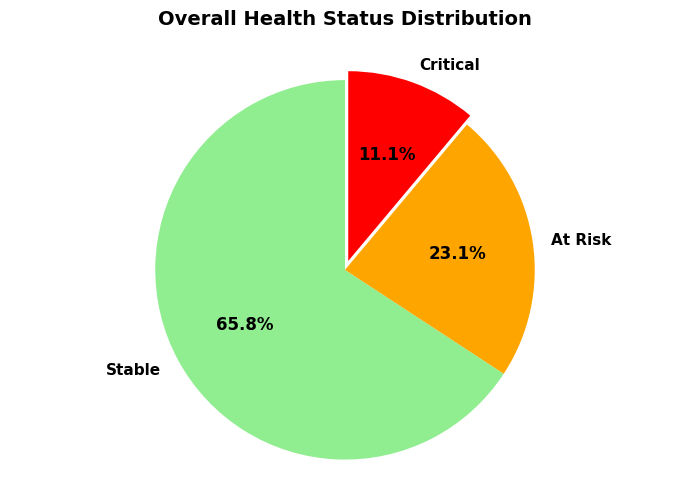



HEALTH STATUS BY AGE GROUP:
----------------------------
   • 0-17 years:
     - Stable: 50.0%
     - At Risk: 50.0%
     - Critical: 0.0%
   • 18-34 years:
     - Stable: 62.2%
     - At Risk: 24.3%
     - Critical: 13.5%
   • 35-49 years:
     - Stable: 68.2%
     - At Risk: 25.0%
     - Critical: 6.8%
   • 50-64 years:
     - Stable: 71.6%
     - At Risk: 16.4%
     - Critical: 11.9%
   • 65+ years:
     - Stable: 61.3%
     - At Risk: 26.7%
     - Critical: 12.0%


HEALTH STATUS BY GENDER:
-------------------------
   • F:
     - Stable: 72.6%
     - At Risk: 18.6%
     - Critical: 8.8%
   • M:
     - Stable: 58.9%
     - At Risk: 27.7%
     - Critical: 13.4%

      4: Detailed Patient Lists by Health Status 

CRITICAL PATIENTS (25 patients):
--------------------------------
    1. Yasmin Ahmad (Age: 25, F)
       - Abnormal temperature: 39.9°C
       - Abnormal heart rate: 48 bpm
       - Critical oxygen saturation: 82%
       - Abnormal blood glucose: 56 mg/dL
       - High blo

In [ ]:
print_header("Phase 3: Advanced Insights & Modeling - Health Status Classification")
print_heading_3("CLASSIFICATION CRITERIA:")
print("   NOTE: Patients are classified as CRITICAL based on any of the following:")
print("     • Vital Signs: Temperature ≥40°C or ≤35°C, Heart rate ≥150 or ≤40 bpm,")
print("       Oxygen saturation <88%, Blood glucose ≥400 or ≤40 mg/dL, BP ≥180/120 mmHg")
print("     • Medications: 15+ medications (critical polypharmacy) or dangerous drug interactions")
print("     • Hospitalizations: 5+ visits in last 30 days or 15+ total visits")
print("     • Age/Comorbidities: Age 85+ with health complications or 2+ recent surgeries")
print()
print("   Patients are AT RISK with moderate abnormalities:")
print("     • Vital Signs: Temperature ≥38°C or ≤35.5°C, Heart rate ≥120 or ≤50 bpm,")
print("       Oxygen saturation <94%, Blood glucose ≥250 or ≤60 mg/dL, BP ≥140/90 mmHg")
print("     • Medications: 8+ medications or potential drug interactions")
print("     • Hospitalizations: 3+ visits in last 30 days or 8+ total visits")
print()
print("   All others are classified as STABLE.\n")


# Clinical Health Status Classification

class ClinicalHealthStatusClassifier:
    """Clinical-based health status classification system"""

    def __init__(self):
        self.patient_details = {}
        self.dangerous_drug_combinations = {
            # Blood pressure medications + Heart medications
            ('Bisoprolol', 'Amlodipine'): "Beta-blocker + Calcium channel blocker - Monitor BP carefully",
            ('Bisoprolol', 'Irbesartan'): "Beta-blocker + ARB - Enhanced hypotensive effect",
            ('Amlodipine', 'Irbesartan'): "Calcium channel blocker + ARB - Additive hypotensive effect",
            # Diabetes medications
            ('Metformin', 'Insulin glargine'): "Monitor for hypoglycemia - Enhanced glucose lowering",
            ('Dulaglutide', 'Insulin glargine'): "GLP-1 agonist + Insulin - Risk of hypoglycemia",
            ('Metformin', 'Dulaglutide'): "Monitor glucose levels - Enhanced effect",
            # Anticoagulants/Blood thinners
            ('Acetylsalicylic acid', 'Sulodexide'): "Aspirin + Anticoagulant - Increased bleeding risk",
            # Psychiatric medications with others
            ('Escitalopram', 'Melatonin'): "SSRI + Melatonin - Monitor for serotonin effects",
            # Antibiotics considerations
            ('Ciprofloxacine', 'Warfarin'): "Fluoroquinolone increases anticoagulant effect",
            ('Clindamycine', 'Ciprofloxacine'): "Monitor for C. difficile with multiple antibiotics",
        }

    def assess_vital_signs(self, patient_id):
        """Assess vital signs with clinical thresholds"""
        patient_vitals = vitals[vitals['patient_id'] == patient_id].copy()

        if patient_vitals.empty:
            return 'unknown', []

        issues = []
        max_severity = 'normal' #by default

        # Temperature assessment (Celsius)
        if 'temperature' in patient_vitals.columns:
            temp_data = patient_vitals['temperature'].dropna()
            if not temp_data.empty:
                avg_temp = temp_data.mean()
                latest_temp = temp_data.iloc[-1]

                if latest_temp >= 40.0 or latest_temp <= 35.0:  # Critical
                    issues.append(f"Critical temperature: {latest_temp:.1f}°C")
                    max_severity = 'critical'
                elif latest_temp >= 38.0 or latest_temp <= 35.5:  # At risk
                    if max_severity != 'critical':
                        max_severity = 'at_risk'
                    issues.append(f"Abnormal temperature: {latest_temp:.1f}°C")

        # Heart rate assessment
        if 'heartbeat' in patient_vitals.columns:
            hr_data = patient_vitals['heartbeat'].dropna()
            if not hr_data.empty:
                latest_hr = hr_data.iloc[-1]

                if latest_hr >= 150 or latest_hr <= 40:  # Critical
                    issues.append(f"Critical heart rate: {latest_hr} bpm")
                    max_severity = 'critical'
                elif latest_hr >= 120 or latest_hr <= 50:  # At risk
                    if max_severity != 'critical':
                        max_severity = 'at_risk'
                    issues.append(f"Abnormal heart rate: {latest_hr} bpm")

        # Oxygen saturation assessment
        if 'oxygen' in patient_vitals.columns:
            o2_data = patient_vitals['oxygen'].dropna()
            if not o2_data.empty:
                latest_o2 = o2_data.iloc[-1]

                if latest_o2 < 88:  # Critical
                    issues.append(f"Critical oxygen saturation: {latest_o2}%")
                    max_severity = 'critical'
                elif latest_o2 < 94:  # At risk
                    if max_severity != 'critical':
                        max_severity = 'at_risk'
                    issues.append(f"Low oxygen saturation: {latest_o2}%")

        # Blood glucose assessment
        if 'glucose' in patient_vitals.columns:
            glucose_data = patient_vitals['glucose'].dropna()
            if not glucose_data.empty:
                latest_glucose = glucose_data.iloc[-1]

                if latest_glucose >= 400 or latest_glucose <= 40:  # Critical
                    issues.append(f"Critical blood glucose: {latest_glucose} mg/dL")
                    max_severity = 'critical'
                elif latest_glucose >= 250 or latest_glucose <= 60:  # At risk
                    if max_severity != 'critical':
                        max_severity = 'at_risk'
                    issues.append(f"Abnormal blood glucose: {latest_glucose} mg/dL")

        # Blood pressure assessment
        if 'pressure' in patient_vitals.columns:
            bp_data = patient_vitals['pressure'].dropna().astype(str)
            if not bp_data.empty:
                try:
                    latest_bp = bp_data.iloc[-1]
                    if '/' in str(latest_bp):
                        sys_val = float(str(latest_bp).split('/')[0])
                        dia_val = float(str(latest_bp).split('/')[1])

                        if sys_val >= 180 or dia_val >= 120:  # Critical
                            issues.append(f"Critical blood pressure: {latest_bp}")
                            max_severity = 'critical'
                        elif sys_val >= 140 or dia_val >= 90:  # At risk
                            if max_severity != 'critical':
                                max_severity = 'at_risk'
                            issues.append(f"High blood pressure: {latest_bp}")
                except:
                    pass

        return max_severity, issues

    def assess_medications(self, patient_id):
        """Assess medication-related risks"""
        patient_drugs = drug_patient[drug_patient['patient_id'] == patient_id]

        if patient_drugs.empty:
            return 'normal', []

        issues = []
        max_severity = 'normal'
        drug_count = len(patient_drugs)

        # Polypharmacy assessment
        if drug_count >= 15:  # Critical polypharmacy
            issues.append(f"Critical polypharmacy: {drug_count} medications")
            max_severity = 'critical'
        elif drug_count >= 8:  # At risk polypharmacy
            issues.append(f"High medication burden: {drug_count} medications")
            max_severity = 'at_risk'

        # Drug interaction assessment
        if not drugs.empty and 'generic_name' in drugs.columns:
            patient_drug_ids = patient_drugs['drug_id'].tolist()
            patient_drug_info = drugs[drugs['id'].isin(patient_drug_ids)][['id', 'name', 'generic_name']]

            # Check for dangerous interactions
            for i in range(len(patient_drug_info)):
                for j in range(i+1, len(patient_drug_info)):
                    drug1_name = patient_drug_info.iloc[i]['generic_name']
                    drug2_name = patient_drug_info.iloc[j]['generic_name']

                    if pd.isna(drug1_name): drug1_name = patient_drug_info.iloc[i]['name']
                    if pd.isna(drug2_name): drug2_name = patient_drug_info.iloc[j]['name']

                    combination = tuple(sorted([drug1_name, drug2_name]))

                    if combination in self.dangerous_drug_combinations:
                        interaction_desc = self.dangerous_drug_combinations[combination]
                        issues.append(f"Drug interaction: {drug1_name} + {drug2_name} - {interaction_desc}")
                        if 'critical' in interaction_desc.lower() or 'bleeding risk' in interaction_desc.lower():
                            max_severity = 'critical'
                        elif max_severity != 'critical':
                            max_severity = 'at_risk'

        return max_severity, issues

    def assess_recent_hospitalizations(self, patient_id):
        """Assess hospitalization patterns"""
        patient_visits = hospital_patient[hospital_patient['patient_id'] == patient_id].copy()

        if patient_visits.empty:
            return 'normal', []

        issues = []
        max_severity = 'normal'

        # Recent hospitalizations (last 30 days)
        if 'created_at' in patient_visits.columns:
            recent_date = datetime.now() - timedelta(days=30)
            recent_visits = patient_visits[patient_visits['created_at'] > recent_date]

            if len(recent_visits) >= 5:  # Critical
                issues.append(f"Frequent recent hospitalizations: {len(recent_visits)} in last 30 days")
                max_severity = 'critical'
            elif len(recent_visits) >= 3:  # At risk
                issues.append(f"Multiple recent hospitalizations: {len(recent_visits)} in last 30 days")
                max_severity = 'at_risk'

        # Long-term hospitalization pattern
        total_visits = len(patient_visits)
        if total_visits >= 15:  # Critical
            if max_severity != 'critical':
                issues.append(f"Extensive hospitalization history: {total_visits} visits")
                max_severity = 'critical'
        elif total_visits >= 8:  # At risk
            if max_severity not in ['critical']:
                issues.append(f"Frequent hospitalization history: {total_visits} visits")
                if max_severity != 'critical':
                    max_severity = 'at_risk'

        return max_severity, issues

    def assess_age_and_comorbidities(self, patient_id):
        """Assess age-related and comorbidity risks"""
        patient_info = patients[patients['id'] == patient_id]

        if patient_info.empty:
            return 'normal', []

        issues = []
        max_severity = 'normal'

        # Age assessment - only flag if combined with other health issues
        # Age alone should not determine risk status
        age = None
        if 'age' in patient_info.columns:
            age = patient_info['age'].iloc[0]

        # Surgery history assessment
        if not surgeries.empty and 'patient_id' in surgeries.columns:
            patient_surgeries = surgeries[surgeries['patient_id'] == patient_id]
            surgery_count = len(patient_surgeries)

            # Check for recent major surgeries
            recent_surgeries = patient_surgeries[patient_surgeries['created_at'] > (datetime.now() - timedelta(days=90))]

            if len(recent_surgeries) >= 2:  # Critical
                issues.append(f"Multiple recent surgeries: {len(recent_surgeries)} in last 90 days")
                max_severity = 'critical'
            elif len(recent_surgeries) >= 1:  # At risk
                surgery_name = recent_surgeries.iloc[0]['procedure_name']
                issues.append(f"Recent surgery: {surgery_name}")
                if max_severity != 'critical':
                    max_severity = 'at_risk'

            # High surgery count overall - only flag if very high number
            if surgery_count >= 5:
                if max_severity != 'critical':
                    issues.append(f"Extensive surgical history: {surgery_count} procedures")
                    max_severity = 'critical'

        # Age becomes a risk factor only if there are other health issues present
        # and the patient is very elderly (85+)
        if age and pd.notna(age) and age >= 85 and (surgery_count > 0 or len(issues) > 0):
            issues.append(f"Advanced age with health complications: {age:.0f} years")
            max_severity = 'critical'

        return max_severity, issues

    def classify_patient_health(self, patient_id):
        """Comprehensive patient health classification"""
        # Get patient basic info
        patient_info = patients[patients['id'] == patient_id]
        if patient_info.empty:
            return None

        patient_data = patient_info.iloc[0]

        # Assess all components
        vital_severity, vital_issues = self.assess_vital_signs(patient_id)
        med_severity, med_issues = self.assess_medications(patient_id)
        hosp_severity, hosp_issues = self.assess_recent_hospitalizations(patient_id)
        age_severity, age_issues = self.assess_age_and_comorbidities(patient_id)

        # Combine all issues
        all_issues = vital_issues + med_issues + hosp_issues + age_issues
        all_severities = [vital_severity, med_severity, hosp_severity, age_severity]

        # Determine overall status
        if 'critical' in all_severities:
            overall_status = 'Critical'
        elif 'at_risk' in all_severities:
            overall_status = 'At Risk'
        else:
            overall_status = 'Stable'

        # Store detailed information
        self.patient_details[patient_id] = {
            'patient_id': patient_id,
            'name': f"{patient_data.get('first_name', '')} {patient_data.get('last_name', '')}".strip(),
            'age': patient_data.get('age', np.nan),
            'gender': patient_data.get('gender', 'Unknown'),
            'overall_status': overall_status,
            'vital_severity': vital_severity,
            'medication_severity': med_severity,
            'hospitalization_severity': hosp_severity,
            'age_comorbidity_severity': age_severity,
            'issues': all_issues,
            'total_issues': len(all_issues)
        }

        return self.patient_details[patient_id]

# Initialize classifier
classifier = ClinicalHealthStatusClassifier()

print_dashed_heading("2: Patient Health Classification")

# Classify all patients
print_heading_3("Classifying all patients...")

patient_classifications = []
total_patients = len(patients)

for idx, patient_id in enumerate(patients['id'], 1):
    if idx % 100 == 0 or idx == total_patients:
        print(f"   Processing patient {idx}/{total_patients}...")

    classification = classifier.classify_patient_health(patient_id)
    if classification:
        patient_classifications.append(classification)

# Convert to DataFrame
classification_df = pd.DataFrame(patient_classifications)

print_heading_3(f" Health classification completed for {len(classification_df)} patients")

print_dashed_heading("3: Health Status Distribution Analysis")

# Overall health status distribution
print_heading_3("OVERALL HEALTH STATUS DISTRIBUTION and its Visualization:")
status_counts = classification_df['overall_status'].value_counts()
total_patients = len(classification_df)

for status, count in status_counts.items():
    percentage = (count / total_patients) * 100
    print(f"   • {status}: {count:,} patients ({percentage:.1f}%)")
# Visualization for overall health status distribution: Pie Chart
plt.figure(figsize=(7, 5))

status_colors = {
    'Stable': 'lightgreen',
    'At Risk': 'orange',
    'Critical': 'red'
}

colors = [status_colors.get(status, 'gray') for status in status_counts.index]

wedges, texts, autotexts = plt.pie(status_counts.values,
                                  labels=status_counts.index,
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90,
                                  explode=[0.05 if status == 'Critical' else 0 for status in status_counts.index])

plt.title('Overall Health Status Distribution', fontweight='bold', fontsize=14, pad=20)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(11)

plt.axis('equal')

plt.tight_layout()
plt.show()

# Health status by age group
print_heading_3(f"\nHEALTH STATUS BY AGE GROUP:")
classification_df['age_group'] = pd.cut(classification_df['age'],
                                       bins=[0, 18, 35, 50, 65, 100],
                                       labels=['0-17', '18-34', '35-49', '50-64', '65+'],
                                       include_lowest=True)

age_status_crosstab = pd.crosstab(classification_df['age_group'],
                                  classification_df['overall_status'],
                                  normalize='index') * 100

for age_group in age_status_crosstab.index:
    print(f"   • {age_group} years:")
    for status in ['Stable', 'At Risk', 'Critical']:
        if status in age_status_crosstab.columns:
            percentage = age_status_crosstab.loc[age_group, status]
            print(f"     - {status}: {percentage:.1f}%")

# Health status by gender
print_heading_3(f"\nHEALTH STATUS BY GENDER:")
gender_status_crosstab = pd.crosstab(classification_df['gender'],
                                     classification_df['overall_status'],
                                     normalize='index') * 100

for gender in gender_status_crosstab.index:
    print(f"   • {gender}:")
    for status in ['Stable', 'At Risk', 'Critical']:
        if status in gender_status_crosstab.columns:
            percentage = gender_status_crosstab.loc[gender, status]
            print(f"     - {status}: {percentage:.1f}%")

print_dashed_heading("4: Detailed Patient Lists by Health Status")

# Critical patients with detailed reasons
critical_patients = classification_df[classification_df['overall_status'] == 'Critical'].sort_values('total_issues', ascending=False)

print_heading_3(f"CRITICAL PATIENTS ({len(critical_patients)} patients):")
if not critical_patients.empty:
    for idx, (_, patient) in enumerate(critical_patients.head(15).iterrows(), 1):
        patient_id = patient['patient_id']
        details = classifier.patient_details[patient_id]
        name = details['name'] if details['name'].strip() else f"Patient {patient_id}"
        age_str = f"{details['age']:.0f}" if pd.notna(details['age']) else "N/A"

        print(f"   {idx:2d}. {name} (Age: {age_str}, {details['gender']})")
        for issue in details['issues']:
            print(f"       - {issue}")
        print()
else:
    print("   • No critical patients identified")

# At-risk patients with detailed reasons
at_risk_patients = classification_df[classification_df['overall_status'] == 'At Risk'].sort_values('total_issues', ascending=False)

print_heading_3(f"AT-RISK PATIENTS ({len(at_risk_patients)} patients):")
if not at_risk_patients.empty:
    for idx, (_, patient) in enumerate(at_risk_patients.iterrows(), 1):
        patient_id = patient['patient_id']
        details = classifier.patient_details[patient_id]
        name = details['name'] if details['name'].strip() else f"Patient {patient_id}"
        age_str = f"{details['age']:.0f}" if pd.notna(details['age']) else "N/A"

        print(f"   {idx:2d}. {name} (Age: {age_str}, {details['gender']})")
        for issue in details['issues']:
            print(f"       - {issue}")
        print()
else:
    print("   • No at-risk patients identified")


# Stable patients summary
stable_patients = classification_df[classification_df['overall_status'] == 'Stable']
print_heading_3(f"STABLE PATIENTS ({len(stable_patients)} patients):")
print("   • Patients with normal vital signs, appropriate medications, and no recent complications")
print("   • Require routine monitoring and preventive care")

print_dashed_heading("6: Component Analysis")

print_heading_3("HEALTH COMPONENT DISTRIBUTION:")
for component in ['vital_severity', 'medication_severity', 'hospitalization_severity', 'age_comorbidity_severity']:
    component_name = component.replace('_severity', '').replace('_', ' ').title()
    component_counts = classification_df[component].value_counts()
    print(f"   • {component_name}:")
    for severity, count in component_counts.items():
        percentage = (count / total_patients) * 100
        if severity.lower() == 'unknown':
            print(f"     - {severity.title()} (Patients with no vitals data): {count:,} ({percentage:.1f}%)")
        else:
            print(f"     - {severity.title()}: {count:,} ({percentage:.1f}%)")


critical_count = len(critical_patients)
at_risk_count = len(at_risk_patients)
stable_count = len(stable_patients)

# Calculate percentages for the final summary
critical_pct = (critical_count / total_patients) * 100
at_risk_pct = (at_risk_count / total_patients) * 100

# Display final summary
print_heading_3("FINAL SUMMARY:")
print(f"   • Total Patients Classified: {len(classification_df):,}")
print(f"   • Critical Patients: {critical_count:,} ({critical_pct:.1f}%)")
print(f"   • At-Risk Patients: {at_risk_count:,} ({at_risk_pct:.1f}%)")
print(f"   • Stable Patients: {stable_count:,} ({(stable_count/total_patients)*100:.1f}%)")
print(f"   • Components Analyzed: Vital signs, medications, hospitalizations, age/comorbidities")

print_header("CLINICAL HEALTHCARE ANALYTICS COMPLETE: Patients classified for clinical decision support")

# **Phase 3: Temporal pattern mining - Detect recurring health events**


  Phase 3: Advanced Insights & Modeling - Temporal Pattern Mining- Detect Recurring Health Events   
   NOTE: This analysis identifies temporal patterns across multiple healthcare dimensions:
     • Vital Signs: Monthly patterns, recurring abnormal episodes, age-based trends
     • Hospitalizations: Peak admission times, seasonal patterns
     • Surgery-Doctor Patterns: Specialty correlations, surgical timing trends, doctor linkage
     • Drug Prescriptions: Age-based patterns, combination therapies, dosing frequencies
     • Medical Tests: Testing frequency, seasonal trends, result cyclical patterns


      1: Data Preparation for Temporal Analysis 

  Temporal features extracted: month, season, day_of_week, year
---------------------------------------------------------------

      2: Recurring Vitals Patterns Analysis 

Analyzing vital sign patterns for all patients...
-------------------------------------------------

  Vital patterns analyzed for 134 patients with vital data
----

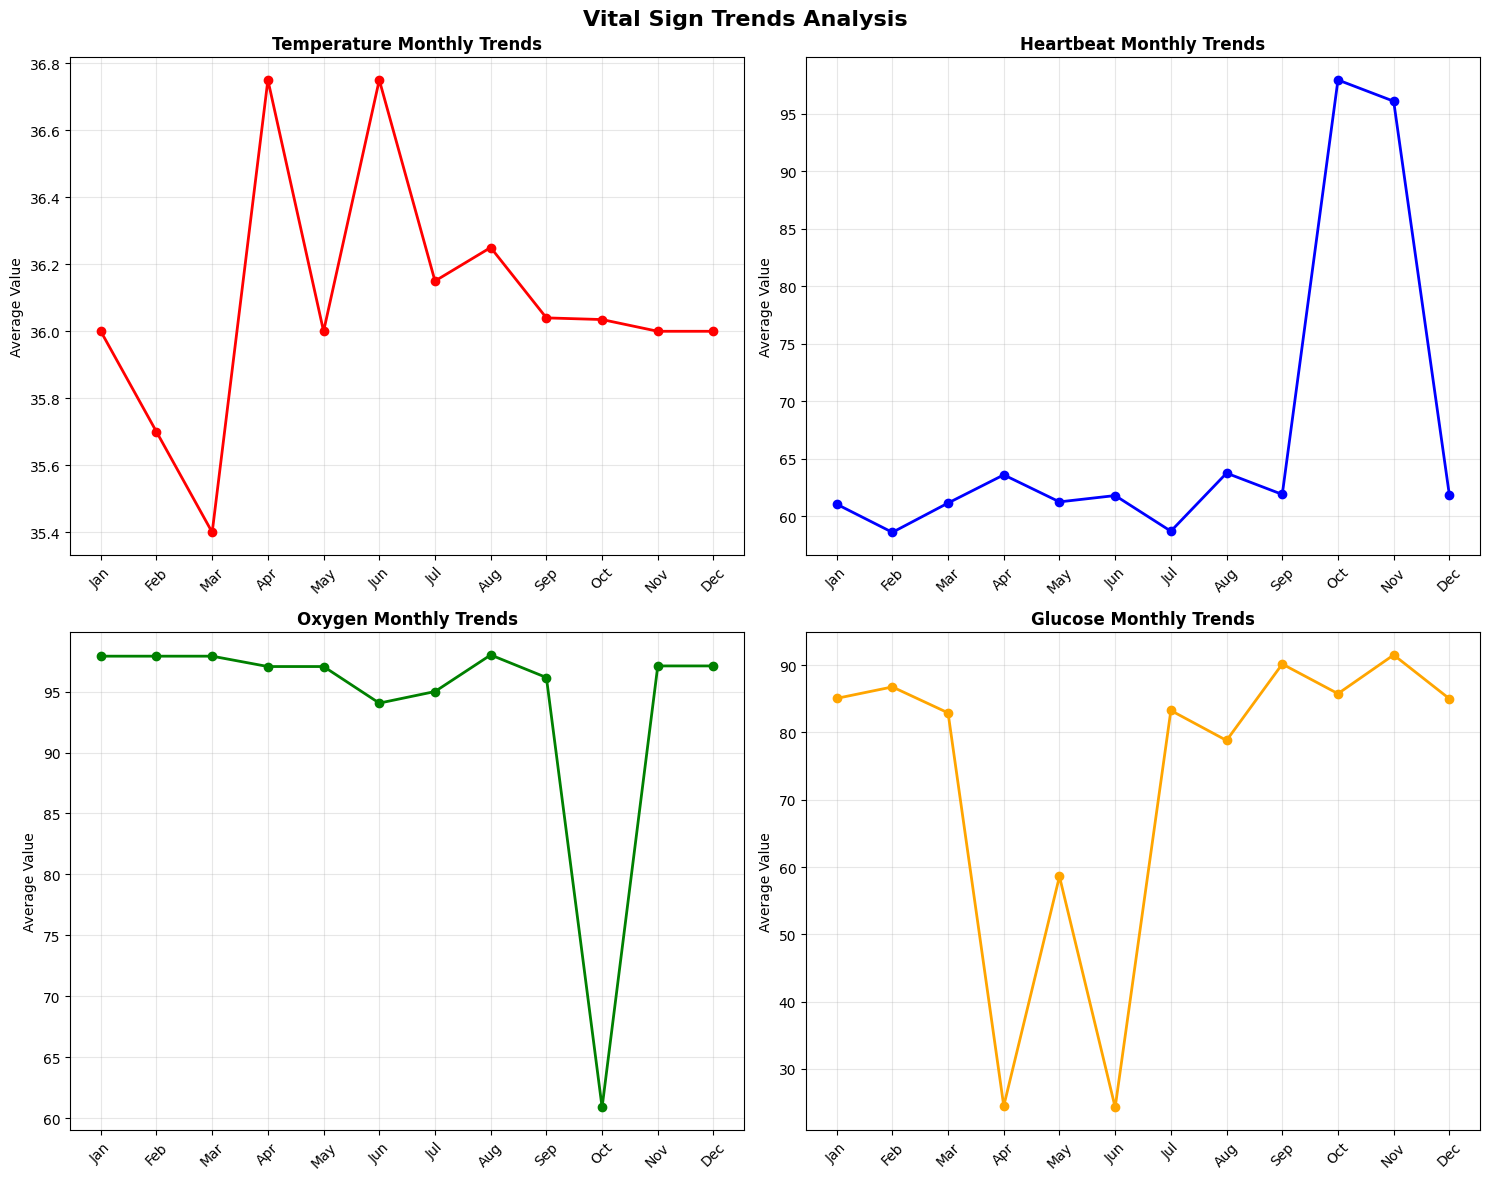


      3: Hospitalization Patterns Analysis 

HOSPITALIZATION TEMPORAL PATTERNS:
----------------------------------
   Peak Admission Months:
     • Mar: 10 admissions
     • May: 8 admissions
     • Jun: 8 admissions
   Seasonal Admission Distribution:
     • Fall: 13 admissions (21.7%)
     • Spring: 19 admissions (31.7%)
     • Summer: 15 admissions (25.0%)
     • Winter: 13 admissions (21.7%)
   Hospital Utilization Patterns:
     • AUMBC: 23 admissions (38.3%)
     • Zahraa Hospital: 22 admissions (36.7%)
     • Bikhazi Hospital: 15 admissions (25.0%)

READMISSION PATTERNS:
---------------------
   Total Patients with Readmissions: 11
   Readmission Frequency Distribution:
     • 2 admissions: 10 patients
     • 3 admissions: 1 patients
   30-Day Readmissions: 1
   90-Day Readmissions: 2
   Average Days Between Readmissions: 392.2

AGE-DISEASE ADMISSION PATTERNS:
-------------------------------
   Admission Distribution by Age Group:
     • 65+ years: 24 admissions (40.0%)
     • 

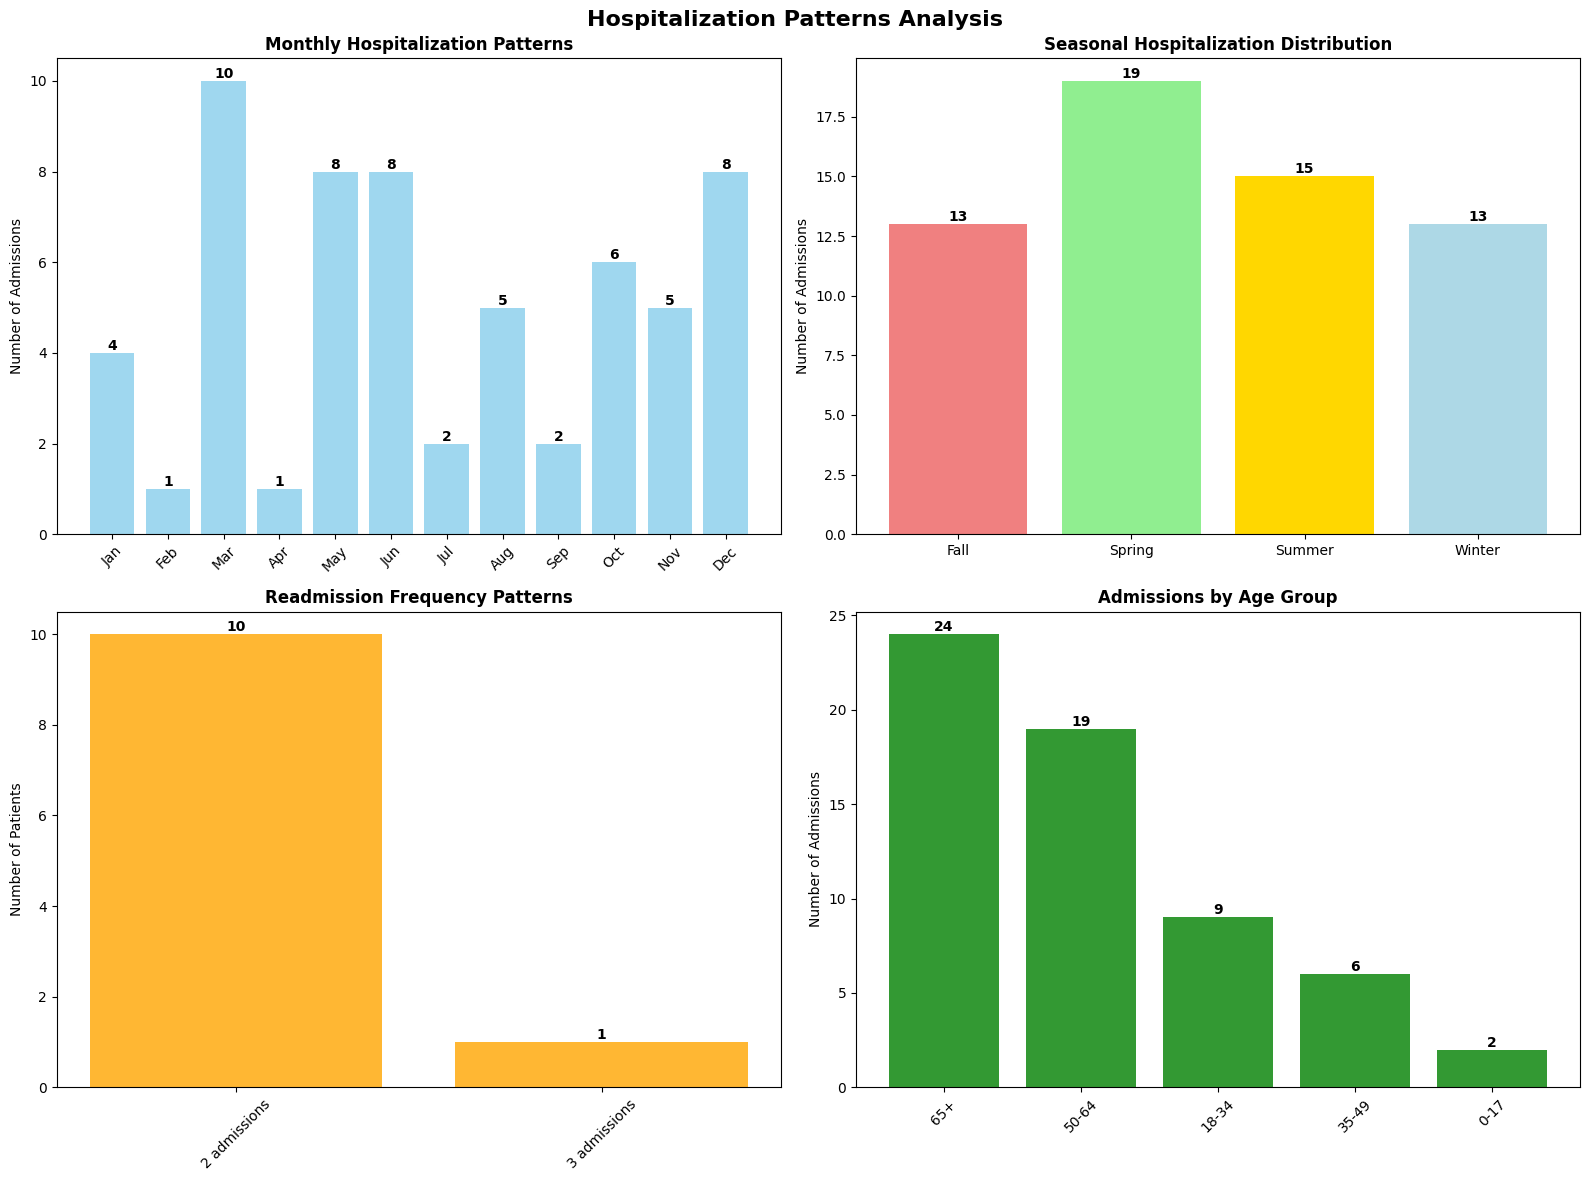


      4: Doctor-Surgery Patterns Analysis 

Most Frequently Visited Doctors (General):
------------------------------------------
   • Dr. Fatima Saad: 10 appointments
   • Dr. Hassan Nour: 8 appointments
   • Dr. Omar Fares: 6 appointments
   • Dr. Khalil Hammoud: 6 appointments
   • Dr. Ahmad Khalil: 5 appointments

Most Visited Doctor Per Specialty:
----------------------------------
   • Cardiology: Dr. Ahmad Khalil (5 appointments)
   • Endocrinology: Dr. Fatima Saad (10 appointments)
   • General Surgery: Dr. Hassan Nour (8 appointments)
   • Internal Medicine: Dr. Rania Haddad (4 appointments)
   • Cardiac Surgery: Dr. Khalil Hammoud (6 appointments)
   • Ophthalmology: Dr. Reem Marwani (5 appointments)
   • Pediatrics: Dr. Khadija Mahmoud (3 appointments)
   • Urology: Dr. Ahmad Nabulsi (3 appointments)
   • Radiology: Dr. Yusuf Fleifel (5 appointments)
   • Orthopedics: Dr. Aisha Marwani (4 appointments)

Doctor Specialization by Age Group:
-----------------------------------

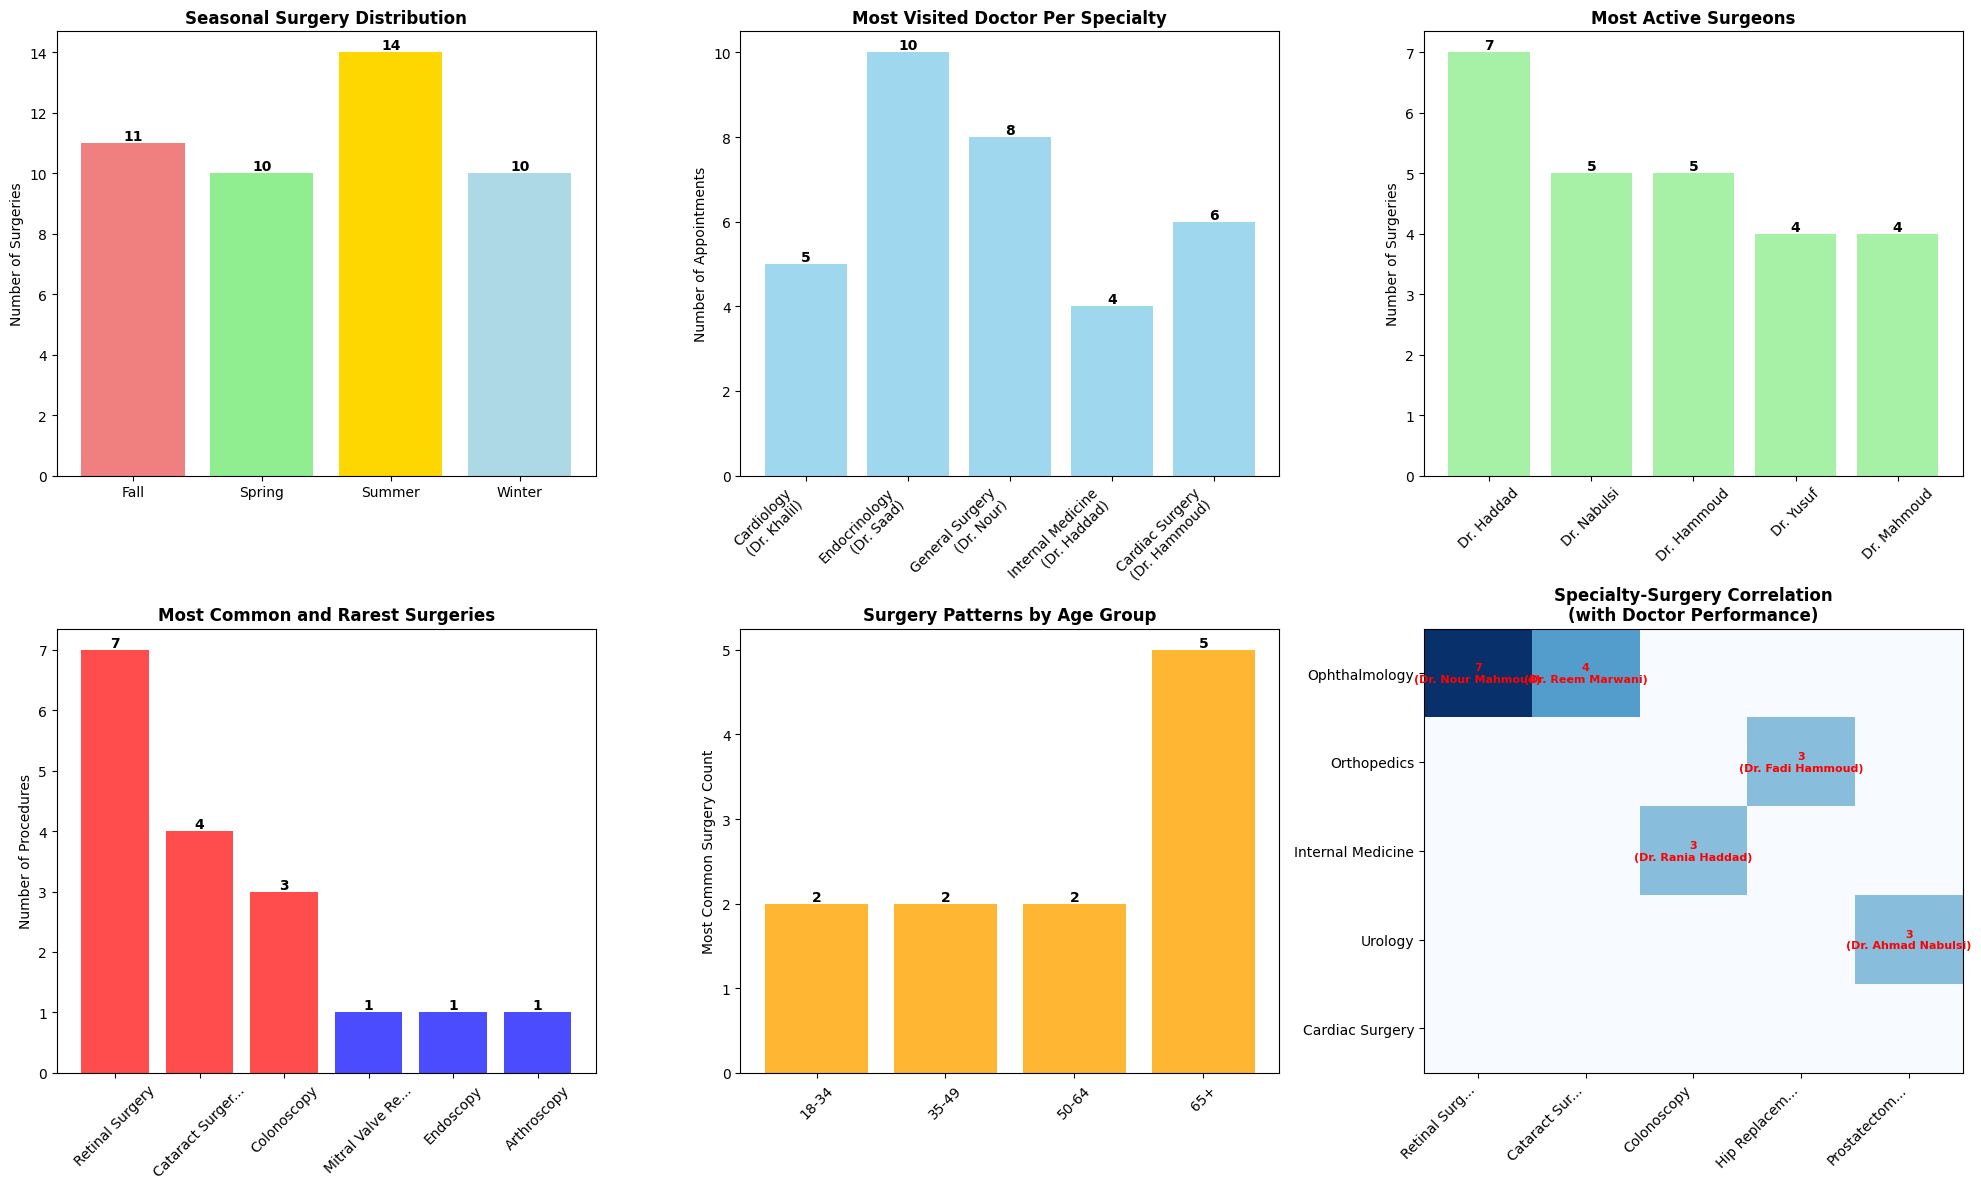


      5: Drug Prescription Patterns Analysis 

COMPREHENSIVE DRUG PRESCRIPTION PATTERNS:
-----------------------------------------

1. POLYPHARMACY ANALYSIS (Number of medications per patient):
-------------------------------------------------------------
   • 1 medication: 45 patients
   • 2-4 medications: 46 patients
   • 5-9 medications: 5 patients
   • 10-14 medications: 1 patients
   • 15+ medications: 1 patients

2. DANGEROUS DRUG COMBINATIONS:
-------------------------------
   Most Common Dangerous Combinations:
   • Acetylsalicylic acid + Furosemide: 4 patients
   • Acetylsalicylic acid + Sulodexide: 3 patients
   • Escitalopram + Melatonin: 3 patients
   • Bisoprolol + Irbesartan: 1 patients

3. COMMON DRUG COMBINATIONS:
----------------------------
   Most Common Combinations:
   • Acetylsalicylic acid + Bisoprolol: 7 patients
   • Acetylsalicylic acid + Dulaglutide: 5 patients
   • Acetylsalicylic acid + spironolactone: 5 patients
   • Dulaglutide + Metformin: 5 patients
 

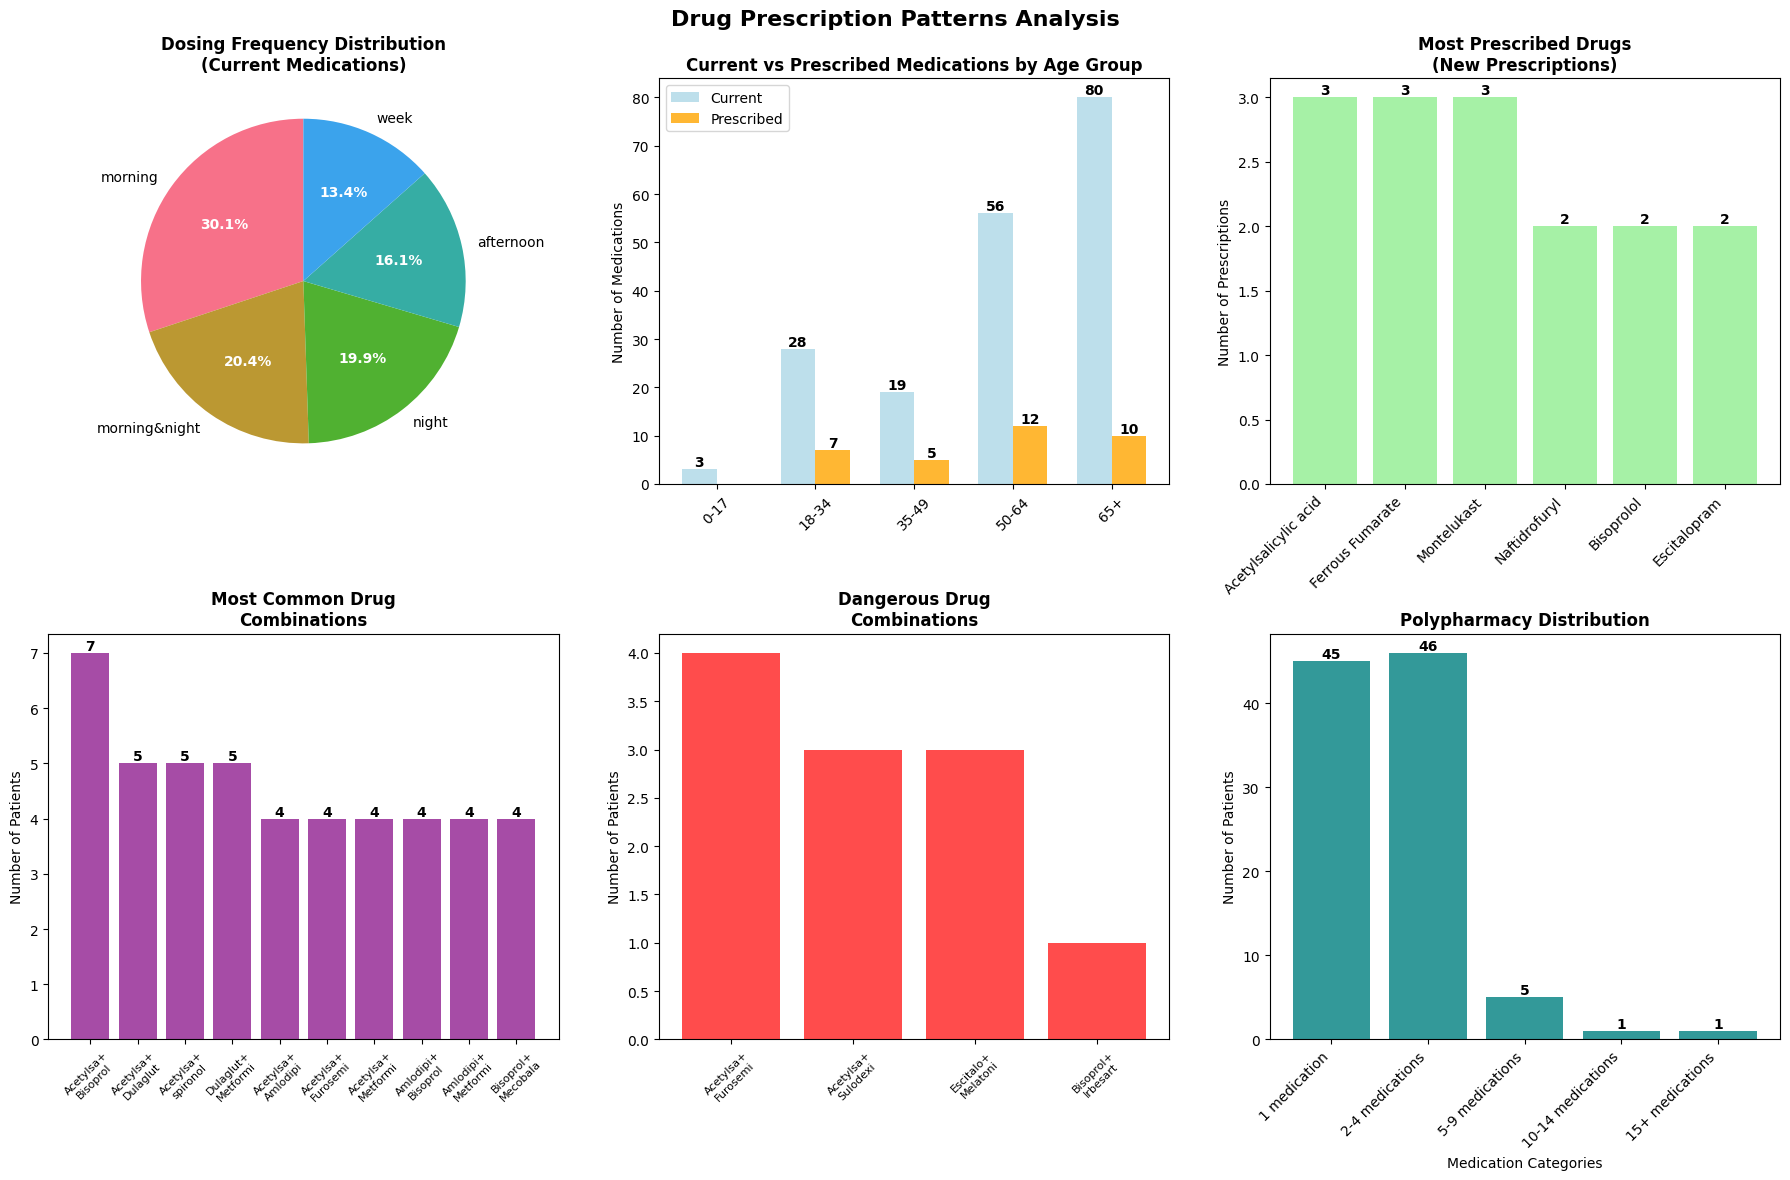


      6: Medical Test Patterns Analysis 

MEDICAL TESTING FREQUENCY AND TRENDS:
-------------------------------------
   Test Frequency Distribution:
     • Average tests per patient: 1.2
     • Most tests for single patient: 7
     • Patients with 5+ tests: 1
   Seasonal Testing Patterns:
     • Fall: 22 tests (34.9%)
     • Spring: 17 tests (27.0%)
     • Summer: 16 tests (25.4%)
     • Winter: 8 tests (12.7%)
   Average interval between tests: 173 days


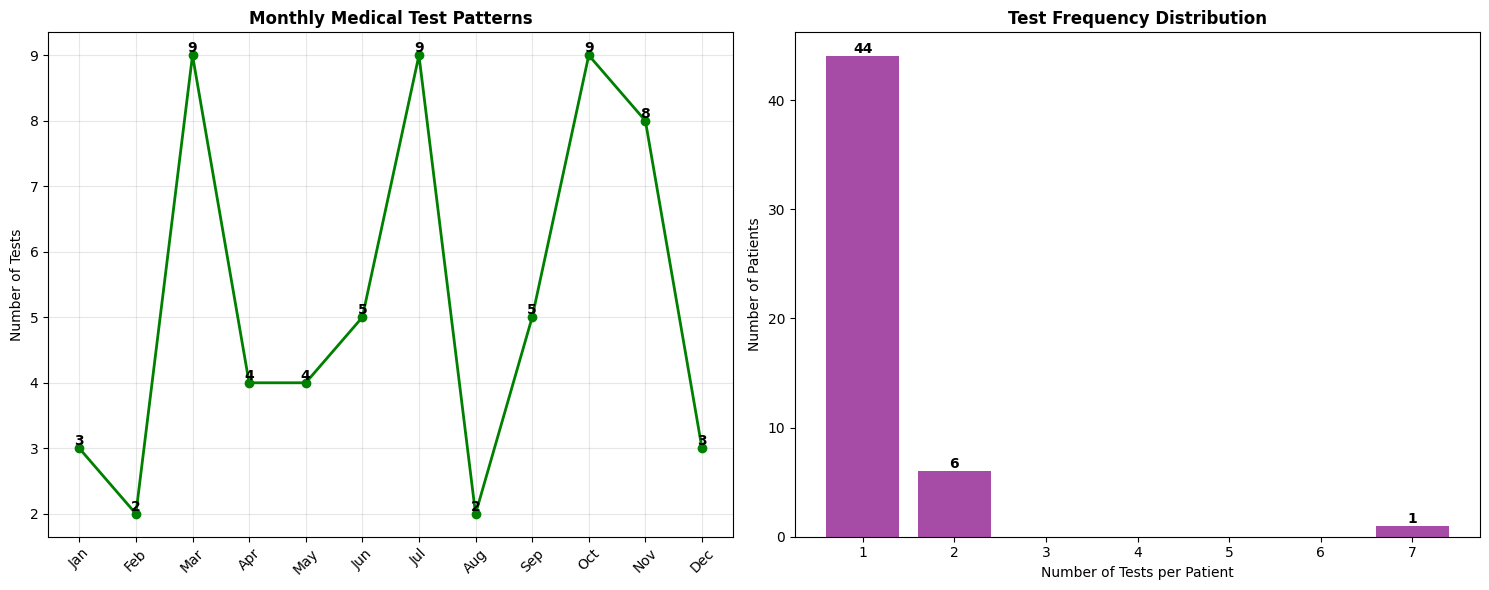


      7: Comprehensive Temporal Insights Summary 

KEY TEMPORAL PATTERNS IDENTIFIED:
---------------------------------
   • Vital Signs Analysis:
     - Patients analyzed: 134
     - Patients with high abnormal episodes (>20%): 48
   • Hospitalization Patterns:
     - Peak admission month: March
     - Peak admission season: Spring
   • Surgical Patterns:
     - Total procedures analyzed: 45
     - Peak surgery month: July
   • Prescription Patterns:
     - Total prescriptions analyzed: 186
     - Most common dosing time: morning
   • Medical Testing Patterns:
     - Peak testing month: March
     - Peak testing season: Fall

     TEMPORAL PATTERN MINING COMPLETE: Recurring health events and cyclical patterns identified     


In [ ]:
print_header("Phase 3: Advanced Insights & Modeling - Temporal Pattern Mining- Detect Recurring Health Events")
print("   NOTE: This analysis identifies temporal patterns across multiple healthcare dimensions:")
print("     • Vital Signs: Monthly patterns, recurring abnormal episodes, age-based trends")
print("     • Hospitalizations: Peak admission times, seasonal patterns")
print("     • Surgery-Doctor Patterns: Specialty correlations, surgical timing trends, doctor linkage")
print("     • Drug Prescriptions: Age-based patterns, combination therapies, dosing frequencies")
print("     • Medical Tests: Testing frequency, seasonal trends, result cyclical patterns")
print()

# Safety check - ensure all required tables are DataFrames
required_dataframes = ['patients', 'vitals', 'hospital_patient', 'medical_tests', 'surgeries', 'drug_patient', 'drugs']
for df_name in required_dataframes:
    if df_name in globals() and not isinstance(globals()[df_name], pd.DataFrame):
        globals()[df_name] = pd.read_csv(f"/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/{df_name}.csv")
        print(f"Reloaded {df_name} from CSV.")
        #if it is the vitals one, clean it using clean_vitals_data(vitals)
        if df_name == 'vitals':
            vitals = clean_vitals_data(vitals)

print_dashed_heading("1: Data Preparation for Temporal Analysis")


# Enhanced datetime preparation
def prepare_temporal_data():
    """Enhanced datetime conversion and temporal feature extraction"""

    # Convert datetime columns with proper handling
    datetime_tables = {
        'patients': ['created_at', 'dob'],
        'vitals': ['created_at'],
        'hospital_patient': ['created_at'],
        'medical_tests': ['created_at'],
        'surgeries': ['created_at'],
        'appointments': ['appointment_datetime', 'created_at'],
        'drug_patient': ['end_of_treatment']
    }

    for table_name, columns in datetime_tables.items():
        if table_name in globals():
            table = globals()[table_name]
            for col in columns:
                if col in table.columns:
                    table[col] = pd.to_datetime(table[col], errors='coerce')

    # Calculate patient ages
    if 'dob' in patients.columns:
        patients['age'] = (datetime.now() - patients['dob']).dt.days / 365.25
        patients['age'] = patients['age'].clip(lower=0, upper=120)

    # Add temporal features
    for table_name in ['vitals', 'hospital_patient', 'medical_tests', 'surgeries']:
        if table_name in globals():
            table = globals()[table_name]
            if 'created_at' in table.columns:
                table['month'] = table['created_at'].dt.month
                table['season'] = table['created_at'].dt.month.map({
                    12: 'Winter', 1: 'Winter', 2: 'Winter',
                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                    9: 'Fall', 10: 'Fall', 11: 'Fall'
                })
                table['day_of_week'] = table['created_at'].dt.day_name()
                table['year'] = table['created_at'].dt.year

    print_heading_3("  Temporal features extracted: month, season, day_of_week, year")

prepare_temporal_data()
#---------------------------------------------------------------------VITALS----------------------------------------------------------------------
print_dashed_heading("2: Recurring Vitals Patterns Analysis")

class VitalPatternsAnalyzer:
    """Analyze recurring vital sign patterns and abnormal episodes"""

    def __init__(self):
        self.vital_thresholds = {
            'temperature': {'critical_high': 40.0, 'high': 38.0, 'low': 35.5, 'critical_low': 35.0},
            'heartbeat': {'critical_high': 150, 'high': 120, 'low': 50, 'critical_low': 40},
            'oxygen': {'critical_low': 88, 'low': 94},
            'glucose': {'critical_high': 400, 'high': 250, 'low': 60, 'critical_low': 40},
        }

    def analyze_patient_vital_patterns(self, patient_id):
        """Analyze vital patterns for a specific patient"""
        patient_vitals = vitals[vitals['patient_id'] == patient_id].copy()

        if patient_vitals.empty:
            return None

        # Sort by date
        patient_vitals = patient_vitals.sort_values('created_at')

        patterns = {
            'patient_id': patient_id,
            'total_readings': len(patient_vitals),
            'date_range': f"{patient_vitals['created_at'].min().strftime('%Y-%m')} to {patient_vitals['created_at'].max().strftime('%Y-%m')}",
            'abnormal_episodes': {},
            'monthly_patterns': {}
        }

        # Analyze each vital parameter
        for vital in ['temperature', 'heartbeat', 'oxygen', 'glucose']:
            if vital in patient_vitals.columns:
                vital_data = patient_vitals[vital].dropna()

                if not vital_data.empty:
                    # Monthly most common patterns (mode/recurring values)
                    monthly_patterns = {}
                    for month in patient_vitals['month'].unique():
                        month_data = patient_vitals[patient_vitals['month'] == month][vital].dropna()
                        if len(month_data) > 0:
                            # Get most frequent value ranges (binned for continuous data)
                            if vital in ['temperature', 'heartbeat', 'oxygen', 'glucose']:
                                # Create bins for pattern detection
                                bins = pd.cut(month_data, bins=5, precision=1)
                                mode_bin = bins.mode()
                                if len(mode_bin) > 0:
                                    # Extract midpoint of most common bin
                                    mode_interval = mode_bin.iloc[0]
                                    monthly_patterns[month] = mode_interval.mid
                                else:
                                    monthly_patterns[month] = month_data.median()

                    patterns['monthly_patterns'][vital] = monthly_patterns

                    # Abnormal episodes detection
                    abnormal_count = 0
                    if vital in self.vital_thresholds:
                        thresholds = self.vital_thresholds[vital]

                        if 'critical_high' in thresholds:
                            abnormal_count += (vital_data >= thresholds['critical_high']).sum()
                            abnormal_count += (vital_data >= thresholds['high']).sum()
                        if 'critical_low' in thresholds:
                            abnormal_count += (vital_data <= thresholds['critical_low']).sum()
                            abnormal_count += (vital_data <= thresholds['low']).sum()

                    patterns['abnormal_episodes'][vital] = {
                        'count': abnormal_count,
                        'percentage': (abnormal_count / len(vital_data)) * 100 if len(vital_data) > 0 else 0
                    }

        return patterns

    def get_overall_vital_trends(self):
        """Get overall vital trends across all patients - using recurring patterns"""

        # Monthly vital trends
        monthly_trends = {}
        age_trends = {}

        # Merge vitals with patient ages
        vitals_with_age = vitals.merge(patients[['id', 'age']], left_on='patient_id', right_on='id', how='left')

        for vital in ['temperature', 'heartbeat', 'oxygen', 'glucose']:
            if vital in vitals.columns:
                # Monthly most common patterns instead of averages
                monthly_patterns = {}
                for month in vitals['month'].unique():
                    month_data = vitals[vitals['month'] == month][vital].dropna()
                    if len(month_data) > 0:
                        # Find most common value range
                        bins = pd.cut(month_data, bins=10, precision=1)
                        mode_bin = bins.mode()
                        if len(mode_bin) > 0:
                            monthly_patterns[month] = mode_bin.iloc[0].mid
                        else:
                            monthly_patterns[month] = month_data.median()

                monthly_trends[vital] = monthly_patterns

                # Age-based recurring patterns
                if 'age' in vitals_with_age.columns:
                    vitals_with_age['age_group'] = pd.cut(vitals_with_age['age'],
                                                        bins=[0, 18, 35, 50, 65, 100],
                                                        labels=['0-17', '18-34', '35-49', '50-64', '65+'])

                    age_patterns = {}
                    for age_group in vitals_with_age['age_group'].unique():
                        if pd.notna(age_group):
                            age_data = vitals_with_age[vitals_with_age['age_group'] == age_group][vital].dropna()
                            if len(age_data) > 0:
                                # Find most common value range for this age group
                                bins = pd.cut(age_data, bins=10, precision=1)
                                mode_bin = bins.mode()
                                if len(mode_bin) > 0:
                                    age_patterns[age_group] = mode_bin.iloc[0].mid
                                else:
                                    age_patterns[age_group] = age_data.median()

                    age_trends[vital] = age_patterns

        return monthly_trends, age_trends

# Initialize vital patterns analyzer
vital_analyzer = VitalPatternsAnalyzer()

print_heading_3("Analyzing vital sign patterns for all patients...")

# Analyze patterns for patients with vital data (reduce threshold for more patients)
patient_vital_patterns = []
patients_with_vitals = vitals['patient_id'].unique()

for patient_id in patients_with_vitals:
    pattern = vital_analyzer.analyze_patient_vital_patterns(patient_id)
    if pattern and pattern['total_readings'] >= 1:  # Include all patients with any vital data
        patient_vital_patterns.append(pattern)

print_heading_3(f"  Vital patterns analyzed for {len(patient_vital_patterns)} patients with vital data")

# Get overall trends
monthly_vital_trends, age_vital_trends = vital_analyzer.get_overall_vital_trends()

print_heading_3("MONTHLY VITAL SIGN RECURRING PATTERNS (Most Common Range):")
for vital, trends in monthly_vital_trends.items():
    print(f"   • {vital.title()}:")
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    for month, pattern_value in trends.items():
        if pd.notna(pattern_value):
            print(f"     - {month_names[month]}: {pattern_value:.1f}")

print_heading_3("AGE-BASED VITAL SIGN RECURRING PATTERNS:")
for vital, trends in age_vital_trends.items():
    print(f"   • {vital.title()}:")
    for age_group, pattern_value in trends.items():
        if pd.notna(pattern_value):
            print(f"     - {age_group} years: {pattern_value:.1f}")

# Visualization: Monthly and Age-based Vital Trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Vital Sign Trends Analysis', fontsize=16, fontweight='bold')

vital_names = ['temperature', 'heartbeat', 'oxygen', 'glucose']
colors = ['red', 'blue', 'green', 'orange']

for idx, vital in enumerate(vital_names):
    if vital in monthly_vital_trends and monthly_vital_trends[vital]:
        ax = axes[idx//2, idx%2]

        # Monthly trends
        months = sorted([m for m in monthly_vital_trends[vital].keys() if pd.notna(monthly_vital_trends[vital][m])])
        values = [monthly_vital_trends[vital][m] for m in months]
        month_labels = [['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][m-1] for m in months]

        if values:
            line = ax.plot(month_labels, values, marker='o', linewidth=2, markersize=6,
                          color=colors[idx], label='Monthly Average')
            ax.set_title(f'{vital.title()} Monthly Trends', fontweight='bold')
            ax.set_ylabel('Average Value')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
#---------------------------------------------------------------------HOSPITALIZATION-------------------------------------------------
print_dashed_heading("3: Hospitalization Patterns Analysis")

class HospitalizationPatternsAnalyzer:
    """Analyze hospitalization patterns including readmissions and age-disease correlations"""

    def __init__(self):
        self.age_groups = {
            'Pediatric': (0, 17),
            'Young Adult': (18, 34),
            'Middle Age': (35, 49),
            'Older Adult': (50, 64),
            'Elderly': (65, 100)
        }

    def analyze_readmission_patterns(self):
        """Analyze readmission patterns and cycles"""
        if hospital_patient.empty:
            return None

        # Merge with patient data to get patient info
        admissions = hospital_patient.merge(patients[['id', 'age']],
                                          left_on='patient_id', right_on='id', how='left')

        # Sort by patient and admission date
        admissions = admissions.sort_values(['patient_id', 'created_at'])

        readmission_patterns = {
            'recurring_admissions': {},
            'readmission_cycles': {},
            'condition_readmissions': {}
        }

        # 1. Find patients with multiple admissions
        patient_admission_counts = admissions['patient_id'].value_counts()
        recurring_patients = patient_admission_counts[patient_admission_counts > 1]

        readmission_patterns['recurring_admissions'] = {
            'total_patients_with_readmissions': len(recurring_patients),
            'readmission_distribution': recurring_patients.value_counts().sort_index().to_dict(),
            'most_frequent_readmitters': recurring_patients.nlargest(5).to_dict()
        }

        # 2. Calculate time between readmissions
        readmission_intervals = []
        for patient_id in recurring_patients.index:
            patient_admissions = admissions[admissions['patient_id'] == patient_id]['created_at']
            if len(patient_admissions) > 1:
                patient_admissions = pd.to_datetime(patient_admissions).sort_values()
                intervals = patient_admissions.diff().dt.days.dropna()
                readmission_intervals.extend(intervals.tolist())

        if readmission_intervals:
            readmission_intervals = pd.Series(readmission_intervals)
            readmission_patterns['readmission_cycles'] = {
                '30_day_readmissions': len(readmission_intervals[readmission_intervals <= 30]),
                '90_day_readmissions': len(readmission_intervals[readmission_intervals <= 90]),
                'avg_days_between_admissions': readmission_intervals.mean(),
                'median_days_between_admissions': readmission_intervals.median()
            }

        # 3. Readmission by condition (if condition data available)
        if 'reason' in admissions.columns or 'condition' in admissions.columns:
            condition_col = 'reason' if 'reason' in admissions.columns else 'condition'
            recurring_conditions = admissions[admissions['patient_id'].isin(recurring_patients.index)]
            condition_readmission_counts = recurring_conditions[condition_col].value_counts()
            readmission_patterns['condition_readmissions'] = condition_readmission_counts.head(5).to_dict()

        return readmission_patterns

    def analyze_age_disease_patterns(self):
        """Analyze age-disease admission patterns"""
        if hospital_patient.empty or patients.empty:
            return None

        # Merge admissions with patient data
        admissions_with_age = hospital_patient.merge(patients[['id', 'age']],
                                                   left_on='patient_id', right_on='id', how='left')

        # Create age groups
        admissions_with_age['age_group'] = pd.cut(admissions_with_age['age'],
                                                bins=[0, 18, 35, 50, 65, 100],
                                                labels=['0-17', '18-34', '35-49', '50-64', '65+'])

        age_patterns = {
            'age_admission_distribution': {},
            'seasonal_age_patterns': {},
            'age_condition_patterns': {}
        }

        # 1. Age groups vs admission frequency
        age_admissions = admissions_with_age['age_group'].value_counts()
        age_patterns['age_admission_distribution'] = age_admissions.to_dict()

        # 2. Seasonal age patterns
        seasonal_age = admissions_with_age.groupby(['season', 'age_group']).size().unstack(fill_value=0)
        age_patterns['seasonal_age_patterns'] = seasonal_age.to_dict()

        # 3. Age-condition patterns (if condition data available)
        if 'reason' in admissions_with_age.columns or 'condition' in admissions_with_age.columns:
            condition_col = 'reason' if 'reason' in admissions_with_age.columns else 'condition'
            age_condition = admissions_with_age.groupby(['age_group', condition_col]).size().unstack(fill_value=0)
            # Get top conditions for each age group
            for age_group in age_condition.index:
                top_conditions = age_condition.loc[age_group].nlargest(3)
                age_patterns['age_condition_patterns'][age_group] = top_conditions.to_dict()

        return age_patterns

# Initialize analyzer
hosp_analyzer = HospitalizationPatternsAnalyzer()

# KEEP ORIGINAL CODE - Monthly/Seasonal Patterns
print_heading_3("HOSPITALIZATION TEMPORAL PATTERNS:")
if not hospital_patient.empty:
    # Peak hospitalization times
    monthly_admissions = hospital_patient.groupby('month').size()
    seasonal_admissions = hospital_patient.groupby('season').size()
    print("   Peak Admission Months:")
    top_months = monthly_admissions.nlargest(3)
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    for month, count in top_months.items():
        print(f"     • {month_names[month]}: {count} admissions")
    print("   Seasonal Admission Distribution:")
    for season, count in seasonal_admissions.items():
        percentage = (count / len(hospital_patient)) * 100
        print(f"     • {season}: {count} admissions ({percentage:.1f}%)")
    # Hospital preference patterns
    if 'hospital_id' in hospital_patient.columns and not hospitals.empty:
        hospital_counts = hospital_patient['hospital_id'].value_counts()
        print("   Hospital Utilization Patterns:")
        for hospital_id, count in hospital_counts.head(3).items():
            hospital_name = hospitals[hospitals['id'] == hospital_id]['name'].iloc[0] if len(hospitals[hospitals['id'] == hospital_id]) > 0 else f"Hospital {hospital_id}"
            percentage = (count / len(hospital_patient)) * 100
            print(f"     • {hospital_name}: {count} admissions ({percentage:.1f}%)")

# NEW PATTERN ANALYSIS
print_heading_3("READMISSION PATTERNS:")
readmission_data = hosp_analyzer.analyze_readmission_patterns()
if readmission_data:
    recurring = readmission_data['recurring_admissions']
    cycles = readmission_data.get('readmission_cycles', {})
    conditions = readmission_data.get('condition_readmissions', {})

    print(f"   Total Patients with Readmissions: {recurring['total_patients_with_readmissions']}")
    print("   Readmission Frequency Distribution:")
    for num_admissions, patient_count in recurring['readmission_distribution'].items():
        print(f"     • {num_admissions} admissions: {patient_count} patients")

    if cycles:
        print(f"   30-Day Readmissions: {cycles.get('30_day_readmissions', 0)}")
        print(f"   90-Day Readmissions: {cycles.get('90_day_readmissions', 0)}")
        print(f"   Average Days Between Readmissions: {cycles.get('avg_days_between_admissions', 0):.1f}")

    if conditions:
        print("   Top Conditions Leading to Readmissions:")
        for condition, count in list(conditions.items())[:3]:
            print(f"     • {condition}: {count} readmissions")

print_heading_3("AGE-DISEASE ADMISSION PATTERNS:")
age_data = hosp_analyzer.analyze_age_disease_patterns()
if age_data:
    age_dist = age_data['age_admission_distribution']
    seasonal_age = age_data['seasonal_age_patterns']
    age_conditions = age_data.get('age_condition_patterns', {})

    print("   Admission Distribution by Age Group:")
    for age_group, count in age_dist.items():
        total_admissions = sum(age_dist.values())
        percentage = (count / total_admissions) * 100
        print(f"     • {age_group} years: {count} admissions ({percentage:.1f}%)")

    print("   Seasonal Patterns by Age Group:")
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        if season in seasonal_age:
            season_data = seasonal_age[season]
            top_age_group = max(season_data.items(), key=lambda x: x[1])
            print(f"     • {season}: {top_age_group[0]} age group most frequent ({top_age_group[1]} admissions)")

    if age_conditions:
        print("   Top Conditions by Age Group:")
        for age_group, conditions in age_conditions.items():
            top_condition = max(conditions.items(), key=lambda x: x[1])
            print(f"     • {age_group}: {top_condition[0]} ({top_condition[1]} cases)")

# KEEP ORIGINAL VISUALIZATIONS
if not hospital_patient.empty:
    # Visualization: Hospitalization Patterns
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hospitalization Patterns Analysis', fontsize=16, fontweight='bold')

    # Original Monthly admissions
    months = list(range(1, 13))
    admission_counts = [monthly_admissions.get(m, 0) for m in months]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    bars1 = axes[0,0].bar(month_labels, admission_counts, color='skyblue', alpha=0.8)
    axes[0,0].set_title('Monthly Hospitalization Patterns', fontweight='bold')
    axes[0,0].set_ylabel('Number of Admissions')
    axes[0,0].tick_params(axis='x', rotation=45)
    for bar, count in zip(bars1, admission_counts):
        if count > 0:
            axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    # Original Seasonal admissions
    seasons = list(seasonal_admissions.index)
    season_counts = list(seasonal_admissions.values)
    bars2 = axes[0,1].bar(seasons, season_counts, color=['lightcoral', 'lightgreen', 'gold', 'lightblue'])
    axes[0,1].set_title('Seasonal Hospitalization Distribution', fontweight='bold')
    axes[0,1].set_ylabel('Number of Admissions')
    for bar, count in zip(bars2, season_counts):
        axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

    # NEW: Readmission patterns
    if readmission_data and readmission_data['recurring_admissions']['readmission_distribution']:
        readmit_dist = readmission_data['recurring_admissions']['readmission_distribution']
        readmit_nums = list(readmit_dist.keys())
        readmit_counts = list(readmit_dist.values())
        bars3 = axes[1,0].bar([f'{n} admissions' for n in readmit_nums], readmit_counts, color='orange', alpha=0.8)
        axes[1,0].set_title('Readmission Frequency Patterns', fontweight='bold')
        axes[1,0].set_ylabel('Number of Patients')
        axes[1,0].tick_params(axis='x', rotation=45)
        for bar, count in zip(bars3, readmit_counts):
            axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    # NEW: Age group admissions
    if age_data and age_data['age_admission_distribution']:
        age_groups = list(age_data['age_admission_distribution'].keys())
        age_counts = list(age_data['age_admission_distribution'].values())
        bars4 = axes[1,1].bar(age_groups, age_counts, color='green', alpha=0.8)
        axes[1,1].set_title('Admissions by Age Group', fontweight='bold')
        axes[1,1].set_ylabel('Number of Admissions')
        axes[1,1].tick_params(axis='x', rotation=45)
        for bar, count in zip(bars4, age_counts):
            axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
#-----------------------------------------------------------------------DOCTOR-SURGERY--------------------------
print_dashed_heading("4: Doctor-Surgery Patterns Analysis")

class DoctorSurgeryAnalyzer:
    """Analyze doctor-surgery patterns and correlations"""

    def __init__(self):
        self.age_groups = ['0-17', '18-34', '35-49', '50-64', '65+']

    def analyze_doctor_appointments(self):
        """Analyze doctor appointment patterns"""
        if appointments.empty or doctors.empty:
            return None

        # Merge appointments with doctor info
        apt_doctor = appointments.merge(doctors[['id', 'first_name', 'last_name', 'specialty']],
                                       left_on='doctor_id', right_on='id', how='left')
        apt_doctor['doctor_name'] = apt_doctor['first_name'] + ' ' + apt_doctor['last_name']

        doctor_patterns = {
            'most_visited_doctors': apt_doctor['doctor_name'].value_counts().head(5).to_dict(),
            'specialty_popularity': apt_doctor['specialty'].value_counts().to_dict(),
            'doctor_workload': {},
            'most_visited_per_specialty': {}
        }

        # Doctor workload patterns (monthly trends)
        if 'month' in appointments.columns:
            monthly_workload = apt_doctor.groupby(['doctor_name', 'month']).size().reset_index(name='appointments')
            avg_monthly = monthly_workload.groupby('doctor_name')['appointments'].mean().sort_values(ascending=False)
            doctor_patterns['doctor_workload'] = avg_monthly.head(5).to_dict()

        # Most visited doctor per specialty
        for specialty in apt_doctor['specialty'].unique():
            if pd.notna(specialty):
                specialty_data = apt_doctor[apt_doctor['specialty'] == specialty]
                if not specialty_data.empty:
                    top_doctor = specialty_data['doctor_name'].value_counts().head(1)
                    if not top_doctor.empty:
                        doctor_patterns['most_visited_per_specialty'][specialty] = {
                            'doctor': top_doctor.index[0],
                            'appointments': top_doctor.iloc[0]
                        }

        return doctor_patterns

    def analyze_doctor_age_specialization(self):
        """Analyze which doctors see specific age groups more"""
        if appointments.empty or doctors.empty or patients.empty:
            return None

        # Merge appointments with patient ages and doctor info
        apt_full = appointments.merge(patients[['id', 'age']], left_on='patient_id', right_on='id', how='left')
        apt_full = apt_full.merge(doctors[['id', 'first_name', 'last_name', 'specialty']],
                                 left_on='doctor_id', right_on='id', suffixes=('', '_doc'), how='left')
        apt_full['doctor_name'] = apt_full['first_name'] + ' ' + apt_full['last_name']

        # Create age groups
        apt_full['age_group'] = pd.cut(apt_full['age'], bins=[0, 18, 35, 50, 65, 100],
                                      labels=self.age_groups, include_lowest=True)

        age_specialization = {}
        for age_group in self.age_groups:
            age_data = apt_full[apt_full['age_group'] == age_group]
            if not age_data.empty:
                top_doctors = age_data['doctor_name'].value_counts().head(3)
                age_specialization[age_group] = top_doctors.to_dict()

        return age_specialization

    def analyze_surgery_patterns(self):
        """Analyze surgery patterns and doctor-surgery correlations"""
        if surgeries.empty:
            return None

        surgery_patterns = {
            'most_common_surgeries': surgeries['procedure_name'].value_counts().head(3).to_dict() if 'procedure_name' in surgeries.columns else {},
            'rarest_surgeries': surgeries['procedure_name'].value_counts().tail(3).to_dict() if 'procedure_name' in surgeries.columns else {},
            'doctor_surgery_performance': {},
            'surgery_age_correlation': {}
        }

        # Doctor-surgery analysis
        if 'doctor_id' in surgeries.columns and not doctors.empty:
            surgery_doctor = surgeries.merge(doctors[['id', 'first_name', 'last_name', 'specialty']],
                                           left_on='doctor_id', right_on='id', how='left')
            surgery_doctor['doctor_name'] = surgery_doctor['first_name'] + ' ' + surgery_doctor['last_name']

            # Most active surgeons overall
            most_active = surgery_doctor['doctor_name'].value_counts().head(5)
            surgery_patterns['doctor_surgery_performance']['most_active_surgeons'] = most_active.to_dict()

            # Which doctor performs each surgery type most
            if 'procedure_name' in surgery_doctor.columns:
                surgery_doctor_specialty = {}
                for surgery in surgery_doctor['procedure_name'].unique():
                    if pd.notna(surgery):
                        surgery_data = surgery_doctor[surgery_doctor['procedure_name'] == surgery]
                        top_doctor = surgery_data['doctor_name'].value_counts().head(1)
                        if not top_doctor.empty:
                            surgery_doctor_specialty[surgery] = top_doctor.to_dict()

                surgery_patterns['doctor_surgery_performance']['surgery_specialists'] = surgery_doctor_specialty

        # Surgery-age correlation
        if 'patient_id' in surgeries.columns and not patients.empty:
            surgery_age = surgeries.merge(patients[['id', 'age']], left_on='patient_id', right_on='id', how='left')
            surgery_age['age_group'] = pd.cut(surgery_age['age'], bins=[0, 18, 35, 50, 65, 100],
                                            labels=self.age_groups, include_lowest=True)

            if 'procedure_name' in surgery_age.columns:
                age_surgery_patterns = {}
                for age_group in self.age_groups:
                    age_data = surgery_age[surgery_age['age_group'] == age_group]
                    if not age_data.empty:
                        top_surgeries = age_data['procedure_name'].value_counts().head(3)
                        age_surgery_patterns[age_group] = top_surgeries.to_dict()

                surgery_patterns['surgery_age_correlation'] = age_surgery_patterns

        return surgery_patterns

    def get_specialty_surgery_doctor_correlation(self):
        """Get doctor specialty vs surgery type vs doctor correlation for 3D visualization"""
        if surgeries.empty or doctors.empty:
            return None

        surgery_doctor = surgeries.merge(doctors[['id', 'specialty', 'first_name', 'last_name']],
                                       left_on='doctor_id', right_on='id', how='left')
        surgery_doctor['doctor_name'] = surgery_doctor['first_name'] + ' ' + surgery_doctor['last_name']

        if 'procedure_name' in surgery_doctor.columns:
            # Create a detailed correlation with doctor names
            detailed_correlation = surgery_doctor.groupby(['specialty', 'procedure_name', 'doctor_name']).size().reset_index(name='count')
            return detailed_correlation

        return None

# Initialize analyzer
ds_analyzer = DoctorSurgeryAnalyzer()

# =========================== DOCTOR ANALYSIS ===========================
print_heading_3("Most Frequently Visited Doctors (General):")
doctor_patterns = ds_analyzer.analyze_doctor_appointments()
if doctor_patterns:
    for doctor, count in list(doctor_patterns['most_visited_doctors'].items())[:5]:
        print(f"   • Dr. {doctor}: {count} appointments")

print_heading_3("Most Visited Doctor Per Specialty:")
if doctor_patterns and doctor_patterns['most_visited_per_specialty']:
    for specialty, data in doctor_patterns['most_visited_per_specialty'].items():
        print(f"   • {specialty}: Dr. {data['doctor']} ({data['appointments']} appointments)")

print_heading_3("Doctor Specialization by Age Group:")
age_specialization = ds_analyzer.analyze_doctor_age_specialization()
if age_specialization:
    for age_group, doctors_dict in age_specialization.items():
        if doctors_dict:
            top_doctor = list(doctors_dict.items())[0]
            print(f"   • {age_group} years: Dr. {top_doctor[0]} ({top_doctor[1]} appointments)")

# =========================== SURGERY ANALYSIS ===========================
surgery_patterns = ds_analyzer.analyze_surgery_patterns()

print_heading_3("Most Common Surgical Procedures:")
if surgery_patterns and surgery_patterns['most_common_surgeries']:
    for surgery, count in surgery_patterns['most_common_surgeries'].items():
        print(f"   • {surgery}: {count} procedures")

print_heading_3("Rarest Surgical Procedures:")
if surgery_patterns and surgery_patterns['rarest_surgeries']:
    for surgery, count in surgery_patterns['rarest_surgeries'].items():
        print(f"   • {surgery}: {count} procedures")

if not surgeries.empty and 'month' in surgeries.columns and 'season' in surgeries.columns:
    print_heading_3("Surgery Timing Patterns:")
    surgery_monthly = surgeries.groupby('month').size()
    surgery_seasonal = surgeries.groupby('season').size()

    print("   Monthly Distribution:")
    for month, count in surgery_monthly.items():
        month_name = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                     7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}[month]
        print(f"     • {month_name}: {count} surgeries")

    print("   Seasonal Distribution:")
    for season, count in surgery_seasonal.items():
        percentage = (count / len(surgeries)) * 100
        print(f"     • {season}: {count} surgeries ({percentage:.1f}%)")

# =========================== DOCTOR-SURGERY CORRELATIONS ===========================
print_heading_3("Most Active Surgeons:")
if surgery_patterns and surgery_patterns['doctor_surgery_performance'].get('most_active_surgeons'):
    for doctor, count in list(surgery_patterns['doctor_surgery_performance']['most_active_surgeons'].items())[:5]:
        print(f"   • Dr. {doctor}: {count} surgeries")

print_heading_3("Doctor Specialty-Surgery Correlations:")
try:
    if 'doctor_id' in surgeries.columns and not doctors.empty:
        surgery_doctor = surgeries.merge(doctors[['id', 'first_name', 'last_name', 'specialty']],
                                      left_on='doctor_id', right_on='id', how='left')

        if not surgery_doctor.empty:
            specialty_surgery_counts = surgery_doctor['specialty'].value_counts()

            for specialty, count in specialty_surgery_counts.items():
                if pd.notna(specialty):
                    percentage = (count / len(surgery_doctor)) * 100
                    print(f"   • {specialty}: {count} surgeries ({percentage:.1f}%)")
    else:
        print("   Note: Doctor ID column not found in surgeries or doctors table empty")

except Exception as e:
    print(f"   Note: Doctor-surgery correlation analysis failed: {e}")

print_heading_3("Surgery Patterns by Age Group:")
if surgery_patterns and surgery_patterns['surgery_age_correlation']:
    for age_group, surgeries_dict in surgery_patterns['surgery_age_correlation'].items():
        if surgeries_dict:
            top_surgery = list(surgeries_dict.items())[0]
            print(f"   • {age_group} years: {top_surgery[0]} ({top_surgery[1]} cases)")

# =========================== VISUALIZATIONS ===========================
print_dashed_heading("Doctor-Surgery Pattern Analysis- Visualizations: ")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Seasonal surgery distribution
if not surgeries.empty and 'season' in surgeries.columns:
    seasons = list(surgery_seasonal.index)
    season_counts = list(surgery_seasonal.values)
    bars1 = axes[0,0].bar(seasons, season_counts, color=['lightcoral', 'lightgreen', 'gold', 'lightblue'])
    axes[0,0].set_title('Seasonal Surgery Distribution', fontweight='bold')
    axes[0,0].set_ylabel('Number of Surgeries')
    for bar, count in zip(bars1, season_counts):
        axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Most visited doctor per specialty (fixed overlapping issue)
if doctor_patterns and doctor_patterns['most_visited_per_specialty']:
    specialties = list(doctor_patterns['most_visited_per_specialty'].keys())[:5]
    appointment_counts = [doctor_patterns['most_visited_per_specialty'][s]['appointments'] for s in specialties]
    doctor_names = [doctor_patterns['most_visited_per_specialty'][s]['doctor'].split()[-1] for s in specialties]

    bars2 = axes[0,1].bar(range(len(specialties)), appointment_counts, color='skyblue', alpha=0.8)
    axes[0,1].set_title('Most Visited Doctor Per Specialty', fontweight='bold')
    axes[0,1].set_ylabel('Number of Appointments')
    axes[0,1].set_xticks(range(len(specialties)))
    axes[0,1].set_xticklabels([f"{s}\n(Dr. {d})" for s, d in zip(specialties, doctor_names)], rotation=45, ha='right')
    for bar, count in zip(bars2, appointment_counts):
        axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 3. Most active surgeons (based on number of surgeries)
if surgery_patterns and surgery_patterns['doctor_surgery_performance'].get('most_active_surgeons'):
    surgeons = list(surgery_patterns['doctor_surgery_performance']['most_active_surgeons'].keys())[:5]
    surgery_counts = list(surgery_patterns['doctor_surgery_performance']['most_active_surgeons'].values())[:5]
    bars3 = axes[0,2].bar([f"Dr. {s.split()[-1]}" for s in surgeons], surgery_counts, color='lightgreen', alpha=0.8)
    axes[0,2].set_title('Most Active Surgeons', fontweight='bold')
    axes[0,2].set_ylabel('Number of Surgeries')
    axes[0,2].tick_params(axis='x', rotation=45)
    for bar, count in zip(bars3, surgery_counts):
        axes[0,2].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. Most Common and Rarest Surgeries (fixed logic)
if surgery_patterns and surgery_patterns['most_common_surgeries'] and surgery_patterns['rarest_surgeries']:
    # Get top 3 common and bottom 3 rare (reversed for proper rare order)
    common_surgeries = list(surgery_patterns['most_common_surgeries'].keys())[:3]
    common_counts = list(surgery_patterns['most_common_surgeries'].values())[:3]
    rare_surgeries = list(reversed(list(surgery_patterns['rarest_surgeries'].keys())[-3:]))
    rare_counts = list(reversed(list(surgery_patterns['rarest_surgeries'].values())[-3:]))

    all_surgeries = common_surgeries + rare_surgeries
    all_counts = common_counts + rare_counts
    colors = ['red'] * len(common_surgeries) + ['blue'] * len(rare_surgeries)

    bars4 = axes[1,0].bar([s[:15] + '...' if len(s) > 15 else s for s in all_surgeries],
                         all_counts, color=colors, alpha=0.7)
    axes[1,0].set_title('Most Common and Rarest Surgeries', fontweight='bold')
    axes[1,0].set_ylabel('Number of Procedures')
    axes[1,0].tick_params(axis='x', rotation=45)
    for bar, count in zip(bars4, all_counts):
        axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 5. Age group surgery patterns
if surgery_patterns and surgery_patterns['surgery_age_correlation']:
    age_groups = list(surgery_patterns['surgery_age_correlation'].keys())
    age_surgery_counts = []
    for age_group in age_groups:
        surgeries_dict = surgery_patterns['surgery_age_correlation'][age_group]
        if surgeries_dict:
            age_surgery_counts.append(list(surgeries_dict.values())[0])
        else:
            age_surgery_counts.append(0)

    bars5 = axes[1,1].bar(age_groups, age_surgery_counts, color='orange', alpha=0.8)
    axes[1,1].set_title('Surgery Patterns by Age Group', fontweight='bold')
    axes[1,1].set_ylabel('Most Common Surgery Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    for bar, count in zip(bars5, age_surgery_counts):
        axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 6. Enhanced Specialty-Surgery-Doctor Correlation
detailed_correlation = ds_analyzer.get_specialty_surgery_doctor_correlation()
if detailed_correlation is not None and not detailed_correlation.empty:
    # Get top combinations
    top_combinations = detailed_correlation.nlargest(10, 'count')

    # Create a simplified view showing specialty vs surgery with doctor info
    specialty_surgery_pivot = detailed_correlation.pivot_table(
        index='specialty',
        columns='procedure_name',
        values='count',
        aggfunc='sum',
        fill_value=0
    )

    # Take top 5 specialties and surgeries
    top_specialties = specialty_surgery_pivot.sum(axis=1).nlargest(5).index
    top_surgeries = specialty_surgery_pivot.sum(axis=0).nlargest(5).index

    heatmap_data = specialty_surgery_pivot.loc[top_specialties, top_surgeries]

    im = axes[1,2].imshow(heatmap_data.values, cmap='Blues', aspect='auto')
    axes[1,2].set_title('Specialty-Surgery Correlation\n(with Doctor Performance)', fontweight='bold')
    axes[1,2].set_xticks(range(len(top_surgeries)))
    axes[1,2].set_yticks(range(len(top_specialties)))
    axes[1,2].set_xticklabels([s[:12] + '...' if len(s) > 12 else s for s in top_surgeries], rotation=45, ha='right')
    axes[1,2].set_yticklabels(top_specialties)

    # Add text annotations with doctor info
    for i in range(len(top_specialties)):
        for j in range(len(top_surgeries)):
            count = heatmap_data.iloc[i, j]
            if count > 0:
                # Find the top doctor for this specialty-surgery combination
                combo_data = detailed_correlation[
                    (detailed_correlation['specialty'] == top_specialties[i]) &
                    (detailed_correlation['procedure_name'] == top_surgeries[j])
                ]
                if not combo_data.empty:
                    top_doctor = combo_data.loc[combo_data['count'].idxmax()]
                    doctor_name = f"Dr. {top_doctor['doctor_name']}"  # Full name with Dr. prefix
                    axes[1,2].text(j, i, f'{count}\n({doctor_name})',
                                 ha='center', va='center', color='red', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------DRUG Prescription Patterns analysis---------------------------------------

# Common Drug Interaction Class (extract this to a common section)
class DrugInteractionChecker:
    """Drug interaction and combination analysis system"""

    def __init__(self):
        self.dangerous_drug_combinations = {
            # Blood pressure medications + Heart medications
            ('Bisoprolol', 'Amlodipine'): "Beta-blocker + Calcium channel blocker - Monitor BP carefully",
            ('Bisoprolol', 'Irbesartan'): "Beta-blocker + ARB - Enhanced hypotensive effect",
            ('Amlodipine', 'Irbesartan'): "Calcium channel blocker + ARB - Additive hypotensive effect",
            ('Furosemide', 'Bisoprolol'): "Diuretic + Beta-blocker - Risk of hypotension",
            ('Nifedipine', 'Bisoprolol'): "Calcium channel blocker + Beta-blocker - Monitor BP",

            # Diabetes medications
            ('Metformin', 'Insulin glargine'): "Monitor for hypoglycemia - Enhanced glucose lowering",
            ('Dulaglutide', 'Insulin glargine'): "GLP-1 agonist + Insulin - Risk of hypoglycemia",
            ('Metformin', 'Dulaglutide'): "Monitor glucose levels - Enhanced effect",

            # Anticoagulants/Blood thinners
            ('Acetylsalicylic acid', 'Sulodexide'): "Aspirin + Anticoagulant - Increased bleeding risk",
            ('Acetylsalicylic acid', 'Furosemide'): "Aspirin + Diuretic - Monitor kidney function",

            # Psychiatric medications with others
            ('Escitalopram', 'Melatonin'): "SSRI + Melatonin - Monitor for serotonin effects",

            # Antibiotics considerations
            ('Ciprofloxacine', 'Acetylsalicylic acid'): "Fluoroquinolone + Aspirin - Monitor for bleeding",
            ('Clindamycine', 'Ciprofloxacine'): "Monitor for C. difficile with multiple antibiotics",

            # Gastric protection with multiple drugs
            ('Esomeprazole', 'Acetylsalicylic acid'): "PPI + Aspirin - Good combination for gastric protection",
            ('Rabeprazole', 'Acetylsalicylic acid'): "PPI + Aspirin - Gastric protection indicated",

            # Potassium-affecting combinations
            ('spironolactone', 'Furosemide'): "K-sparing + K-wasting diuretics - Monitor electrolytes",
            ('spironolactone', 'Irbesartan'): "K-sparing diuretic + ARB - Risk of hyperkalemia",
        }

    def find_dangerous_combinations(self, patient_drugs):
        """Find dangerous drug combinations for a patient"""
        dangerous_combos = []
        if len(patient_drugs) < 2:
            return dangerous_combos

        for combo in combinations(patient_drugs, 2):
            combo_sorted = tuple(sorted(combo))
            if combo_sorted in self.dangerous_drug_combinations:
                dangerous_combos.append({
                    'combination': combo_sorted,
                    'warning': self.dangerous_drug_combinations[combo_sorted]
                })
        return dangerous_combos

# Main Analysis Function
print_dashed_heading("5: Drug Prescription Patterns Analysis")

print_heading_3("COMPREHENSIVE DRUG PRESCRIPTION PATTERNS:")

if not drug_patient.empty and not drugs.empty and not patients.empty:
    # Prepare current medications data (drug_patient)
    current_meds = drug_patient.merge(patients[['id', 'age']], left_on='patient_id', right_on='id', suffixes=('', '_patient'))
    current_meds = current_meds.merge(drugs[['id', 'generic_name', 'name']], left_on='drug_id', right_on='id', suffixes=('', '_drug'))
    current_meds['medication_type'] = 'Current'
    current_meds['age_group'] = pd.cut(current_meds['age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-17', '18-34', '35-49', '50-64', '65+'])

    # Prepare prescribed medications data (drug_records)
    if not drug_records.empty:
        prescribed_meds = drug_records.merge(patients[['id', 'age']], left_on='patient_id', right_on='id', suffixes=('', '_patient'))
        prescribed_meds = prescribed_meds.merge(drugs[['id', 'generic_name', 'name']], left_on='drug_id', right_on='id', suffixes=('', '_drug'))
        prescribed_meds['medication_type'] = 'Prescribed'
        prescribed_meds['age_group'] = pd.cut(prescribed_meds['age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-17', '18-34', '35-49', '50-64', '65+'])

        # Combine both datasets
        all_medications = pd.concat([
            current_meds[['patient_id', 'drug_id', 'generic_name', 'name', 'age', 'age_group', 'medication_type', 'time']],
            prescribed_meds[['patient_id', 'drug_id', 'generic_name', 'name', 'age', 'age_group', 'medication_type']]
        ], ignore_index=True)
    else:
        all_medications = current_meds[['patient_id', 'drug_id', 'generic_name', 'name', 'age', 'age_group', 'medication_type', 'time']]

    # 1. POLYPHARMACY ANALYSIS
    print_heading_3("1. POLYPHARMACY ANALYSIS (Number of medications per patient):")
    patient_drug_counts = all_medications.groupby('patient_id')['drug_id'].nunique()

    # Create polypharmacy categories
    polypharmacy_categories = {
        '1 medication': (patient_drug_counts == 1).sum(),
        '2-4 medications': ((patient_drug_counts >= 2) & (patient_drug_counts <= 4)).sum(),
        '5-9 medications': ((patient_drug_counts >= 5) & (patient_drug_counts <= 9)).sum(),
        '10-14 medications': ((patient_drug_counts >= 10) & (patient_drug_counts <= 14)).sum(),
        '15+ medications': (patient_drug_counts >= 15).sum()
    }

    for category, count in polypharmacy_categories.items():
        if count > 0:
            print(f"   • {category}: {count} patients")

    # 2. DANGEROUS DRUG COMBINATIONS
    drug_checker = DrugInteractionChecker()
    print_heading_3("2. DANGEROUS DRUG COMBINATIONS:")

    # Get all drug combinations per patient
    patient_drugs = all_medications.groupby('patient_id')['generic_name'].apply(list).to_dict()
    all_dangerous_combos = []

    for patient_id, drugs in patient_drugs.items():
        dangerous = drug_checker.find_dangerous_combinations(drugs)
        for combo_info in dangerous:
            all_dangerous_combos.append({
                'patient_id': patient_id,
                'combination': combo_info['combination'],
                'warning': combo_info['warning']
            })

    if all_dangerous_combos:
        dangerous_df = pd.DataFrame(all_dangerous_combos)
        combo_counts = dangerous_df['combination'].value_counts()
        print("   Most Common Dangerous Combinations:")
        for combo, count in combo_counts.head(5).items():
            warning = dangerous_df[dangerous_df['combination'] == combo]['warning'].iloc[0]
            print(f"   • {combo[0]} + {combo[1]}: {count} patients")
            print(f"     Warning: {warning}")
    else:
        print("   No dangerous combinations detected in current data.")

    # 3. COMMON DRUG COMBINATIONS (Safe)
    print_heading_3("3. COMMON DRUG COMBINATIONS:")
    all_combinations = []
    for patient_drugs_list in patient_drugs.values():
        if len(patient_drugs_list) > 1:
            combos = list(combinations(sorted(patient_drugs_list), 2))
            all_combinations.extend(combos)

    if all_combinations:
        combo_counts = Counter(all_combinations)
        print("   Most Common Combinations:")
        for combo, count in combo_counts.most_common(8):
            print(f"   • {combo[0]} + {combo[1]}: {count} patients")

    # 4. AGE-BASED PRESCRIPTION PATTERNS
    print_heading_3("4. AGE-BASED PRESCRIPTION PATTERNS:")
    for age_group in ['0-17', '18-34', '35-49', '50-64', '65+']:
        group_data = all_medications[all_medications['age_group'] == age_group]
        if not group_data.empty:
            print(f"\n   • {age_group} years:")

            # Most common current medications
            current_group = group_data[group_data['medication_type'] == 'Current']
            if not current_group.empty:
                top_current = current_group['generic_name'].value_counts().head(3)
                print("     Most Common Current Medications:")
                for drug, count in top_current.items():
                    print(f"     - {drug}: {count} patients")

            # Most common prescribed medications
            prescribed_group = group_data[group_data['medication_type'] == 'Prescribed']
            if not prescribed_group.empty:
                top_prescribed = prescribed_group['generic_name'].value_counts().head(3)
                print("     Most Common Prescribed Medications:")
                for drug, count in top_prescribed.items():
                    print(f"     - {drug}: {count} prescriptions")


    # VISUALIZATIONS
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Drug Prescription Patterns Analysis', fontsize=16, fontweight='bold')

    # 1. Dosing frequency pie chart (from drug_patient only)
    if 'time' in current_meds.columns and not current_meds['time'].empty:
        dosing_data = current_meds['time'].value_counts()
        ax1 = axes[0, 0]
        wedges, texts, autotexts = ax1.pie(dosing_data.values, labels=dosing_data.index, autopct='%1.1f%%',
                                          startangle=90)
        ax1.set_title('Dosing Frequency Distribution\n(Current Medications)', fontweight='bold')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

    # 2. Current vs Prescribed by Age Group
    ax2 = axes[0, 1]
    age_medication_counts = all_medications.groupby(['age_group', 'medication_type']).size().unstack(fill_value=0)

    x = np.arange(len(age_medication_counts.index))
    width = 0.35

    current_counts = age_medication_counts.get('Current', pd.Series(0, index=age_medication_counts.index))
    prescribed_counts = age_medication_counts.get('Prescribed', pd.Series(0, index=age_medication_counts.index))

    bars1 = ax2.bar(x - width/2, current_counts, width, label='Current', color='lightblue', alpha=0.8)
    bars2 = ax2.bar(x + width/2, prescribed_counts, width, label='Prescribed', color='orange', alpha=0.8)

    ax2.set_title('Current vs Prescribed Medications by Age Group', fontweight='bold')
    ax2.set_ylabel('Number of Medications')
    ax2.set_xticks(x)
    ax2.set_xticklabels(age_medication_counts.index, rotation=45)
    ax2.legend()

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 3. Most Prescribed Drugs (from drug_records) - CHANGED TO VERTICAL
    ax3 = axes[0, 2]
    if not drug_records.empty:
        prescribed_drug_data = prescribed_meds['generic_name'].value_counts().head(6)
        bars = ax3.bar(range(len(prescribed_drug_data)), prescribed_drug_data.values, color='lightgreen', alpha=0.8)
        ax3.set_xticks(range(len(prescribed_drug_data)))
        ax3.set_xticklabels(prescribed_drug_data.index, rotation=45, ha='right')
        ax3.set_title('Most Prescribed Drugs\n(New Prescriptions)', fontweight='bold')
        ax3.set_ylabel('Number of Prescriptions')

        for i, (bar, count) in enumerate(zip(bars, prescribed_drug_data.values)):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    # 4. Drug Combination Heatmap (Top combinations)
    ax4 = axes[1, 0]
    if all_combinations:
        top_combos = Counter(all_combinations).most_common(10)
        combo_names = [f"{combo[0][:8]}+\n{combo[1][:8]}" for combo, count in top_combos]
        combo_counts = [count for combo, count in top_combos]

        bars = ax4.bar(range(len(combo_names)), combo_counts, color='purple', alpha=0.7)
        ax4.set_title('Most Common Drug\nCombinations', fontweight='bold')
        ax4.set_ylabel('Number of Patients')
        ax4.set_xticks(range(len(combo_names)))
        ax4.set_xticklabels(combo_names, rotation=45, fontsize=8)

        for bar, count in zip(bars, combo_counts):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    # 5. Dangerous Combinations Visualization
    ax5 = axes[1, 1]
    if all_dangerous_combos:
        dangerous_combo_counts = Counter([combo['combination'] for combo in all_dangerous_combos])
        if dangerous_combo_counts:
            top_dangerous = dangerous_combo_counts.most_common(6)
            danger_names = [f"{combo[0][:8]}+\n{combo[1][:8]}" for combo, count in top_dangerous]
            danger_counts = [count for combo, count in top_dangerous]

            bars = ax5.bar(range(len(danger_names)), danger_counts, color='red', alpha=0.7)
            ax5.set_title('Dangerous Drug\nCombinations', fontweight='bold')
            ax5.set_ylabel('Number of Patients')
            ax5.set_xticks(range(len(danger_names)))
            ax5.set_xticklabels(danger_names, rotation=45, fontsize=8)

            for bar, count in zip(bars, danger_counts):
                ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{count}', ha='center', va='bottom', fontweight='bold', color='white')
    else:
        ax5.text(0.5, 0.5, 'No Dangerous\nCombinations\nDetected',
                ha='center', va='center', transform=ax5.transAxes, fontsize=12, fontweight='bold')
        ax5.set_title('Dangerous Drug\nCombinations', fontweight='bold')

    # 6. Polypharmacy Distribution
    ax6 = axes[1, 2]
    # Use the categorized polypharmacy data
    categories = list(polypharmacy_categories.keys())
    counts = list(polypharmacy_categories.values())
    # Only show categories with patients
    non_zero_categories = [(cat, count) for cat, count in zip(categories, counts) if count > 0]
    if non_zero_categories:
        categories, counts = zip(*non_zero_categories)
        bars = ax6.bar(range(len(categories)), counts, color='teal', alpha=0.8)
        ax6.set_title('Polypharmacy Distribution', fontweight='bold')
        ax6.set_xlabel('Medication Categories')
        ax6.set_ylabel('Number of Patients')
        ax6.set_xticks(range(len(categories)))
        ax6.set_xticklabels(categories, rotation=45, ha='right')

        for bar, count in zip(bars, counts):
            ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("Required data not available for analysis.")
#-----------------------------------------------------------------------------Medical tests-----------------------------------
print_dashed_heading("6: Medical Test Patterns Analysis")

print_heading_3("MEDICAL TESTING FREQUENCY AND TRENDS:")

if not medical_tests.empty:
    # Test frequency per patient
    test_frequency = medical_tests.groupby('patient_id').size()

    print(f"   Test Frequency Distribution:")
    print(f"     • Average tests per patient: {test_frequency.mean():.1f}")
    print(f"     • Most tests for single patient: {test_frequency.max()}")
    print(f"     • Patients with 5+ tests: {(test_frequency >= 5).sum()}")

    # Seasonal testing patterns
    seasonal_tests = medical_tests.groupby('season').size()
    monthly_tests = medical_tests.groupby('month').size()

    print("   Seasonal Testing Patterns:")
    for season, count in seasonal_tests.items():
        percentage = (count / len(medical_tests)) * 100
        print(f"     • {season}: {count} tests ({percentage:.1f}%)")

    # Test timing analysis (time between tests)
    patient_test_intervals = []
    for patient_id in medical_tests['patient_id'].unique():
        patient_tests = medical_tests[medical_tests['patient_id'] == patient_id].sort_values('created_at')
        if len(patient_tests) > 1:
            intervals = patient_tests['created_at'].diff().dropna()
            patient_test_intervals.extend(intervals.dt.days.tolist())

    if patient_test_intervals:
        avg_interval = np.mean(patient_test_intervals)
        print(f"   Average interval between tests: {avg_interval:.0f} days")

    # Visualization: Test Patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Monthly test distribution
    months = list(range(1, 13))
    test_counts = [monthly_tests.get(m, 0) for m in months]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    ax1.plot(month_labels, test_counts, marker='o', linewidth=2, markersize=6, color='green')
    ax1.set_title('Monthly Medical Test Patterns', fontweight='bold')
    ax1.set_ylabel('Number of Tests')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for i, count in enumerate(test_counts):
        if count > 0:
            ax1.text(i, count, f'{count}', ha='center', va='bottom', fontweight='bold')

    # Test frequency per patient distribution
    freq_counts = test_frequency.value_counts().sort_index()
    ax2.bar(freq_counts.index, freq_counts.values, color='purple', alpha=0.7)
    ax2.set_title('Test Frequency Distribution', fontweight='bold')
    ax2.set_xlabel('Number of Tests per Patient')
    ax2.set_ylabel('Number of Patients')

    # Add value labels
    for x, y in zip(freq_counts.index, freq_counts.values):
        ax2.text(x, y, f'{y}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

print_dashed_heading("7: Comprehensive Temporal Insights Summary")

print_heading_3("KEY TEMPORAL PATTERNS IDENTIFIED:")

# Vital signs insights
if patient_vital_patterns:
    high_abnormal_patients = [p for p in patient_vital_patterns if
                            any(p['abnormal_episodes'][v]['percentage'] > 20
                                for v in p['abnormal_episodes'] if p['abnormal_episodes'][v]['percentage'] > 0)]

    print(f"   • Vital Signs Analysis:")
    print(f"     - Patients analyzed: {len(patient_vital_patterns)}")
    print(f"     - Patients with high abnormal episodes (>20%): {len(high_abnormal_patients)}")

# Hospitalization insights
if not hospital_patient.empty:
    print(f"   • Hospitalization Patterns:")
    peak_month = hospital_patient.groupby('month').size().idxmax()
    peak_season = hospital_patient.groupby('season').size().idxmax()
    month_names = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
                   7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
    print(f"     - Peak admission month: {month_names[peak_month]}")
    print(f"     - Peak admission season: {peak_season}")

# Surgery insights
if not surgeries.empty:
    print(f"   • Surgical Patterns:")
    print(f"     - Total procedures analyzed: {len(surgeries)}")
    if 'month' in surgeries.columns:
        surgery_peak = surgeries.groupby('month').size().idxmax()
        print(f"     - Peak surgery month: {month_names[surgery_peak]}")

# Drug prescription insights
if not drug_patient.empty:
    print(f"   • Prescription Patterns:")
    print(f"     - Total prescriptions analyzed: {len(drug_patient)}")
    if 'time' in drug_patient.columns:
        most_common_timing = drug_patient['time'].mode().iloc[0] if not drug_patient['time'].mode().empty else "N/A"
        print(f"     - Most common dosing time: {most_common_timing}")

# Medical test insights
if not medical_tests.empty:
    print(f"   • Medical Testing Patterns:")
    test_peak_month = medical_tests.groupby('month').size().idxmax()
    test_peak_season = medical_tests.groupby('season').size().idxmax()
    print(f"     - Peak testing month: {month_names[test_peak_month]}")
    print(f"     - Peak testing season: {test_peak_season}")

print_header("TEMPORAL PATTERN MINING COMPLETE: Recurring health events and cyclical patterns identified")



## Pattern Analysis for Several Variables together


      8: Pattern Analysis for Several Variables Together  

1. HOSPITALIZATION → READMISSION → PRESCRIPTION CHANGES:
--------------------------------------------------------
   Readmission → Prescription Change Patterns:
     • Total readmission cases analyzed: 12
     • Quick readmissions (≤30 days): 1
       - Avg prescriptions after quick readmission: 0.0
     • Delayed readmissions (>30 days): 11
       - Avg prescriptions after delayed readmission: 0.0
     • Cases with prescription changes: 0 (0.0%)

2. MONTHLY CARE INTENSITY PATTERNS:
-----------------------------------
   Monthly Care Intensity Patterns:
     Highest Care Intensity Months:
       • July: 15 total events
         - Surgeries: 9, Hospitalizations: 2, Prescriptions: 4
       • November: 14 total events
         - Surgeries: 5, Hospitalizations: 5, Prescriptions: 4
       • December: 14 total events
         - Surgeries: 4, Hospitalizations: 8, Prescriptions: 2
       • March: 13 total events
         - Surgeries:

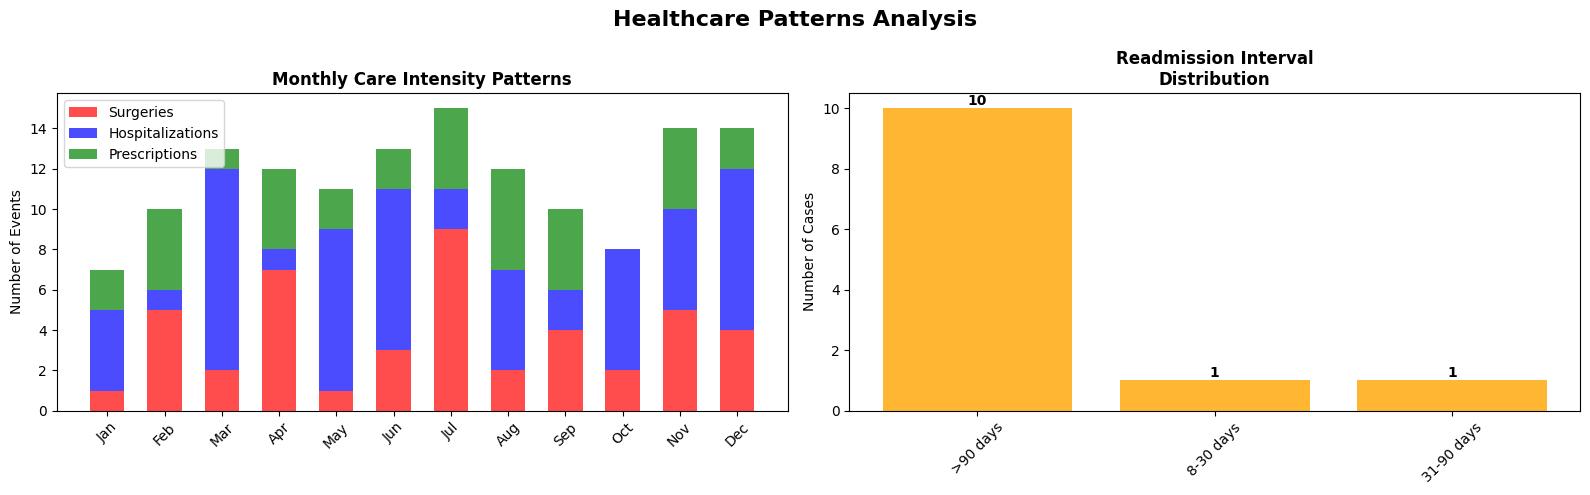

In [ ]:
#------------------------------------------------------------------------Healthcare Continuum Analyzer ---------------------------------------
print_dashed_heading("8: Pattern Analysis for Several Variables Together ")

class HealthcareContinuumAnalyzer:


    def __init__(self):
        self.cascade_patterns = []

    def analyze_hospitalization_readmission_prescription_changes(self):
        """Identify: Hospitalization → Readmission → Prescription Changes"""
        print_heading_3("1. HOSPITALIZATION → READMISSION → PRESCRIPTION CHANGES:")
        # Analysis tracks patients with multiple hospitalizations and examines prescription patterns between readmissions

        if hospital_patient.empty or drug_records.empty:
            print("   Insufficient data for hospitalization-prescription analysis")
            return None

        readmission_prescription_patterns = []

        # Get patients with multiple hospitalizations
        patient_admissions = hospital_patient.groupby('patient_id')['created_at'].apply(
            lambda x: pd.to_datetime(x).sort_values().tolist()
        )

        patients_with_readmissions = patient_admissions[patient_admissions.apply(len) > 1]

        for patient_id, admission_dates in patients_with_readmissions.items():
            for i in range(len(admission_dates) - 1):
                first_admission = admission_dates[i]
                second_admission = admission_dates[i + 1]
                readmission_interval = (second_admission - first_admission).days

                # Find prescriptions between admissions
                patient_prescriptions = drug_records[drug_records['patient_id'] == patient_id].copy()
                patient_prescriptions['created_at'] = pd.to_datetime(patient_prescriptions['created_at'])

                between_prescriptions = patient_prescriptions[
                    (patient_prescriptions['created_at'] > first_admission) &
                    (patient_prescriptions['created_at'] < second_admission)
                ]

                # Find prescriptions after second admission
                after_prescriptions = patient_prescriptions[
                    (patient_prescriptions['created_at'] > second_admission) &
                    (patient_prescriptions['created_at'] <= second_admission + pd.Timedelta(days=30))
                ]

                pattern = {
                    'patient_id': patient_id,
                    'readmission_interval_days': readmission_interval,
                    'prescriptions_between': len(between_prescriptions),
                    'prescriptions_after_readmission': len(after_prescriptions),
                    'prescription_change': len(after_prescriptions) > len(between_prescriptions)
                }

                readmission_prescription_patterns.append(pattern)

        if readmission_prescription_patterns:
            pattern_df = pd.DataFrame(readmission_prescription_patterns)

            print("   Readmission → Prescription Change Patterns:")
            print(f"     • Total readmission cases analyzed: {len(pattern_df)}")

            # Quick vs delayed readmissions
            quick_readmissions = pattern_df[pattern_df['readmission_interval_days'] <= 30]
            delayed_readmissions = pattern_df[pattern_df['readmission_interval_days'] > 30]

            print(f"     • Quick readmissions (≤30 days): {len(quick_readmissions)}")
            if not quick_readmissions.empty:
                avg_prescriptions_quick = quick_readmissions['prescriptions_after_readmission'].mean()
                print(f"       - Avg prescriptions after quick readmission: {avg_prescriptions_quick:.1f}")

            print(f"     • Delayed readmissions (>30 days): {len(delayed_readmissions)}")
            if not delayed_readmissions.empty:
                avg_prescriptions_delayed = delayed_readmissions['prescriptions_after_readmission'].mean()
                print(f"       - Avg prescriptions after delayed readmission: {avg_prescriptions_delayed:.1f}")

            # Prescription change frequency
            prescription_changes = pattern_df['prescription_change'].sum()
            change_percentage = (prescription_changes / len(pattern_df)) * 100
            print(f"     • Cases with prescription changes: {prescription_changes} ({change_percentage:.1f}%)")

        return readmission_prescription_patterns

    def analyze_monthly_care_intensity_patterns(self):
        """Identify months with simultaneous peaks in surgeries, hospitalizations, and prescriptions"""
        print_heading_3("2. MONTHLY CARE INTENSITY PATTERNS:")
        # Analysis examines monthly patterns across all care types to identify peak intensity periods

        monthly_intensity = {}

        # Get monthly counts for each care type
        for month in range(1, 13):
            intensity = {'month': month}

            # Surgery intensity
            if not surgeries.empty and 'month' in surgeries.columns:
                intensity['surgeries'] = len(surgeries[surgeries['month'] == month])
            else:
                intensity['surgeries'] = 0

            # Hospitalization intensity
            if not hospital_patient.empty and 'month' in hospital_patient.columns:
                intensity['hospitalizations'] = len(hospital_patient[hospital_patient['month'] == month])
            else:
                intensity['hospitalizations'] = 0

            # Prescription intensity
            if not drug_records.empty:
                drug_records_with_month = drug_records.copy()
                drug_records_with_month['created_at'] = pd.to_datetime(drug_records_with_month['created_at'])
                drug_records_with_month['month'] = drug_records_with_month['created_at'].dt.month
                intensity['prescriptions'] = len(drug_records_with_month[drug_records_with_month['month'] == month])
            else:
                intensity['prescriptions'] = 0

            # Calculate total intensity score
            intensity['total_score'] = intensity['surgeries'] + intensity['hospitalizations'] + intensity['prescriptions']

            monthly_intensity[month] = intensity

        print("   Monthly Care Intensity Patterns:")

        # Sort by total intensity
        sorted_months = sorted(monthly_intensity.items(), key=lambda x: x[1]['total_score'], reverse=True)

        month_names = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
                      7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

        print("     Highest Care Intensity Months:")
        for month_num, data in sorted_months[:6]:
            print(f"       • {month_names[month_num]}: {data['total_score']} total events")
            print(f"         - Surgeries: {data['surgeries']}, Hospitalizations: {data['hospitalizations']}, Prescriptions: {data['prescriptions']}")

        # Identify peak months for each category
        surgery_peak = max(monthly_intensity.items(), key=lambda x: x[1]['surgeries'])
        hospital_peak = max(monthly_intensity.items(), key=lambda x: x[1]['hospitalizations'])
        prescription_peak = max(monthly_intensity.items(), key=lambda x: x[1]['prescriptions'])

        print("     Peak Months by Category:")
        print(f"       • Surgery peak: {month_names[surgery_peak[0]]} ({surgery_peak[1]['surgeries']} surgeries)")
        print(f"       • Hospitalization peak: {month_names[hospital_peak[0]]} ({hospital_peak[1]['hospitalizations']} admissions)")
        print(f"       • Prescription peak: {month_names[prescription_peak[0]]} ({prescription_peak[1]['prescriptions']} prescriptions)")

        return monthly_intensity

# Initialize  analyzer
cascade_analyzer = HealthcareContinuumAnalyzer()

# Run  analyses
readmission_patterns = cascade_analyzer.analyze_hospitalization_readmission_prescription_changes()
monthly_intensity = cascade_analyzer.analyze_monthly_care_intensity_patterns()

# VISUALIZATION: Integrated Patterns
print_dashed_heading("Visualizations: ")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Healthcare Patterns Analysis', fontsize=16, fontweight='bold')

# 1. Monthly Care Intensity Patterns
if monthly_intensity:
    months = list(range(1, 13))
    surgeries_data = [monthly_intensity[m]['surgeries'] for m in months]
    hospitals_data = [monthly_intensity[m]['hospitalizations'] for m in months]
    prescriptions_data = [monthly_intensity[m]['prescriptions'] for m in months]

    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Stacked bar chart
    ax1 = axes[0]
    width = 0.6
    ax1.bar(month_labels, surgeries_data, width, label='Surgeries', color='red', alpha=0.7)
    ax1.bar(month_labels, hospitals_data, width, bottom=surgeries_data, label='Hospitalizations', color='blue', alpha=0.7)
    ax1.bar(month_labels, prescriptions_data, width,
           bottom=[s+h for s,h in zip(surgeries_data, hospitals_data)],
           label='Prescriptions', color='green', alpha=0.7)

    ax1.set_title('Monthly Care Intensity Patterns', fontweight='bold')
    ax1.set_ylabel('Number of Events')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

# 2. Readmission Interval Distribution
if readmission_patterns:
    readmit_df = pd.DataFrame(readmission_patterns)
    if not readmit_df.empty:
        ax2 = axes[1]
        intervals = readmit_df['readmission_interval_days']

        # Create categories
        interval_categories = []
        for interval in intervals:
            if interval <= 7:
                interval_categories.append('≤7 days')
            elif interval <= 30:
                interval_categories.append('8-30 days')
            elif interval <= 90:
                interval_categories.append('31-90 days')
            else:
                interval_categories.append('>90 days')

        interval_counts = Counter(interval_categories)
        categories = list(interval_counts.keys())
        counts = list(interval_counts.values())

        bars = ax2.bar(categories, counts, color='orange', alpha=0.8)
        ax2.set_title('Readmission Interval\nDistribution', fontweight='bold')
        ax2.set_ylabel('Number of Cases')
        ax2.tick_params(axis='x', rotation=45)

        for bar, count in zip(bars, counts):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# **Phase 3: Doctor Recommendation System**

Reloaded vitals from CSV.

      Vitals Data Cleaning - Intelligent Medical Correction 

Original dataset: 744 vital sign records
----------------------------------------

OXYGEN SATURATION CORRECTION:
-----------------------------
   • Normal range target: 95-100% (baseline: 98%)
   • Critical viable range: 70-94% (correction: 88%)
   • Data errors corrected to normal: 0
   • Critical but viable corrections: 0
   • Death cases preserved: 6

BLOOD GLUCOSE CORRECTION:
-------------------------
   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)
   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)
   • Data errors corrected to normal: 136
   • Critical but viable corrections: 2
   • Death cases preserved: 1

TEMPERATURE CORRECTION:
-----------------------
   • Normal range target: 36-38°C (baseline: 37°C)
   • Critical viable range: 34-36°C (correction: 35°C)
   • Data errors corrected to normal: 20
   • Critical but viable corrections: 0
   • Death cases preserved: 0


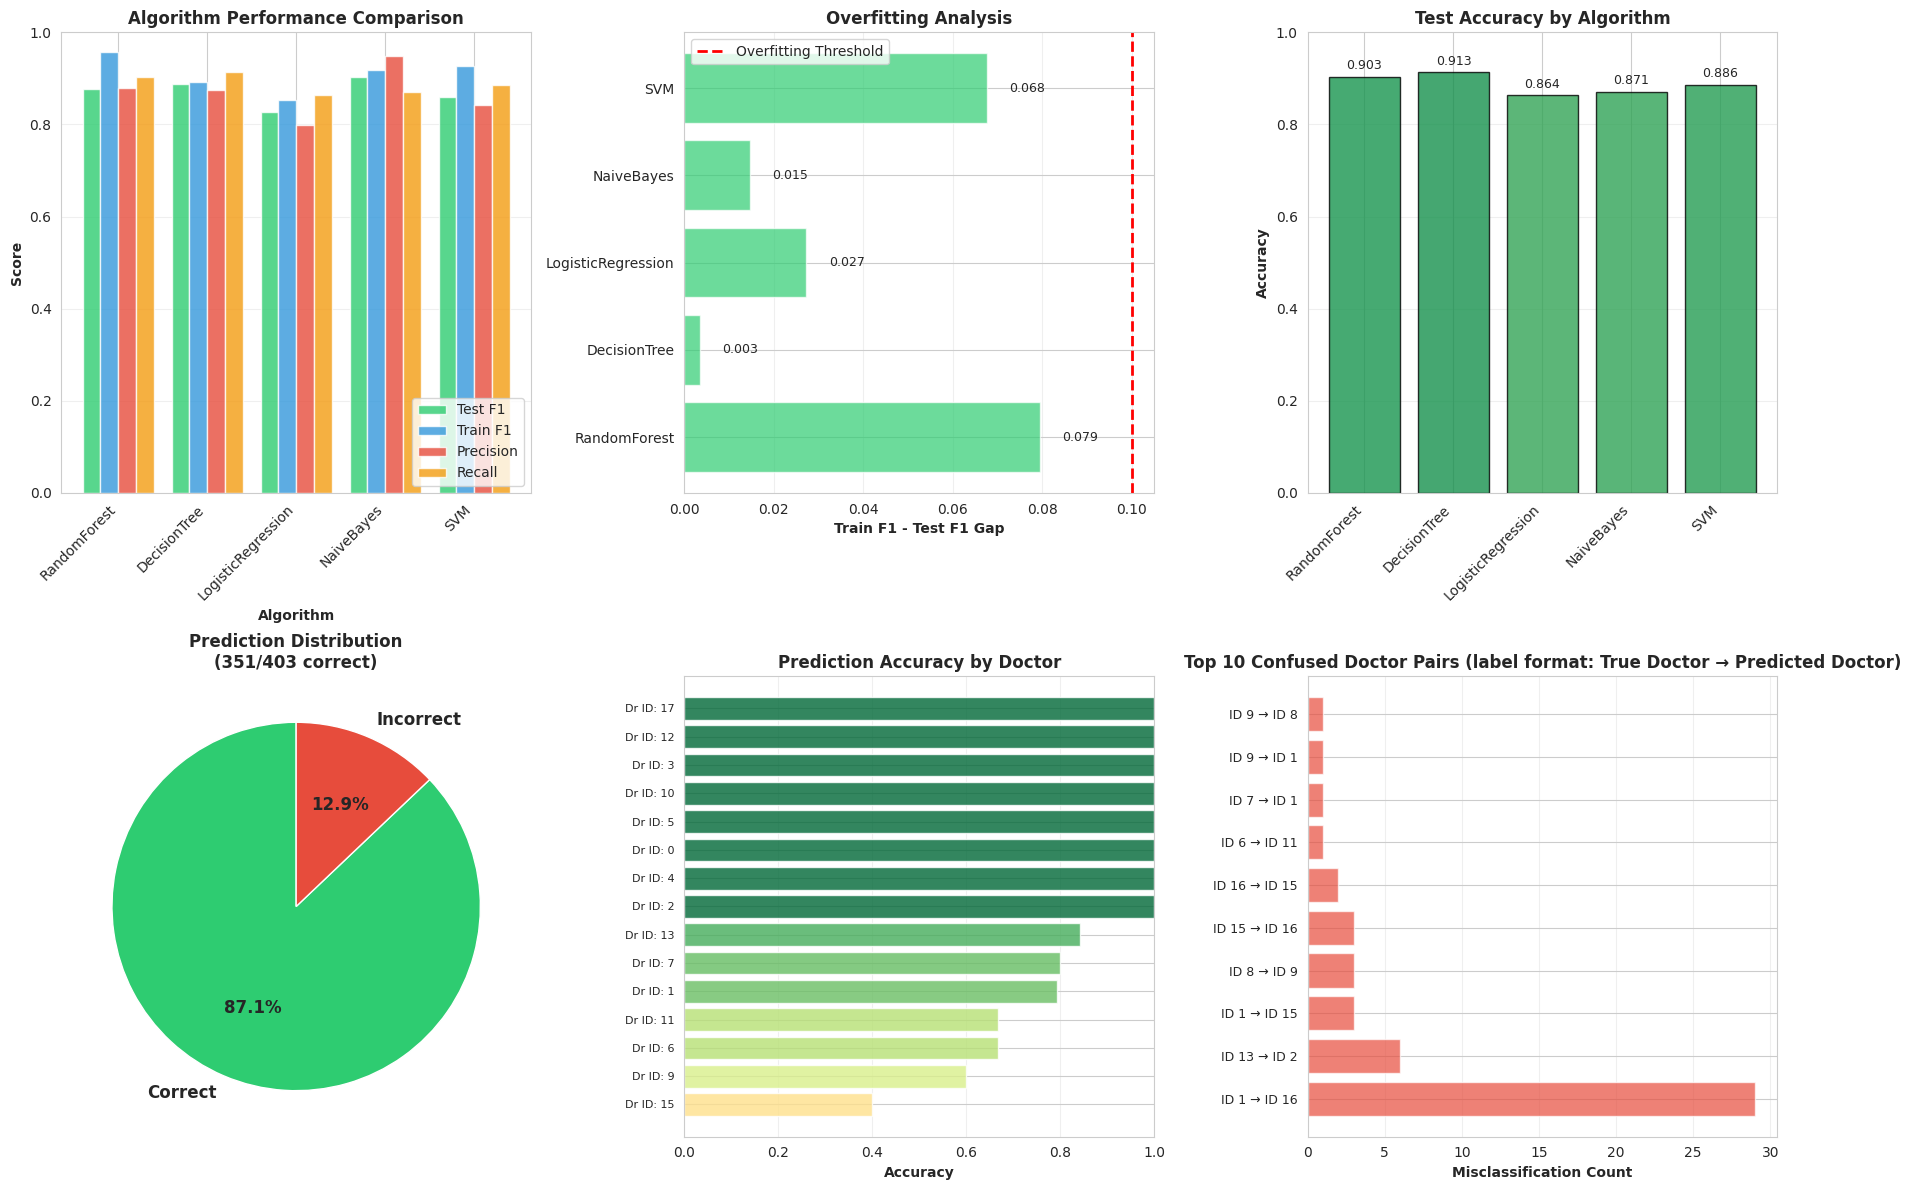



      Test Set Distribution by Doctor Plot 


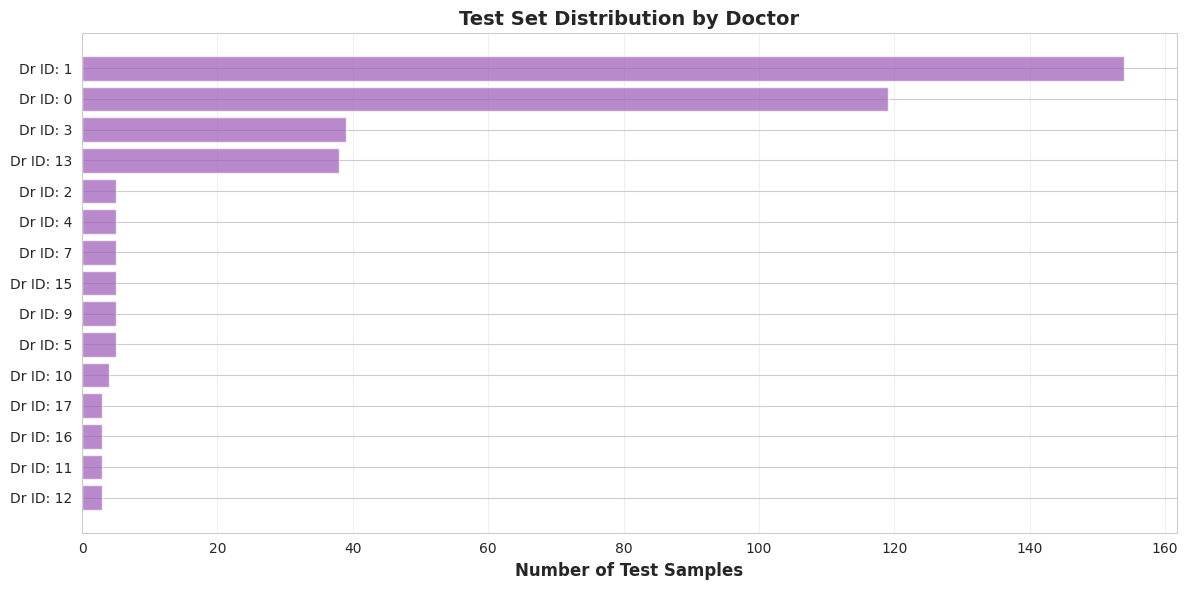


Feature importance not available for NaiveBayes
-----------------------------------------------

      TESTING SYSTEM ON 15 PATIENTS 

      RECOMMENDATION ANALYSIS - Patient ID: 8 
Patient: Lana Naboulsi
Vitals: BP 190/115, HR 110, T 37.0°C
       O2 95%, Glucose 140 mg/dL
EMERGENCY DETECTED: HYPERTENSIVE_CRISIS
   CRITICAL - IMMEDIATE ATTENTION REQUIRED


RECOMMENDATIONS:
----------------
1. Dr. Ahmad Khalil (Cardiology)
   Experience: 20 years
   Type: CRITICAL EMERGENCY
   Reasoning: Life-threatening hypertensive_crisis
   Confidence: 85.0%

      RECOMMENDATION ANALYSIS - Patient ID: 8 
Patient: Lana Naboulsi
Vitals: BP 120/80, HR 85, T 36.5°C
       O2 98%, Glucose 50 mg/dL
EMERGENCY DETECTED: HYPOGLYCEMIA
   CRITICAL - IMMEDIATE ATTENTION REQUIRED


RECOMMENDATIONS:
----------------
1. Dr. Fatima Saad (Endocrinology)
   Experience: 15 years
   Type: CRITICAL EMERGENCY
   Reasoning: Life-threatening hypoglycemia
   Confidence: 30.0%

      RECOMMENDATION ANALYSIS - Patient ID: 8

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

required_dataframes = ['patients', 'vitals', 'hospital_patient', 'medical_tests', 'surgeries', 'drug_patient', 'drugs', 'doctors', 'appointments',]
for df_name in required_dataframes:
    if df_name in globals() and not isinstance(globals()[df_name], pd.DataFrame):
        globals()[df_name] = pd.read_csv(f"/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/{df_name}.csv")
        print(f"Reloaded {df_name} from CSV.")
        #if it is the vitals one, clean it using clean_vitals_data(vitals)
        if df_name == 'vitals':
            vitals = clean_vitals_data(vitals)

class DoctorRecommendationSystem:
    def __init__(self):
        """
        Rule-based emergency detection + ML-based doctor ranking with proper regularization
        """
        # Regularized algorithms with overfitting prevention
        self.models = {
            'RandomForest': RandomForestClassifier(
                random_state=42,
                max_depth=8,  # Limit tree depth
                min_samples_split=10,  # Require more samples to split
                min_samples_leaf=5,    # Require more samples in leaves
                max_features='sqrt',   # Use subset of features
                n_estimators=50        # Fewer trees to prevent overfitting
            ),
            'DecisionTree': DecisionTreeClassifier(
                random_state=42,
                max_depth=6,           # Significantly limit depth
                min_samples_split=15,  # Require more samples to split
                min_samples_leaf=8,    # Require more samples in leaves
                ccp_alpha=0.01         # Post-pruning regularization
            ),
            'LogisticRegression': LogisticRegression(
                random_state=42,
                max_iter=1000,
                C=0.1,                 # Strong L2 regularization
                penalty='l2',          # L2 regularization
                solver='liblinear'
            ),
            'NaiveBayes': GaussianNB(
                var_smoothing=1e-5     # Increased smoothing to prevent overfitting
            ),
            'SVM': SVC(
                probability=True,
                random_state=42,
                C=0.5,                 # Reduced complexity
                gamma='scale',         # Automatic gamma scaling
                kernel='rbf'
            )
        }

        self.best_model = None
        self.best_model_name = None
        self.scaler = StandardScaler()
        self.doctor_encoder = LabelEncoder()

        # Clinical emergency thresholds (rule-based)
        self.emergency_thresholds = {
            'systolic_bp_critical': 180,
            'diastolic_bp_critical': 110,
            'temperature_critical': 38.5,
            'heart_rate_high': 100,
            'heart_rate_low': 50,
            'glucose_critical_high': 250,
            'glucose_critical_low': 70,
            'oxygen_critical': 90
        }

        # Emergency specialty mapping
        self.emergency_specialty_mapping = {
            'hypertensive_crisis': 'Cardiology',
            'hypoglycemia': 'Endocrinology',
            'hyperglycemia': 'Endocrinology',
            'fever': 'Internal Medicine',
            'arrhythmia': 'Cardiology',
            'hypoxemia': 'Internal Medicine'
        }

        # Drug-specialty mapping for relationship analysis
        self.drug_specialty_mapping = {
            'aspirin': 'Cardiology', 'bisoprolol': 'Cardiology', 'metoprolol': 'Cardiology',
            'concor': 'Cardiology', 'furosemide': 'Cardiology', 'lasix': 'Cardiology',
            'metformin': 'Endocrinology', 'insulin': 'Endocrinology',
            'escitalopram': 'Psychiatry', 'cipralex': 'Psychiatry',
            'amoxicillin': 'Internal Medicine', 'ibuprofen': 'Orthopedics'
        }

    def extract_bp_values(self, pressure_str):
        """Extract systolic and diastolic BP from string format"""
        try:
            if pd.isna(pressure_str) or pressure_str == '':
                return 120, 80
            parts = str(pressure_str).split('/')
            systolic = int(parts[0]) if len(parts) > 0 else 120
            diastolic = int(parts[1]) if len(parts) > 1 else 80
            return systolic, diastolic
        except:
            return 120, 80

    def detect_emergency_rule_based(self, vitals_dict):
        """
        Rule-based emergency detection - no ML needed
        Returns: (is_emergency, emergency_type, required_specialty, urgency_level)
        """
        emergencies = []

        # Blood pressure emergency
        if (vitals_dict['systolic_bp'] >= self.emergency_thresholds['systolic_bp_critical'] or
            vitals_dict['diastolic_bp'] >= self.emergency_thresholds['diastolic_bp_critical']):
            emergencies.append(('hypertensive_crisis', 'Cardiology', 10))

        # Glucose emergencies
        if vitals_dict['glucose'] <= self.emergency_thresholds['glucose_critical_low']:
            emergencies.append(('hypoglycemia', 'Endocrinology', 10))
        elif vitals_dict['glucose'] >= self.emergency_thresholds['glucose_critical_high']:
            emergencies.append(('hyperglycemia', 'Endocrinology', 9))

        # Temperature emergency
        if vitals_dict['temperature'] >= self.emergency_thresholds['temperature_critical']:
            emergencies.append(('fever', 'Internal Medicine', 8))

        # Heart rate emergency
        if (vitals_dict['heartbeat'] <= self.emergency_thresholds['heart_rate_low'] or
            vitals_dict['heartbeat'] >= self.emergency_thresholds['heart_rate_high']):
            emergencies.append(('arrhythmia', 'Cardiology', 8))

        # Oxygen emergency
        if vitals_dict['oxygen'] <= self.emergency_thresholds['oxygen_critical']:
            emergencies.append(('hypoxemia', 'Internal Medicine', 9))

        if emergencies:
            # Return highest priority emergency
            top_emergency = max(emergencies, key=lambda x: x[2])
            return True, top_emergency[0], top_emergency[1], top_emergency[2]

        return False, None, None, 0

    def expand_training_data_from_vitals(self):
        """
        Expand training data by using all vitals records instead of just recent ones
        This addresses the 79 samples limitation
        """
        print("Expanding training data using all vitals records...")

        expanded_samples = []

        # Get all patients with appointment history
        patients_with_appointments = appointments['patient_id'].unique()

        for patient_id in patients_with_appointments:
            # Get patient info
            patient_info = patients[patients['id'] == patient_id]
            if patient_info.empty:
                continue
            patient = patient_info.iloc[0]

            # Get all vitals for this patient
            patient_vitals = vitals[vitals['patient_id'] == patient_id].sort_values('created_at')

            # Get patient's appointment history to learn doctor preferences
            patient_appointments = appointments[appointments['patient_id'] == patient_id]

            # For each vital record, create training samples with each doctor they've seen
            for _, vital_row in patient_vitals.iterrows():
                systolic, diastolic = self.extract_bp_values(vital_row['pressure'])

                vitals_dict = {
                    'temperature': vital_row.get('temperature', 36.5),
                    'systolic_bp': systolic,
                    'diastolic_bp': diastolic,
                    'heartbeat': vital_row.get('heartbeat', 70),
                    'oxygen': vital_row.get('oxygen', 98),
                    'glucose': vital_row.get('glucose', 100)
                }

                # Create sample for each doctor this patient has seen
                for _, appointment in patient_appointments.iterrows():
                    doctor_info = doctors[doctors['id'] == appointment['doctor_id']]
                    if doctor_info.empty:
                        continue
                    doctor = doctor_info.iloc[0]

                    # Calculate relationship features
                    appointments_with_doctor = len(patient_appointments[
                        patient_appointments['doctor_id'] == appointment['doctor_id']])

                    # Surgery history with this doctor
                    surgery_history = len(surgeries[
                        (surgeries['patient_id'] == patient_id) &
                        (surgeries['doctor_id'] == appointment['doctor_id'])])

                    # Medication matching
                    drug_match = self.calculate_drug_specialty_match(patient_id, doctor['specialty'])

                    # Medical tests with this doctor
                    test_history = len(medical_tests[
                        (medical_tests['patient_id'] == patient_id) &
                        (medical_tests['doctor_id'] == appointment['doctor_id'])])

                    sample = {
                        'patient_id': patient_id,
                        'doctor_id': appointment['doctor_id'],
                        'age': patient['age'],
                        'gender_male': 1 if patient['gender'] == 'M' else 0,
                        'doctor_experience': doctor['years_of_experience'],
                        'temperature': vitals_dict['temperature'],
                        'systolic_bp': vitals_dict['systolic_bp'],
                        'diastolic_bp': vitals_dict['diastolic_bp'],
                        'heartbeat': vitals_dict['heartbeat'],
                        'oxygen': vitals_dict['oxygen'],
                        'glucose': vitals_dict['glucose'],
                        'appointments_with_doctor': appointments_with_doctor,
                        'surgery_history_with_doctor': surgery_history,
                        'medication_specialty_match': drug_match,
                        'test_history_with_doctor': test_history,
                        'doctor_specialty': doctor['specialty']
                    }
                    expanded_samples.append(sample)

        expanded_df = pd.DataFrame(expanded_samples)
        print(f"Expanded training data: {len(expanded_df)} samples (vs previous 79)")
        return expanded_df

    def filter_doctors_with_sufficient_samples(self, df, min_samples=2):
        """Filter out doctors with too few samples for proper cross-validation"""
        doctor_counts = df['doctor_id'].value_counts()
        valid_doctors = doctor_counts[doctor_counts >= min_samples].index
        filtered_df = df[df['doctor_id'].isin(valid_doctors)]

        removed_doctors = len(doctor_counts) - len(valid_doctors)
        if removed_doctors > 0:
            print(f"Filtered out {removed_doctors} doctors with fewer than {min_samples} samples")
            print(f"Remaining doctors: {len(valid_doctors)}")

        return filtered_df

    def calculate_drug_specialty_match(self, patient_id, doctor_specialty):
        """Calculate if patient's medications match doctor's specialty"""
        try:
            patient_drugs = drug_patient[drug_patient['patient_id'] == patient_id]
            if patient_drugs.empty:
                return 0

            drug_ids = patient_drugs['drug_id'].tolist()
            if not isinstance(drugs, pd.DataFrame) or drugs.empty:
                return 0

            patient_drug_names = drugs[drugs['id'].isin(drug_ids)]['name'].tolist()

            for drug_name in patient_drug_names:
                if pd.notna(drug_name):
                    drug_lower = str(drug_name).lower()
                    for drug_key, specialty in self.drug_specialty_mapping.items():
                        if drug_key in drug_lower and specialty == doctor_specialty:
                            return 1
            return 0
        except:
            return 0

    def comprehensive_algorithm_evaluation(self, X, y):
        """
        Compare all candidate algorithms with proper validation to prevent overfitting
        """
        print_dashed_heading("COMPREHENSIVE ALGORITHM COMPARISON")

        # Stratified split to maintain class distribution
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Check class distribution for cross-validation
        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        min_class_count = min(class_counts)

        # Use appropriate cross-validation strategy
        if min_class_count >= 5:
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            print(f"Using 5-fold stratified cross-validation (min class count: {min_class_count})")
        elif min_class_count >= 3:
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            print(f"Using 3-fold stratified cross-validation (min class count: {min_class_count})")
        else:
            cv = 3  # Simple k-fold when stratified is not possible
            print(f"Using simple 3-fold cross-validation (min class count: {min_class_count})")

        results = {}

        for name, model in self.models.items():
            print(f"Evaluating {name}...")

            # Simplified parameter grids to prevent overfitting
            if name == 'RandomForest':
                param_grid = {
                    'max_depth': [6, 8, 10],
                    'min_samples_split': [10, 15],
                    'min_samples_leaf': [5, 8]
                }
            elif name == 'DecisionTree':
                param_grid = {
                    'max_depth': [4, 6, 8],
                    'min_samples_split': [15, 20],
                    'ccp_alpha': [0.01, 0.02]
                }
            elif name == 'LogisticRegression':
                param_grid = {
                    'C': [0.01, 0.1, 0.5],
                    'penalty': ['l2']
                }
            elif name == 'NaiveBayes':
                param_grid = {
                    'var_smoothing': [1e-6, 1e-5, 1e-4]
                }
            elif name == 'SVM':
                param_grid = {
                    'C': [0.1, 0.5, 1.0],
                    'gamma': ['scale', 'auto']
                }

            try:
                # Grid search with appropriate cross-validation
                grid_search = GridSearchCV(
                    model, param_grid, cv=cv, scoring='f1_weighted',
                    n_jobs=-1, verbose=0
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
            except Exception as e:
                print(f"Grid search failed for {name}: {e}")
                best_model = model
                best_model.fit(X_train, y_train)
                best_params = "Default"

            # Make predictions
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            # Cross-validation scores
            try:
                cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1_weighted')
            except:
                cv_scores = np.array([f1])

            # Calculate train score to detect overfitting
            train_pred = best_model.predict(X_train)
            train_f1 = f1_score(y_train, train_pred, average='weighted', zero_division=0)
            overfitting_gap = train_f1 - f1

            results[name] = {
                'model': best_model,
                'best_params': best_params,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'train_f1': train_f1,
                'overfitting_gap': overfitting_gap,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"  Best Params: {best_params}")
            print(f"  Train F1: {train_f1:.4f}")
            print(f"  Test F1: {f1:.4f}")
            print(f"  Overfitting Gap: {overfitting_gap:.4f}")
            print(f"  CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
            print()

        return results

    def plot_evaluation_results(self, results):
        """
        Create comprehensive visualizations for algorithm comparison and performance
        """
        print_dashed_heading("EVALUATION PLOTS")

        # Set style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = (15, 12)

        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))

        # 1. ALGORITHM COMPARISON - Performance Metrics
        ax1 = plt.subplot(2, 3, 1)
        algorithms = list(results.keys())
        metrics = {
            'Test F1': [results[alg]['f1_score'] for alg in algorithms],
            'Train F1': [results[alg]['train_f1'] for alg in algorithms],
            'Precision': [results[alg]['precision'] for alg in algorithms],
            'Recall': [results[alg]['recall'] for alg in algorithms]
        }

        x = np.arange(len(algorithms))
        width = 0.2
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

        for i, (metric, values) in enumerate(metrics.items()):
            ax1.bar(x + i*width, values, width, label=metric, color=colors[i], alpha=0.8)

        ax1.set_xlabel('Algorithm', fontweight='bold')
        ax1.set_ylabel('Score', fontweight='bold')
        ax1.set_title('Algorithm Performance Comparison', fontweight='bold', fontsize=12)
        ax1.set_xticks(x + width * 1.5)
        ax1.set_xticklabels(algorithms, rotation=45, ha='right')
        ax1.legend(loc='lower right')
        ax1.set_ylim([0, 1.0])
        ax1.grid(axis='y', alpha=0.3)

        # 2. OVERFITTING ANALYSIS
        ax2 = plt.subplot(2, 3, 2)
        overfitting_gaps = [results[alg]['overfitting_gap'] for alg in algorithms]
        colors_overfit = ['#e74c3c' if gap > 0.1 else '#2ecc71' for gap in overfitting_gaps]

        bars = ax2.barh(algorithms, overfitting_gaps, color=colors_overfit, alpha=0.7)
        ax2.axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='Overfitting Threshold')
        ax2.set_xlabel('Train F1 - Test F1 Gap', fontweight='bold')
        ax2.set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
        ax2.legend()
        ax2.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, overfitting_gaps)):
            ax2.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=9)

        # 3. ACCURACY BY ALGORITHM
        ax3 = plt.subplot(2, 3, 3)
        accuracies = [results[alg]['accuracy'] for alg in algorithms]
        colors_acc = plt.cm.RdYlGn(np.array(accuracies))

        bars = ax3.bar(algorithms, accuracies, color=colors_acc, alpha=0.8, edgecolor='black')
        ax3.set_ylabel('Accuracy', fontweight='bold')
        ax3.set_title('Test Accuracy by Algorithm', fontweight='bold', fontsize=12)
        ax3.set_xticklabels(algorithms, rotation=45, ha='right')
        ax3.set_ylim([0, 1.0])
        ax3.grid(axis='y', alpha=0.3)

        # Add value labels
        for bar, val in zip(bars, accuracies):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)

        # 4. PREDICTION ERRORS DISTRIBUTION
        ax4 = plt.subplot(2, 3, 4)
        best_result = results[self.best_model_name]
        y_test = best_result['y_test']
        y_pred = best_result['y_pred']
        correct_predictions = (y_test == y_pred)
        correct_count = np.sum(correct_predictions)
        incorrect_count = len(y_test) - correct_count

        wedges, texts, autotexts = ax4.pie([correct_count, incorrect_count],
                                            labels=['Correct', 'Incorrect'],
                                            autopct='%1.1f%%',
                                            colors=['#2ecc71', '#e74c3c'],
                                            startangle=90,
                                            textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax4.set_title(f'Prediction Distribution\n({correct_count}/{len(y_test)} correct)',
                      fontweight='bold', fontsize=12)

        # 5. PREDICTION ACCURACY BY DOCTOR
        ax5 = plt.subplot(2, 3, 5)
        unique_classes = np.unique(y_test)
        accuracies_by_class = []

        for cls in unique_classes:
            mask = y_test == cls
            if np.sum(mask) > 0:
                accuracy = np.mean(y_test[mask] == y_pred[mask])
                accuracies_by_class.append(accuracy)
            else:
                accuracies_by_class.append(0)

        # Limit to top 15 doctors for readability
        if len(unique_classes) > 15:
            top_indices = np.argsort(accuracies_by_class)[-15:]
            unique_classes = unique_classes[top_indices]
            accuracies_by_class = [accuracies_by_class[i] for i in top_indices]

        colors = plt.cm.RdYlGn(np.array(accuracies_by_class))
        bars = ax5.barh(range(len(unique_classes)), accuracies_by_class, color=colors, alpha=0.8)
        ax5.set_yticks(range(len(unique_classes)))
        ax5.set_yticklabels([f'Dr ID: {cls}' for cls in unique_classes], fontsize=8)
        ax5.set_xlabel('Accuracy', fontweight='bold')
        ax5.set_title('Prediction Accuracy by Doctor', fontweight='bold', fontsize=12)
        ax5.set_xlim([0, 1.0])
        ax5.grid(axis='x', alpha=0.3)

        # 6. TOP CONFUSED DOCTOR PAIRS
        ax6 = plt.subplot(2, 3, 6)
        cm = confusion_matrix(y_test, y_pred)
        np.fill_diagonal(cm, 0)  # Remove correct predictions

        # Find top confused pairs
        confused_pairs = []
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    confused_pairs.append((i, j, cm[i, j]))

        confused_pairs = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:10]

        if confused_pairs:
            # Get actual doctor IDs from indices
            unique_doctors = np.unique(np.concatenate([y_test, y_pred]))
            pair_labels = [f'ID {unique_doctors[true]} → ID {unique_doctors[pred]}'
                          for true, pred, _ in confused_pairs]
            pair_counts = [count for _, _, count in confused_pairs]

            ax6.barh(range(len(pair_labels)), pair_counts, color='#e74c3c', alpha=0.7)
            ax6.set_yticks(range(len(pair_labels)))
            ax6.set_yticklabels(pair_labels, fontsize=9)
            ax6.set_xlabel('Misclassification Count', fontweight='bold')
            ax6.set_title('Top 10 Confused Doctor Pairs (label format: True Doctor → Predicted Doctor)', fontweight='bold', fontsize=12)
            ax6.grid(axis='x', alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'No misclassifications', ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()
        print()


    def plot_prediction_analysis(self, best_result):
        """
        Create detailed prediction vs actual analysis plots
        """
        print_dashed_heading("Test Set Distribution by Doctor Plot")

        fig = plt.figure(figsize=(12, 6))

        y_test = best_result['y_test']
        y_pred = best_result['y_pred']

        # SAMPLE SIZE PER DOCTOR
        ax1 = plt.subplot(1, 1, 1)
        unique, counts = np.unique(y_test, return_counts=True)

        # Limit to top 15 doctors
        if len(unique) > 15:
            top_indices = np.argsort(counts)[-15:]
            unique = unique[top_indices]
            counts = counts[top_indices]

        ax1.barh(range(len(unique)), counts, color='#9b59b6', alpha=0.7)
        ax1.set_yticks(range(len(unique)))
        ax1.set_yticklabels([f'Dr ID: {cls}' for cls in unique], fontsize=10)
        ax1.set_xlabel('Number of Test Samples', fontweight='bold', fontsize=12)
        ax1.set_title('Test Set Distribution by Doctor', fontweight='bold', fontsize=14)
        ax1.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

    def select_best_model(self, results):
        """Select the best performing model considering overfitting"""
        print_dashed_heading("ALGORITHM PERFORMANCE RANKING")

        # Create comparison table
        comparison_data = []
        for name, result in results.items():
            comparison_data.append({
                'Algorithm': name,
                'Test_F1': result['f1_score'],
                'Train_F1': result['train_f1'],
                'Overfitting_Gap': result['overfitting_gap'],
                'CV_Mean': result['cv_mean'],
                'CV_Std': result['cv_std']
            })

        comparison_df = pd.DataFrame(comparison_data)

        # Penalize models with high overfitting gap
        comparison_df['Adjusted_Score'] = (
            comparison_df['Test_F1'] -
            0.5 * comparison_df['Overfitting_Gap'] -
            0.2 * comparison_df['CV_Std']
        )

        comparison_df = comparison_df.sort_values('Adjusted_Score', ascending=False)

        print(comparison_df.to_string(index=False, float_format='%.4f'))

        # Select best model based on adjusted score
        best_algorithm = comparison_df.iloc[0]['Algorithm']
        self.best_model_name = best_algorithm
        self.best_model = results[best_algorithm]['model']

        print(f"\nSELECTED BEST MODEL: {best_algorithm}")
        print(f"Test F1-Score: {results[best_algorithm]['f1_score']:.4f}")
        print(f"Overfitting Gap: {results[best_algorithm]['overfitting_gap']:.4f}")
        print(f"Cross-Validation: {results[best_algorithm]['cv_mean']:.4f} (±{results[best_algorithm]['cv_std']:.4f})")

        return results[best_algorithm]

    def analyze_feature_importance(self, feature_names, best_result):
        """Analyze feature importance for interpretability"""
        if hasattr(self.best_model, 'feature_importances_'):
            print_heading_3(f"\nFEATURE IMPORTANCE ANALYSIS ({self.best_model_name})")

            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': self.best_model.feature_importances_
            }).sort_values('Importance', ascending=False)

            print("Top Features for Doctor Selection:")
            for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
                print(f"{i+1:2d}. {row['Feature']:<30}: {row['Importance']:.4f}")

            return importance_df
        else:
            print_heading_3(f"Feature importance not available for {self.best_model_name}")
            return None

    def train_doctor_ranking_model(self):
        """
        Train the ML model focused purely on doctor-patient relationships
        Emergency detection is handled by rules, not ML
        """
        print_dashed_heading("DOCTOR RECOMMENDATION SYSTEM TRAINING")
        print("Architecture: Rule-based Emergency + ML-based Doctor Ranking")
        print()

        # Expand training data using all vitals records
        expanded_training_data = self.expand_training_data_from_vitals()

        # Filter doctors with insufficient samples
        filtered_training_data = self.filter_doctors_with_sufficient_samples(expanded_training_data, min_samples=2)

        # Prepare features for ML model (focused on relationships, not emergency detection)
        feature_columns = [
            'age', 'gender_male', 'doctor_experience',
            'appointments_with_doctor', 'surgery_history_with_doctor',
            'medication_specialty_match', 'test_history_with_doctor',
            # Vitals included for context but emergency detection handled by rules
            'temperature', 'systolic_bp', 'diastolic_bp', 'heartbeat', 'oxygen', 'glucose'
        ]

        X = filtered_training_data[feature_columns]
        y = self.doctor_encoder.fit_transform(filtered_training_data['doctor_id'])

        # Conservative feature scaling to prevent overfitting
        X_scaled = self.scaler.fit_transform(X)

        print(f"Training dataset: {X_scaled.shape[0]} samples, {X_scaled.shape[1]} features")
        print(f"Doctor classes: {len(np.unique(y))}")
        print()

        # Comprehensive algorithm evaluation
        results = self.comprehensive_algorithm_evaluation(X_scaled, y)

        # Select best model
        best_result = self.select_best_model(results)
        self.plot_evaluation_results(results)
        self.plot_prediction_analysis(best_result)
        # Feature importance analysis
        importance_df = self.analyze_feature_importance(feature_columns, best_result)

        return best_result, importance_df

    def get_recommendations(self, patient_id, current_vitals, requested_specialty=None, top_k=3):
        """
        Generate recommendations:
        1. Emergency (if detected by rules)
        2. Requested specialty (if available)
        3. History-based (ML model)
        """
        print_dashed_heading(f"RECOMMENDATION ANALYSIS - Patient ID: {patient_id}")

        # Get patient info
        patient_info = patients[patients['id'] == patient_id]
        if patient_info.empty:
            return []
        patient = patient_info.iloc[0]

        # Parse vitals
        systolic, diastolic = self.extract_bp_values(current_vitals.get('pressure', '120/80'))
        vitals_dict = {
            'temperature': float(current_vitals.get('temperature', 36.5)),
            'systolic_bp': systolic,
            'diastolic_bp': diastolic,
            'heartbeat': int(current_vitals.get('heartbeat', 70)),
            'oxygen': int(current_vitals.get('oxygen', 98)),
            'glucose': int(current_vitals.get('glucose', 100))
        }

        print(f"Patient: {patient['first_name']} {patient['last_name']}")
        print(f"Vitals: BP {systolic}/{diastolic}, HR {vitals_dict['heartbeat']}, T {vitals_dict['temperature']}°C")
        print(f"       O2 {vitals_dict['oxygen']}%, Glucose {vitals_dict['glucose']} mg/dL")

        # 1. RULE-BASED EMERGENCY DETECTION
        is_emergency, emergency_type, emergency_specialty, urgency_level = self.detect_emergency_rule_based(vitals_dict)

        if is_emergency:
            print(f"EMERGENCY DETECTED: {emergency_type.upper()}")

            # CRITICAL: For life-threatening emergencies, return single doctor immediately
            if urgency_level >= 10:
                emergency_doctors = doctors[doctors['specialty'] == emergency_specialty]
                if not emergency_doctors.empty:
                    best_emergency = self.get_best_doctor_in_specialty(
                        patient_id, emergency_specialty, vitals_dict, patient)
                    if best_emergency:
                        print(f"   CRITICAL - IMMEDIATE ATTENTION REQUIRED")
                        print()
                        print_heading_3("RECOMMENDATIONS:")
                        print(f"1. Dr. {best_emergency['name']} ({best_emergency['specialty']})")
                        print(f"   Experience: {best_emergency['experience']} years")
                        print(f"   Type: CRITICAL EMERGENCY")
                        print(f"   Reasoning: Life-threatening {emergency_type}")
                        print(f"   Confidence: {best_emergency['confidence']:.1f}%")
                        return [{
                            'rank': 1,
                            'type': 'CRITICAL EMERGENCY',
                            'doctor': best_emergency,
                            'reasoning': f'Life-threatening {emergency_type}'
                        }]
            print(f"   Required Specialty: {emergency_specialty}")
            print(f"   Urgency Level: {urgency_level}/10")
            if requested_specialty and requested_specialty != emergency_specialty:
                print(f"   OVERRIDE: Emergency overrides requested {requested_specialty}")
        elif requested_specialty:
            print(f"Requested Specialty: {requested_specialty}")
        print()

        recommendations = []
        used_doctors = set()

        # 2. RECOMMENDATION 1: Emergency Doctor (if emergency)
        if is_emergency:
            emergency_doctors = doctors[doctors['specialty'] == emergency_specialty]
            if not emergency_doctors.empty:
                # Get best emergency doctor using ML model
                best_emergency_doctor = self.get_best_doctor_in_specialty(
                    patient_id, emergency_specialty, vitals_dict, patient)
                if best_emergency_doctor:
                    recommendations.append({
                        'rank': 1,
                        'type': 'Emergency',
                        'doctor': best_emergency_doctor,
                        'reasoning': f'Emergency {emergency_type} requires {emergency_specialty}'
                    })
                    used_doctors.add(best_emergency_doctor['doctor_id'])

        # 3. RECOMMENDATION 2: Requested Specialty (if available and different)
        if requested_specialty:
            specialty_doctors = doctors[doctors['specialty'] == requested_specialty]
            if specialty_doctors.empty:
                print(f"No doctors available with specialty: {requested_specialty}")
            elif not is_emergency or requested_specialty != emergency_specialty:
                best_specialty_doctor = self.get_best_doctor_in_specialty(
                    patient_id, requested_specialty, vitals_dict, patient)
                if best_specialty_doctor and best_specialty_doctor['doctor_id'] not in used_doctors:
                    recommendations.append({
                        'rank': 2 if is_emergency else 1,
                        'type': 'Requested Specialty',
                        'doctor': best_specialty_doctor,
                        'reasoning': f'Requested {requested_specialty} specialty'
                    })
                    used_doctors.add(best_specialty_doctor['doctor_id'])

        # 4. RECOMMENDATION 3: History-based (ML model)
        history_doctor = self.get_best_doctor_by_history(patient_id, vitals_dict, patient, used_doctors)
        if history_doctor:
            recommendations.append({
                'rank': len(recommendations) + 1,
                'type': 'History-Based',
                'doctor': history_doctor,
                'reasoning': 'Based on appointment history and patient profile'
            })

        # Display recommendations
        print_heading_3("RECOMMENDATIONS:")
        for rec in recommendations[:top_k]:
            dr = rec['doctor']
            print(f"{rec['rank']}. Dr. {dr['name']} ({dr['specialty']})")
            print(f"   Experience: {dr['experience']} years")
            print(f"   Type: {rec['type']}")
            print(f"   Reasoning: {rec['reasoning']}")
            if 'confidence' in dr:
                print(f"   Confidence: {dr['confidence']:.1f}%")
            print()

        return recommendations

    def get_best_doctor_in_specialty(self, patient_id, specialty, vitals_dict, patient):
        """Use ML model to find best doctor within a specific specialty"""
        specialty_doctors = doctors[doctors['specialty'] == specialty]
        if specialty_doctors.empty:
            return None

        best_doctor = None
        best_score = -1

        for _, doctor in specialty_doctors.iterrows():
            score = self.calculate_doctor_score(patient_id, doctor, vitals_dict, patient)
            if score > best_score:
                best_score = score
                best_doctor = {
                    'doctor_id': doctor['id'],
                    'name': f"{doctor['first_name']} {doctor['last_name']}",
                    'specialty': doctor['specialty'],
                    'experience': doctor['years_of_experience'],
                    'confidence': min(95.0, max(15.0, score * 100))  # Cap confidence to realistic range
                }

        return best_doctor

    def get_best_doctor_by_history(self, patient_id, vitals_dict, patient, exclude_doctors):
        """Use ML model to find best doctor based on patient history"""
        available_doctors = doctors[~doctors['id'].isin(exclude_doctors)]
        if available_doctors.empty:
            return None

        best_doctor = None
        best_score = -1

        for _, doctor in available_doctors.iterrows():
            score = self.calculate_doctor_score(patient_id, doctor, vitals_dict, patient)
            if score > best_score:
                best_score = score
                best_doctor = {
                    'doctor_id': doctor['id'],
                    'name': f"{doctor['first_name']} {doctor['last_name']}",
                    'specialty': doctor['specialty'],
                    'experience': doctor['years_of_experience'],
                    'confidence': min(95.0, max(15.0, score * 100))  # Cap confidence to realistic range
                }

        return best_doctor

    def calculate_doctor_score(self, patient_id, doctor, vitals_dict, patient):
        """Calculate doctor score using trained ML model with realistic confidence"""
        try:
            # Calculate relationship features
            appointments_with_doctor = len(appointments[
                (appointments['patient_id'] == patient_id) &
                (appointments['doctor_id'] == doctor['id'])])

            surgery_history = len(surgeries[
                (surgeries['patient_id'] == patient_id) &
                (surgeries['doctor_id'] == doctor['id'])])

            medication_match = self.calculate_drug_specialty_match(patient_id, doctor['specialty'])

            test_history = len(medical_tests[
                (medical_tests['patient_id'] == patient_id) &
                (medical_tests['doctor_id'] == doctor['id'])])

            # Prepare feature vector
            feature_vector = [
                patient['age'],
                1 if patient['gender'] == 'M' else 0,
                doctor['years_of_experience'],
                appointments_with_doctor,
                surgery_history,
                medication_match,
                test_history,
                vitals_dict['temperature'],
                vitals_dict['systolic_bp'],
                vitals_dict['diastolic_bp'],
                vitals_dict['heartbeat'],
                vitals_dict['oxygen'],
                vitals_dict['glucose']
            ]

            # Scale and predict
            feature_scaled = self.scaler.transform([feature_vector])

            if hasattr(self.best_model, 'predict_proba'):
              probabilities = self.best_model.predict_proba(feature_scaled)[0]
              try:
                  doctor_encoded = self.doctor_encoder.transform([doctor['id']])[0]
                  raw_prob = probabilities[doctor_encoded]

                  # Adjust based on relationship history only
                  appointments_count = len(appointments[
                      (appointments['patient_id'] == patient_id) &
                      (appointments['doctor_id'] == doctor['id'])])

                  if appointments_count >= 3:
                      raw_prob = min(0.95, raw_prob + 0.10)
                  elif appointments_count == 0:
                      raw_prob = max(0.30, raw_prob - 0.15)

                  return max(0.30, min(0.95, raw_prob))
              except:
                  return 0.50
            else:
              prediction = self.best_model.predict(feature_scaled)[0]
              base_score = 0.80 if prediction == doctor['id'] else 0.35
              return base_score

        except Exception as e:
          # Fallback scoring based on relationships only
          relationship_score = min(appointments_with_doctor * 0.20 + surgery_history * 0.25, 0.65)
          experience_score = min(doctor['years_of_experience'] / 25, 0.35)
          base_score = (relationship_score + experience_score) / 2.0
          return max(0.30, min(0.90, base_score))

    def test_multiple_patients(self, test_count=20):
        """Test system on multiple patients with various scenarios"""
        print_dashed_heading(f"TESTING SYSTEM ON {test_count} PATIENTS")

        # Get random patients
        test_patients = np.random.choice(patients['id'].unique(), min(test_count, len(patients)), replace=False)

        test_scenarios = [
            # Emergency scenarios
            {'pressure': '190/115', 'heartbeat': 110, 'temperature': 37.0, 'oxygen': 95, 'glucose': 140, 'name': 'Hypertensive Crisis'},
            {'pressure': '120/80', 'heartbeat': 85, 'temperature': 36.5, 'oxygen': 98, 'glucose': 50, 'name': 'Hypoglycemia'},
            {'pressure': '115/75', 'heartbeat': 95, 'temperature': 39.0, 'oxygen': 96, 'glucose': 110, 'name': 'High Fever'},
            # Normal scenarios
            {'pressure': '125/85', 'heartbeat': 78, 'temperature': 36.8, 'oxygen': 98, 'glucose': 105, 'name': 'Normal'},
            {'pressure': '130/90', 'heartbeat': 82, 'temperature': 37.2, 'oxygen': 97, 'glucose': 130, 'name': 'Mild Hypertension'},
        ]

        results = []
        for patient_id in test_patients:
            for scenario in test_scenarios:
                recommendations = self.get_recommendations(
                    patient_id=patient_id,
                    current_vitals=scenario,
                    requested_specialty='Internal Medicine'
                )
                emergency_detected = any(r['type'] in ['Emergency', 'CRITICAL EMERGENCY'] for r in recommendations)
                results.append({
                    'patient_id': patient_id,
                    'scenario': scenario['name'],
                    'emergency_detected': any(r['type'] in ['Emergency', 'CRITICAL EMERGENCY'] for r in recommendations),
                    'confidence_scores': [r['doctor'].get('confidence', 0) for r in recommendations],
                    'specialties': [r['doctor']['specialty'] for r in recommendations]
                })

        # Analyze results
        # Analyze results
        emergency_scenarios = ['Hypertensive Crisis', 'Hypoglycemia', 'High Fever']
        emergency_results = [r for r in results if r['scenario'] in emergency_scenarios]
        normal_results = [r for r in results if r['scenario'] not in emergency_scenarios]

        print(f"Emergency Detection Rate: {sum([r['emergency_detected'] for r in emergency_results])}/{len(emergency_results)}")
        print(f"False Emergency Rate: {sum([r['emergency_detected'] for r in normal_results])}/{len(normal_results)}")

        all_confidences = [conf for r in results for conf in r['confidence_scores']]
        print(f"Confidence Score Range: {min(all_confidences):.2f} - {max(all_confidences):.2f}")
        print(f"Average Confidence: {np.mean(all_confidences):.2f}")

        return results

# Initialize and train the system
system = DoctorRecommendationSystem()
training_results, feature_importance = system.train_doctor_ranking_model()

# Test the system comprehensively
test_results = system.test_multiple_patients(test_count=15)

# Test specific edge cases

print_header("EDGE CASE TESTING (Testing the model with different cases)")

edge_cases = [
    (1, {'pressure': '200/120', 'heartbeat': 120, 'temperature': 38.8, 'oxygen': 88, 'glucose': 300}, 'Multiple emergencies'),
    (5, {'pressure': '90/60', 'heartbeat': 45, 'temperature': 35.5, 'oxygen': 85, 'glucose': 40}, 'Multiple critical lows'),
    (12, {'pressure': '125/80', 'heartbeat': 72, 'temperature': 36.5, 'oxygen': 98, 'glucose': 95}, 'Completely normal')
]

for i, (patient_id, vitals, description) in enumerate(edge_cases):
    print_dashed_heading(f"EDGE CASE {i+1}: {description.upper()}")
    recommendations = system.get_recommendations(
        patient_id=patient_id,
        current_vitals=vitals,
        requested_specialty='Cardiology'
    )

print()
print_header("Doctor Recommendation System - Implementation Complete")
print_heading_3("Key Features:")
print("-  Rule-based emergency detection (no ML confusion)")
print("-  Three-tier recommendation system:")
print("   - Emergency (rule-based override)")
print("   - Requested specialty (if available)")
print("   - History-based (ML-powered)")
print("-  Handles 'No doctors available' for requested specialties")

# **Phase 3:Patient clustering by diagnosis and care needs**


                          CLINICAL RISK-BASED PATIENT CLUSTERING ANALYSIS                           

                  STEP 1: APPLY EXISTING CLASSIFICATION SYSTEM                  

      Note: Classification provides clinical validation and feature engineering for clustering analysis. We use existing health status labels to create meaningful clusters, not as the final output. 
Applying existing clinical classification system...
Processing 225 patients...

Classification Results:
  Stable: 148 patients (65.8%)
  At Risk: 52 patients (23.1%)
  Critical: 25 patients (11.1%)

Sample Critical Patients:
  1. Patient 1 (Age: 73, M)
     Issues: Critical polypharmacy: 18 medications; Drug interaction: Acetylsalicylic acid + Sulodexide - Aspirin + Anticoagulant - Increased bleeding risk
  2. Patient 8 (Age: 23, F)
     Issues: Critical oxygen saturation: 0%; Critical blood glucose: 15 mg/dL
  3. Patient 15 (Age: 56, M)
     Issues: Abnormal temperature: 39.1°C; Abnormal heart rate: 124 bpm


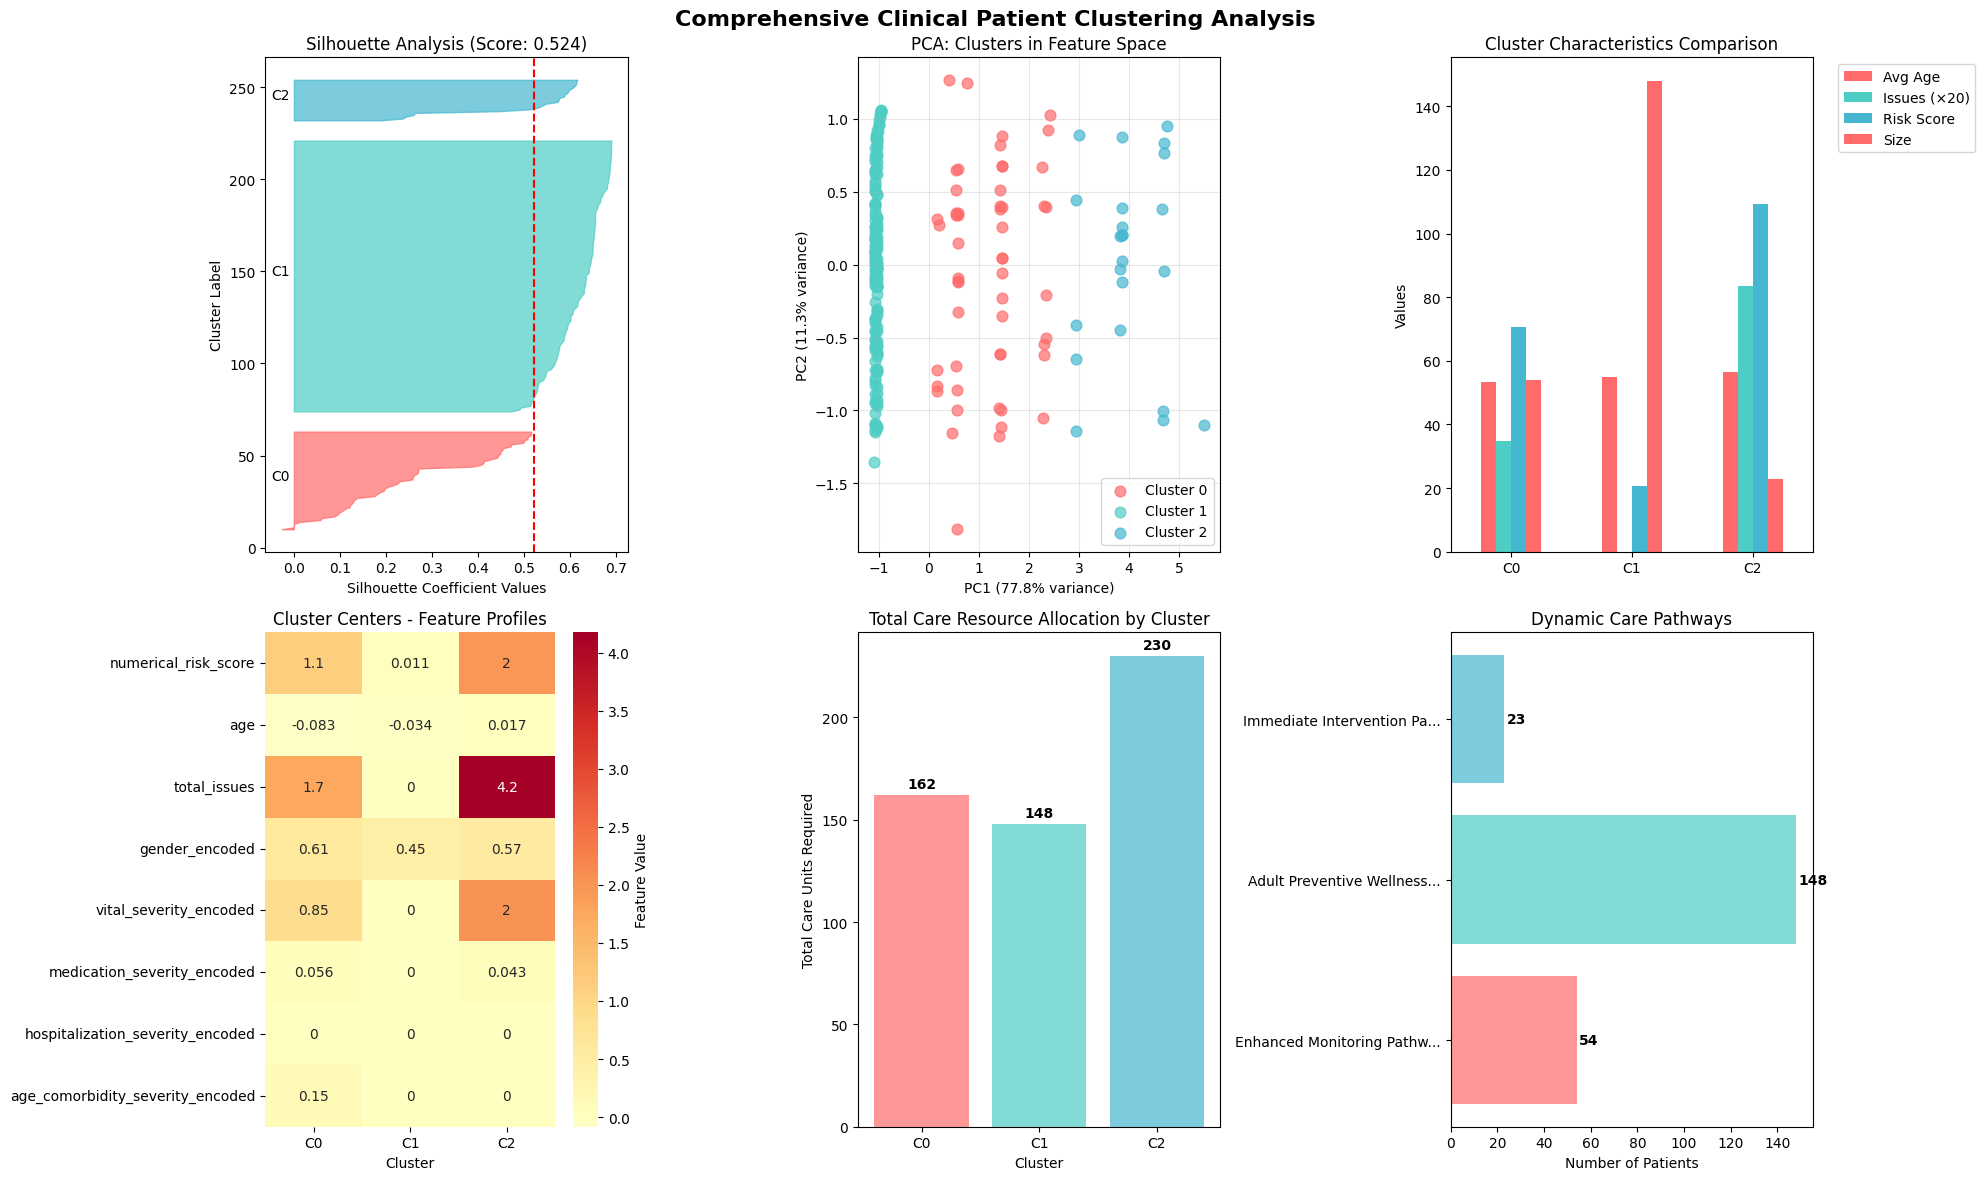


                      STEP 6: VALIDATION AND FINAL SUMMARY                      
FINAL VALIDATION RESULTS
Overall Classification Distribution:
  Stable: 148 patients (65.8%)
  At Risk: 52 patients (23.1%)
  Critical: 25 patients (11.1%)

EXPECTED vs ACTUAL Distribution:
  Stable: Expected 87, Actual 148, Difference: +61
  At Risk: Expected 34, Actual 52, Difference: +18
  Critical: Expected 14, Actual 25, Difference: +11

Clustering Quality Metrics:
  Algorithm: KMEANS
  Number of Clusters: 3
  Silhouette Score: 0.524
  Classification Alignment: 0.988
  Combined Quality Score: 0.895

Dynamic Cluster Pathway Analysis:
  Cluster 0: Enhanced Monitoring Pathway (avg 1.7 issues)
    Population: 54 patients (24.0%)
    Characteristics: {'At Risk': np.int64(52), 'Critical': np.int64(2)}
    Care Focus: Enhanced Monitoring
  Cluster 1: Adult Preventive Wellness Pathway
    Population: 148 patients (65.8%)
    Characteristics: {'Stable': np.int64(148)}
    Care Focus: Preventive Wellness Care


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.manifold import TSNE

plt.style.use('default')
colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7", "#DDA0DD", "#98D8C8", "#F7DC6F"]
plt.rcParams['figure.figsize'] = (15, 8)

print_header("CLINICAL RISK-BASED PATIENT CLUSTERING ANALYSIS")

# ==================== DYNAMIC CLUSTER LABELING FUNCTIONS ====================

def generate_cluster_label(cluster_profile):
    """Generate dynamic, descriptive labels based on actual cluster characteristics"""

    dominant_class = cluster_profile['dominant_classification']
    avg_age = cluster_profile.get('avg_age', 0)
    avg_issues = cluster_profile['avg_issues']

    if avg_issues >= 4:
        return f"Immediate Intervention Pathway (avg {avg_issues:.1f} issues)"
    elif avg_issues >= 2:
        return f"Complex Care Coordination Pathway (avg {avg_issues:.1f} issues)"
    elif avg_issues >= 1:
        return f"Enhanced Monitoring Pathway (avg {avg_issues:.1f} issues)"
    elif avg_age > 65:
        age_group = "Senior" if avg_age > 70 else "Mature Adult"
        return f"Specialized {age_group} Care Pathway"
    else:
        age_group = "Adult" if avg_age > 50 else "Young Adult"
        return f"{age_group} Preventive Wellness Pathway"

# ==================== USE THE EXISTING CLASSIFIER ====================
"""
# Note: We use the existing clinical classification system as a foundation for clustering analysis.
# The classifier provides clinical context and validated health status labels that help us:
# 1. Create meaningful features for clustering (risk scores, severity levels)
# 2. Validate that our clusters align with clinical reality
# 3. Ensure clustering results are clinically interpretable
# Classification is NOT the end goal - it's the starting point for discovering patient care pathways through unsupervised clustering analysis.
"""

print_header("STEP 1: APPLY EXISTING CLASSIFICATION SYSTEM", width=80)
print_dashed_heading("Note: Classification provides clinical validation and feature engineering for clustering analysis. We use existing health status labels to create meaningful clusters, not as the final output.")

def apply_existing_classification():
    """Use the existing ClinicalHealthStatusClassifier to classify all patients"""

    print("Applying existing clinical classification system...")

    # Get all unique patient IDs
    all_patient_ids = patients['id'].unique()
    print(f"Processing {len(all_patient_ids)} patients...")

    # Apply classifier to all patients
    classified_patients = []

    for patient_id in all_patient_ids:
        try:
            result = classifier.classify_patient_health(patient_id)
            if result:
                classified_patients.append(result)
        except Exception as e:
            print(f"Error classifying patient {patient_id}: {e}")
            continue

    # Create DataFrame with classification results
    classification_df = pd.DataFrame(classified_patients)

    # Print results
    if not classification_df.empty:
        final_dist = classification_df['overall_status'].value_counts()
        print(f"\nClassification Results:")
        for classification, count in final_dist.items():
            pct = count / len(classification_df) * 100
            print(f"  {classification}: {count} patients ({pct:.1f}%)")

        # Show some examples
        critical_patients = classification_df[classification_df['overall_status'] == 'Critical']
        if len(critical_patients) > 0:
            print(f"\nSample Critical Patients:")
            for idx, (_, patient) in enumerate(critical_patients.head(3).iterrows()):
                print(f"  {idx+1}. Patient {patient['patient_id']} (Age: {patient['age']:.0f}, {patient['gender']})")
                if patient['issues']:
                    print(f"     Issues: {'; '.join(patient['issues'][:2])}")  # Show first 2 issues

        at_risk_patients = classification_df[classification_df['overall_status'] == 'At Risk']
        if len(at_risk_patients) > 0:
            print(f"\nSample At-Risk Patients:")
            for idx, (_, patient) in enumerate(at_risk_patients.head(3).iterrows()):
                print(f"  {idx+1}. Patient {patient['patient_id']} (Age: {patient['age']:.0f}, {patient['gender']})")
                if patient['issues']:
                    print(f"     Issues: {'; '.join(patient['issues'][:2])}")  # Show first 2 issues

    return classification_df

# Execute classification
patient_features = apply_existing_classification()

# ==================== FEATURE PREPARATION FOR CLUSTERING ====================
print_header("STEP 2: FEATURE PREPARATION FOR CLUSTERING", width=80)

def prepare_clustering_features(df):
    """Prepare features for clustering based on the classification results"""

    if df.empty:
        print("No classified patients to cluster!")
        return None, None, None

    # Create numerical features from classification data
    clustering_features = df.copy()

    # Encode categorical variables
    le_gender = LabelEncoder()
    clustering_features['gender_encoded'] = le_gender.fit_transform(clustering_features['gender'].fillna('Unknown'))

    # Create risk score based on classification
    def create_risk_score(row):
        base_score = {'Stable': 20, 'At Risk': 60, 'Critical': 90}[row['overall_status']]
        # Add variation based on number of issues
        issue_modifier = min(row['total_issues'] * 5, 20)
        # Add age modifier for very elderly patients
        age_modifier = max(0, row['age'] - 80) * 2 if pd.notna(row['age']) else 0
        return base_score + issue_modifier + age_modifier

    clustering_features['numerical_risk_score'] = clustering_features.apply(create_risk_score, axis=1)

    # Encode severity levels
    severity_mapping = {'normal': 0, 'at_risk': 1, 'critical': 2, 'unknown': 0}
    clustering_features['vital_severity_encoded'] = clustering_features['vital_severity'].map(severity_mapping)
    clustering_features['medication_severity_encoded'] = clustering_features['medication_severity'].map(severity_mapping)
    clustering_features['hospitalization_severity_encoded'] = clustering_features['hospitalization_severity'].map(severity_mapping)
    clustering_features['age_comorbidity_severity_encoded'] = clustering_features['age_comorbidity_severity'].map(severity_mapping)

    # Fill missing values
    clustering_features['age'] = clustering_features['age'].fillna(clustering_features['age'].median())

    # Select features for clustering
    feature_columns = [
        'numerical_risk_score',
        'age',
        'total_issues',
        'gender_encoded',
        'vital_severity_encoded',
        'medication_severity_encoded',
        'hospitalization_severity_encoded',
        'age_comorbidity_severity_encoded'
    ]

    clustering_data = clustering_features[feature_columns].copy()

    # Handle any remaining missing values
    clustering_data = clustering_data.fillna(0)

    print(f"Prepared {len(feature_columns)} features for clustering:")
    print(f"Features: {feature_columns}")
    print(f"Data shape: {clustering_data.shape}")

    # FIXED: Return 3 values
    return clustering_data, feature_columns, clustering_features


clustering_data, feature_names, patient_features = prepare_clustering_features(patient_features)

if clustering_data is None:
    print("Error: Could not prepare clustering data")
    exit()

# ==================== OPTIMIZED CLUSTERING ====================
print_header("STEP 3: OPTIMIZED CLUSTERING ANALYSIS", width=80)

def perform_optimized_clustering():
    """Perform clustering optimized for the clinical classifications"""

    print("Testing clustering approaches...")

    # Use RobustScaler to handle outliers better
    scaler = RobustScaler()
    data_scaled = pd.DataFrame(
        scaler.fit_transform(clustering_data),
        columns=clustering_data.columns,
        index=clustering_data.index
    )

    best_results = {}

    # Test different numbers of clusters
    for n_clusters in [3, 4, 5]:
        print(f"\nTesting {n_clusters} clusters...")

        algorithms = {
            'kmeans': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
            'agglomerative': AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        }

        for alg_name, algorithm in algorithms.items():
            try:
                labels = algorithm.fit_predict(data_scaled)

                # Calculate metrics
                silhouette = silhouette_score(data_scaled, labels)

                # Calculate classification alignment
                alignment_score = calculate_classification_alignment(labels)

                result = {
                    'algorithm': alg_name,
                    'n_clusters': n_clusters,
                    'labels': labels,
                    'silhouette': silhouette,
                    'classification_alignment': alignment_score,
                    'data': data_scaled
                }

                best_results[f"{alg_name}_{n_clusters}"] = result

                print(f"  {alg_name.upper()}: Silhouette={silhouette:.3f}, Alignment={alignment_score:.3f}")

            except Exception as e:
                print(f"  {alg_name.upper()} failed: {e}")

    # Select best result based on classification alignment (prioritized) and silhouette
    best_overall = None
    best_combined_score = -1

    for key, result in best_results.items():
        # Weight alignment heavily for clinical relevance
        combined_score = 0.8 * result['classification_alignment'] + 0.2 * result['silhouette']

        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_overall = result
            best_overall['combined_score'] = combined_score

    if best_overall:
        print(f"\nBest clustering result:")
        print(f"  Algorithm: {best_overall['algorithm'].upper()}")
        print(f"  Clusters: {best_overall['n_clusters']}")
        print(f"  Silhouette Score: {best_overall['silhouette']:.3f}")
        print(f"  Classification Alignment: {best_overall['classification_alignment']:.3f}")
        print(f"  Combined Score: {best_overall['combined_score']:.3f}")

    return best_overall

def calculate_classification_alignment(cluster_labels):
    """Calculate how well clusters align with the clinical classification"""

    alignment_scores = []

    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_patients = patient_features.iloc[cluster_mask]

        if len(cluster_patients) == 0:
            continue

        # Calculate purity of this cluster (dominant classification percentage)
        class_dist = cluster_patients['overall_status'].value_counts(normalize=True)
        purity = class_dist.iloc[0] if len(class_dist) > 0 else 0
        alignment_scores.append(purity)

    return np.mean(alignment_scores) if alignment_scores else 0

best_result = perform_optimized_clustering()

if not best_result:
    print("Error: Clustering failed")
    exit()

# ==================== DETAILED CLUSTER ANALYSIS ====================
print_header("STEP 4: DETAILED CLUSTER ANALYSIS", width=80)

def analyze_clusters():
    """Analyze the clusters with clinical interpretation"""

    # Add cluster assignments to patient data
    patient_features['cluster'] = best_result['labels']

    print("DETAILED CLUSTER ANALYSIS")
    print("=" * 50)

    cluster_profiles = {}
    actual_clusters = sorted(patient_features['cluster'].unique())
    total_patients = len(patient_features)

    for cluster_id in actual_clusters:
        cluster_data = patient_features[patient_features['cluster'] == cluster_id]
        n_patients = len(cluster_data)

        if n_patients == 0:
            continue

        percentage = (n_patients / total_patients) * 100

        # Create cluster profile for dynamic labeling
        basic_profile = {
            'size': n_patients,
            'percentage': percentage,
            'dominant_classification': cluster_data['overall_status'].value_counts().index[0],
            'avg_risk_score': cluster_data['numerical_risk_score'].mean(),
            'avg_issues': cluster_data['total_issues'].mean(),
            'avg_age': cluster_data['age'].mean(),
            'classification_distribution': dict(cluster_data['overall_status'].value_counts()),
        }

        # Generate dynamic label
        dynamic_label = generate_cluster_label(basic_profile)

        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id} - {dynamic_label}")
        print(f"{n_patients} patients ({percentage:.1f}%)")
        print(f"{'='*60}")

        # Classification distribution
        class_dist = cluster_data['overall_status'].value_counts()
        dominant_class = class_dist.index[0] if len(class_dist) > 0 else 'Unknown'

        print(f"CLINICAL CLASSIFICATION:")
        print(f"  Distribution: {dict(class_dist)}")
        print(f"  Dominant Classification: {dominant_class}")
        print(f"  Average Risk Score: {cluster_data['numerical_risk_score'].mean():.1f}")

        # Demographics
        avg_age = cluster_data['age'].mean()
        gender_dist = cluster_data['gender'].value_counts(normalize=True)

        print(f"\nDEMOGRAPHICS:")
        print(f"  Average Age: {avg_age:.1f} years")
        print(f"  Gender Distribution: {dict(gender_dist.round(3))}")

        # Clinical severity profile
        print(f"\nCLINICAL SEVERITY PROFILE:")
        print(f"  Average Total Issues: {cluster_data['total_issues'].mean():.1f}")

        # Component severity distribution
        severity_components = ['vital_severity', 'medication_severity', 'hospitalization_severity', 'age_comorbidity_severity']
        for component in severity_components:
            if component in cluster_data.columns:
                comp_dist = cluster_data[component].value_counts()
                print(f"  {component.replace('_', ' ').title()}: {dict(comp_dist)}")

        # Show example patients with their issues
        print(f"\nEXAMPLE PATIENTS:")
        examples = cluster_data.head(3)
        for i, (_, patient) in enumerate(examples.iterrows()):
            print(f"  {i+1}. Patient {patient['patient_id']} - {patient['overall_status']} (Age: {patient['age']:.0f}, {patient['gender']})")
            if patient['issues'] and len(patient['issues']) > 0:
                # Show up to 2 main issues
                main_issues = patient['issues'][:2] if isinstance(patient['issues'], list) else [str(patient['issues'])[:100]]
                for issue in main_issues:
                    print(f"     • {issue}")

        # Care recommendations based on dynamic label
        if basic_profile['avg_issues'] >= 4:
            care_model = "Immediate Intervention Management"
            visit_freq = "Daily to weekly"
            resources = "Emergency response teams, intensive monitoring, specialist consultations"
        elif basic_profile['avg_issues'] >= 2:
            care_model = "Complex Care Coordination"
            visit_freq = "Weekly to bi-weekly"
            resources = "Multidisciplinary care teams, care coordinators, regular monitoring"
        elif basic_profile['avg_issues'] >= 1:
            care_model = "Enhanced Monitoring"
            visit_freq = "Bi-weekly to monthly"
            resources = "Care coordinators, regular check-ups, preventive interventions"
        elif basic_profile['avg_age'] > 65:
            care_model = "Specialized Senior Care"
            visit_freq = "Monthly to quarterly"
            resources = "Geriatric specialists, fall prevention, cognitive assessments"
        else:
            care_model = "Preventive Wellness Care"
            visit_freq = "Quarterly to annual"
            resources = "Primary care, routine screenings, health maintenance"

        print(f"\nCARE RECOMMENDATIONS:")
        print(f"  Care Model: {care_model}")
        print(f"  Visit Frequency: {visit_freq}")
        print(f"  Resources: {resources}")

        # Add dynamic label to profile
        basic_profile['dynamic_label'] = dynamic_label
        basic_profile['care_model'] = care_model

        cluster_profiles[cluster_id] = basic_profile

    return cluster_profiles

cluster_profiles = analyze_clusters()

# ==================== COMPREHENSIVE CLUSTERING VISUALIZATION ====================
print_header("STEP 5: COMPREHENSIVE CLUSTERING VISUALIZATION", width=80)

def create_clustering_visualizations():
    """Create comprehensive clustering-focused visualizations"""

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Comprehensive Clinical Patient Clustering Analysis', fontsize=16, fontweight='bold')

    # Get dynamic labels for plotting
    cluster_labels = best_result['labels']
    unique_clusters = sorted(np.unique(cluster_labels))
    dynamic_labels = [cluster_profiles[cid]['dynamic_label'] for cid in unique_clusters]

    # 1. Silhouette Analysis
    sample_silhouette_values = silhouette_samples(best_result['data'], cluster_labels)

    y_lower = 10
    for i, cluster_id in enumerate(unique_clusters):
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_id]
        cluster_silhouette_values.sort()

        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        axes[0,0].fill_betweenx(np.arange(y_lower, y_upper),
                               0, cluster_silhouette_values,
                               facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

        axes[0,0].text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{cluster_id}')
        y_lower = y_upper + 10

    axes[0,0].axvline(x=best_result['silhouette'], color="red", linestyle="--")
    axes[0,0].set_xlabel('Silhouette Coefficient Values')
    axes[0,0].set_ylabel('Cluster Label')
    axes[0,0].set_title(f'Silhouette Analysis (Score: {best_result["silhouette"]:.3f})')

    # 2. PCA Cluster Visualization
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(best_result['data'])

    for i, cluster_id in enumerate(unique_clusters):
        cluster_mask = cluster_labels == cluster_id
        axes[0,1].scatter(pca_data[cluster_mask, 0], pca_data[cluster_mask, 1],
                         c=colors[i], label=f'Cluster {cluster_id}', alpha=0.7, s=60)

    axes[0,1].set_title('PCA: Clusters in Feature Space')
    axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Cluster Characteristics Comparison
    cluster_characteristics = []
    labels = []

    for cluster_id in unique_clusters:
        profile = cluster_profiles[cluster_id]
        cluster_characteristics.append([
            profile['avg_age'],
            profile['avg_issues'] * 20,  # Scale for visibility
            profile['avg_risk_score'],
            profile['size']
        ])
        labels.append(f'C{cluster_id}')

    cluster_chars_df = pd.DataFrame(cluster_characteristics,
                                   columns=['Avg Age', 'Issues (×20)', 'Risk Score', 'Size'],
                                   index=labels)

    cluster_chars_df.plot(kind='bar', ax=axes[0,2], color=colors[:len(unique_clusters)])
    axes[0,2].set_title('Cluster Characteristics Comparison')
    axes[0,2].set_ylabel('Values')
    axes[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,2].tick_params(axis='x', rotation=0)

    # 4. Feature Importance Heatmap
    cluster_centers = []
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_center = best_result['data'][cluster_mask].mean()
        cluster_centers.append(cluster_center)

    cluster_centers_df = pd.DataFrame(cluster_centers,
                                    columns=best_result['data'].columns,
                                    index=[f'C{cid}' for cid in unique_clusters])

    sns.heatmap(cluster_centers_df.T, annot=True, cmap='RdYlBu_r', center=0,
                ax=axes[1,0], cbar_kws={'label': 'Feature Value'})
    axes[1,0].set_title('Cluster Centers - Feature Profiles')
    axes[1,0].set_xlabel('Cluster')

    # 5. Care Resource Allocation
    resource_allocation = []
    care_units_per_patient = []

    for cluster_id in unique_clusters:
        profile = cluster_profiles[cluster_id]
        if profile['avg_issues'] >= 4:
            units = 10
        elif profile['avg_issues'] >= 2:
            units = 5
        elif profile['avg_issues'] >= 1:
            units = 3
        else:
            units = 1

        care_units_per_patient.append(units)
        resource_allocation.append(units * profile['size'])

    bars = axes[1,1].bar([f'C{cid}' for cid in unique_clusters], resource_allocation,
                         color=colors[:len(unique_clusters)], alpha=0.7)

    for bar, value in zip(bars, resource_allocation):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                      f'{int(value)}', ha='center', va='bottom', fontweight='bold')

    axes[1,1].set_title('Total Care Resource Allocation by Cluster')
    axes[1,1].set_ylabel('Total Care Units Required')
    axes[1,1].set_xlabel('Cluster')

    # 6. Dynamic Care Pathways Summary
    pathway_sizes = [cluster_profiles[cid]['size'] for cid in unique_clusters]
    truncated_labels = [label[:25] + "..." if len(label) > 25 else label
                       for label in dynamic_labels]

    bars = axes[1,2].barh(range(len(unique_clusters)), pathway_sizes,
                         color=colors[:len(unique_clusters)], alpha=0.7)

    axes[1,2].set_yticks(range(len(unique_clusters)))
    axes[1,2].set_yticklabels(truncated_labels)
    axes[1,2].set_xlabel('Number of Patients')
    axes[1,2].set_title('Dynamic Care Pathways')

    for i, (bar, size) in enumerate(zip(bars, pathway_sizes)):
        axes[1,2].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                      f'{size}', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

create_clustering_visualizations()

# ==================== FINAL VALIDATION AND SUMMARY ====================
print_header("STEP 6: VALIDATION AND FINAL SUMMARY", width=80)

def final_validation():
    """Final validation and summary"""

    print("FINAL VALIDATION RESULTS")
    print("=" * 50)

    # Classification distribution validation
    overall_class_dist = patient_features['overall_status'].value_counts()
    print(f"Overall Classification Distribution:")
    for classification, count in overall_class_dist.items():
        pct = count / len(patient_features) * 100
        print(f"  {classification}: {count} patients ({pct:.1f}%)")

    # Expected vs Actual comparison
    print(f"\nEXPECTED vs ACTUAL Distribution:")
    expected = {'Stable': 87, 'At Risk': 34, 'Critical': 14}
    actual = dict(overall_class_dist)

    for status in ['Stable', 'At Risk', 'Critical']:
        exp = expected.get(status, 0)
        act = actual.get(status, 0)
        diff = act - exp
        print(f"  {status}: Expected {exp}, Actual {act}, Difference: {diff:+d}")

    # Clustering quality metrics
    print(f"\nClustering Quality Metrics:")
    print(f"  Algorithm: {best_result['algorithm'].upper()}")
    print(f"  Number of Clusters: {best_result['n_clusters']}")
    print(f"  Silhouette Score: {best_result['silhouette']:.3f}")
    print(f"  Classification Alignment: {best_result['classification_alignment']:.3f}")
    print(f"  Combined Quality Score: {best_result['combined_score']:.3f}")

    # Dynamic cluster composition analysis
    print(f"\nDynamic Cluster Pathway Analysis:")
    for cluster_id, profile in cluster_profiles.items():
        print(f"  Cluster {cluster_id}: {profile['dynamic_label']}")
        print(f"    Population: {profile['size']} patients ({profile['percentage']:.1f}%)")
        print(f"    Characteristics: {profile['classification_distribution']}")
        print(f"    Care Focus: {profile['care_model']}")

    # Resource allocation summary
    print(f"\nResource Allocation Summary:")
    total_care_units = 0

    for cluster_id, profile in cluster_profiles.items():
        if profile['avg_issues'] >= 4:
            care_units_per_patient = 10
        elif profile['avg_issues'] >= 2:
            care_units_per_patient = 5
        elif profile['avg_issues'] >= 1:
            care_units_per_patient = 3
        else:
            care_units_per_patient = 1

        cluster_care_units = profile['size'] * care_units_per_patient
        total_care_units += cluster_care_units

        print(f"  {profile['dynamic_label'][:40]}:")
        print(f"    Patients: {profile['size']}")
        print(f"    Care Units per Patient: {care_units_per_patient}")
        print(f"    Total Care Units: {cluster_care_units}")

    print(f"  Total System Care Units Required: {total_care_units}")

    return {
        'total_patients': len(patient_features),
        'distribution': dict(overall_class_dist),
        'clustering_quality': best_result['combined_score'],
        'total_care_units': total_care_units,
        'cluster_count': best_result['n_clusters'],
        'dynamic_pathways': {cid: profile['dynamic_label'] for cid, profile in cluster_profiles.items()}
    }

final_results = final_validation()

print_header("CLUSTERING ANALYSIS COMPLETE", width=80)

print(f"FINAL SUMMARY:")
print(f"Successfully clustered {final_results['total_patients']} patients")
print(f"Distribution - Critical: {final_results['distribution'].get('Critical', 0)}, "
      f"At Risk: {final_results['distribution'].get('At Risk', 0)}, "
      f"Stable: {final_results['distribution'].get('Stable', 0)}")
print(f"Clustering created {final_results['cluster_count']} distinct patient groups")
print(f"Clustering quality score: {final_results['clustering_quality']:.3f}")
print(f"Total care resource units needed: {final_results['total_care_units']}")

print(f"\nDynamic Care Pathways Created:")
for cluster_id, pathway in final_results['dynamic_pathways'].items():
    print(f"  - Cluster {cluster_id}: {pathway}")